# Our goal: for each of Glacier Bay's acoustic records, plot $n$ versus $\text{NFI}$

### We'll compute $n$ using AIS data, acknowledging that $n_{\text{AIS}} \subset n_{\text{tot}}$

In [448]:
# geoprocessing libraries
import fiona
from fiona.crs import from_epsg
import pyproj
import geopandas as gpd
from shapely.ops import transform, linemerge, unary_union
from shapely.geometry import mapping, Point, Polygon
import rasterio
import rasterio.mask
from rasterio.plot import show

# some 'everyday' libraries
import matplotlib.colors as mcolor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from functools import partial
import datetime as dt
import pytz
import os
import glob

import cmocean # special cyclic colormap

import sys

# specialized NPS libraries
import iyore

sys.path.append(r"C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\soundDB")
from soundDB import nvspl, srcid

sys.path.append(r"C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\GLBA-vesselAcoustics")
from AIS_utilities import *


sys.path.append(r"C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\derivedDataFunctions")
from merge_SRCID import *
from derivedDataFunctions import *

def geometric_nfi(gdf_tracks):
    
    '''
    Find the time periods where AIS-equipped vessels
    are not within the buffered area. (Or their signals
    are not being broadcasted...)
    
    Returns
    -------
    NFIs (numpy array): length of periods without vessels (in seconds)
    '''
    # our local time zone
    akt = pytz.timezone('US/Alaska')
    
    # create an array for subsequent (geometric) NFI analysis
    NFI_pairs = np.array([])
    
    total_events = 0 # initialize

    # iterate through each vessel
    for MMSI, data in gdf_tracks.groupby("MMSI"):
        
        print("now processing MMSI:", MMSI)

        # this 'one-liner' sorts the datetimes, differences them, converts the timedeltas to minutes, and binarizes
        # into a boolean (gaps > 15 minutes: True, gaps ≤ 15 minutes: False)
        # since this is an analysis of Noise-Free Intervals
        data["Events"] = data["Datetime"].sort_values().diff().apply(lambda t: t.total_seconds()/60) > 15.0
        
        # a concise way to group by temporal gaps; overwriting the previous boolean
        data["Events"] = data["Events"].apply(lambda x: 1 if x else 0).cumsum()
        data["Events"] = data["Events"]+1 # overcome zero-indexing
        
        total_events += len(data.groupby("Events"))
        print("\t", total_events, "total events thus far")
        
        # our goal is to summarize noise by event
        for event, event_data in data.groupby("Events"):

            # use the entry point to compute the UTC offset
            offset = akt.utcoffset(event_data["Datetime"].iloc[0])

            # when did the event enter/exit the buffered area?
            enter = event_data["Datetime"].iloc[0] + offset
            exit = event_data["Datetime"].iloc[-1] + offset

            # append array with enter/exit times
            NFI_pairs = np.append(NFI_pairs, [enter.to_pydatetime(), 
                                              exit.to_pydatetime()])


    # group the pairs by event
    NFI_pairs = NFI_pairs.reshape((int(NFI_pairs.shape[0]/2), 2))

    # begin and end times as datetime objects
    time_s = gdf_tracks["Datetime"].min().to_pydatetime()
    time_e = gdf_tracks["Datetime"].max().to_pydatetime()

    # an array containing every second of the record as datetime
    all_seconds = np.array([time_s + dt.timedelta(seconds=i) for 
                            i in range(int((time_e-time_s).total_seconds()))])

    # a boolean array the same length as the record
    within_times = np.zeros(all_seconds.shape)

    for NFI_pair in NFI_pairs:

        try:

            # convert the enter/exit times into integer indices
            ind_begin = np.argwhere(all_seconds == NFI_pair[0])[0][0]
            ind_end = np.argwhere(all_seconds == NFI_pair[1])[0][0]

            # set values between the two indices equal to 'True'
            within_times[ind_begin:ind_end] = 1.0

        except IndexError:
            pass # basically the event had no duration


    # finally, find the times where vessels were not in the buffer
    # and do a bit of rearranging to arrive at (geometric) NFI values
    nfi_bounds = contiguous_regions(within_times == 0)
    NFIs = (nfi_bounds.T[1] - nfi_bounds.T[0])

    return NFIs, total_events

## Step One: Find and merge GLBA SRCID files. Compute $\text{NFI}_{observed}$.

In [115]:
# which drive are the acoustic data on?
ds = iyore.Dataset(r"E:")

# find SRCID files for 2020
designators = [(e.unit, e.site, e.year) for e in ds.srcid(unit="GLBA")]

nfis = []
des_out = []
ns = []
for des in designators:
    
    u, s, y = des # unpack the designator, load and merge the corresponding SRCID file...
    src_raw = srcid(ds, unit=u, site=s, year=y).combine()
    
    # filter out aircraft noise source types
    src = src_raw.loc[((src_raw["srcID"] != 1.0)&
                       (src_raw["srcID"] != 1.1)&
                       (src_raw["srcID"] != 1.2)&
                       (src_raw["srcID"] != 1.3)&
                       (src_raw["srcID"] <= 3.0)), :]
    
    for id_ in src.srcID.unique():
        print(id_)
    
    ns.append(len(src)/len(np.unique(src.index.date))) # number of noise events / number days
    nfis.append(NFI_list(src))
    des_out.append(des)

#merged_srcids


3.0


C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\derivedDataFunctions\derivedDataFunctions.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srcid.sort_index(inplace=True)



3.0


C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\derivedDataFunctions\derivedDataFunctions.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srcid.sort_index(inplace=True)



3.0


C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\derivedDataFunctions\derivedDataFunctions.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srcid.sort_index(inplace=True)



3.0


C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\derivedDataFunctions\derivedDataFunctions.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srcid.sort_index(inplace=True)



3.0


C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\derivedDataFunctions\derivedDataFunctions.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srcid.sort_index(inplace=True)



1.205
3.0
1.164
1.223
1.264


C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\derivedDataFunctions\derivedDataFunctions.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srcid.sort_index(inplace=True)



1.069
1.011
1.287
1.219
1.274
1.19
1.206
1.202
1.158
0.741
1.155
1.268
0.984
3.0
1.223
1.224
1.22
1.23
0.708


C:\Users\DBetchkal\PythonScripts\3 GITHUB REPOSITORIES\derivedDataFunctions\derivedDataFunctions.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srcid.sort_index(inplace=True)


#### Let's have a look at the observed values...

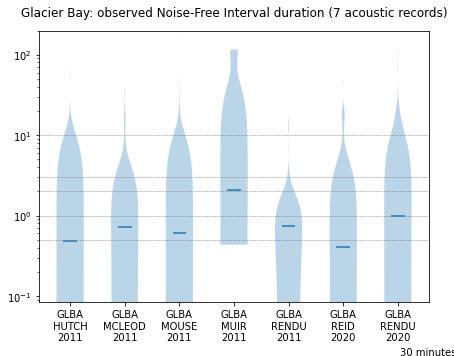

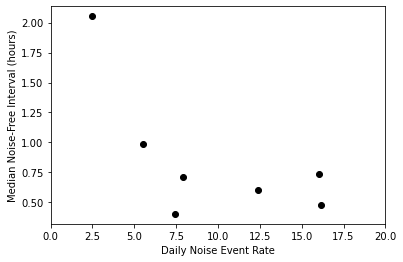

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Create the boxplot
bp = ax.violinplot(nfis, showmedians=True, points=200, showextrema=False)
plt.yscale('log')
ax.set_ylim([5/60, 200]) # 15 minutes to...
ax.set_xticks(np.arange(len(des_out))+1)
ax.set_xticklabels([d[0]+"\n"+d[1]+"\n"+str(d[2]) for d in des_out])

ax.axhline(0.5, lw=0.5, ls="--", color="gray", zorder=5)
plt.annotate("30 minutes", (400, 0.5), xycoords='figure pixels')
ax.axhline(1, lw=0.5, ls="--", color="gray", zorder=5)
ax.axhline(2, lw=0.5, ls="--", color="gray", zorder=5)
ax.axhline(3, lw=0.5, ls="--", color="gray", zorder=5)
ax.axhline(10, lw=0.5, ls="--", color="gray", zorder=5)

ax.set_title("Glacier Bay: observed Noise-Free Interval duration (7 acoustic records)", y=1.03)
plt.show()


plt.plot(ns, [np.nanpercentile(l, 50) for l in nfis], ls="", marker="o", color="k")
plt.ylabel("Median Noise-Free Interval (hours)")
plt.xlabel("Daily Noise Event Rate")
plt.xlim([0, 20])
plt.show()

## Step Two: Select spatially-balanced points at which to simulate $\text{NFI}$.

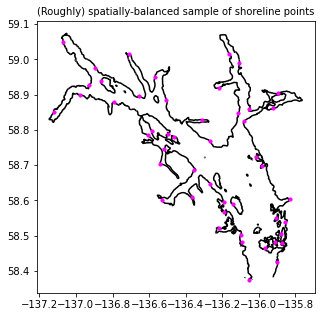

In [153]:
GLBA_proper = r"C:\Users\DBetchkal\Documents\ArcGIS\Projects\AKR_Useful\GLBA_GlacierBayCoast.shp"

theBay_WGS84 = gpd.read_file(GLBA_proper)
theBay = theBay_WGS84.to_crs("EPSG:3338")

merged_shorelines = linemerge(theBay.unary_union)

desired_distance_delta = 50 # m?

# THIS IS A REALLY INTERESTING PROBLEM 
# ROUGHLY: HOW DO WE PICK EQUALLY-SPACED
# POINTS ALONG A FRACTAL OBJECT?
final_points = []
for linestring in merged_shorelines:
    
    # or to get the distances closest to the desired one:
    n = round(linestring.length / desired_distance_delta)
    distances = np.linspace(0, linestring.length, n)
    
    points = [linestring.interpolate(distance) for distance in distances]
    for point in points:
        final_points.append(point)
    

BayPoints_equalarea = gpd.GeoDataFrame([], geometry=final_points, crs=theBay.crs)
BayPoints = BayPoints_equalarea.to_crs("EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("(Roughly) spatially-balanced sample of shoreline points", 
             fontsize=10, loc="left")
# random_points = np.random.choice(BayPoints.index, size=50, replace=False)
BayPoints.iloc[::400, :].plot(ax=ax, markersize=10, color="magenta")
# BayPoints.plot(ax=ax, markersize=10, color="magenta")
theBay_WGS84.plot(ax=ax, color="k", zorder=-1)
plt.show()


## Step Three: At listening points, iteratively select AIS data to determine $\text{NFI}_{simulated}$ and $n$
First, let's load the AIS data...

In [170]:
AIS_data_location = r"C:\Users\DBetchkal\Documents\ArcGIS\Projects\GLBA_AIS_20200925\GLBA_20200901 to 20201001"
AIS = load_AIS_from_csv(AIS_data_location, 
                        column_convention="raw", 
                        mask=None)

		61 .csv files will be processed...
		Dates have been stripped from the files...
		Files have been concatenated into a `pd.DataFrame` object...
		1090 MHz ADS-B data have been dropped...
		Raw `gpd.GeoDataFrame` object has been created...
		Finished creating GeoDataFrame!


Compute the simulated $\text{NFI}$ and $n$

Now computing POINT (-136.0530150940097 58.37273877353994)


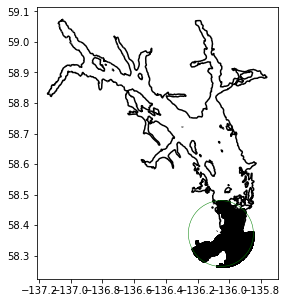

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 249241000
	 13 total events thus far
now processing MMSI: 303683000
	 14 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 316011757
	 25 total events thus far
now processing MMSI: 319009500
	 27 total events thus far
now processing MMSI: 319063600
	 29 total events thus far
now processing MMSI: 319139700
	 32 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 41 total events thus far
now processing MMSI: 319264000
	 45 total events thus far
now processing MMSI: 319822000
	 51 total events thus far
now processing MMSI: 338043017
	 53 total events thus far
now processing MM

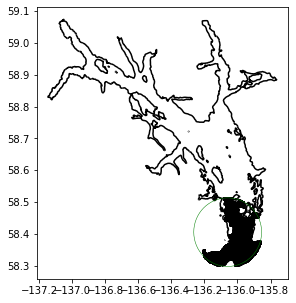

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 249241000
	 20 total events thus far
now processing MMSI: 303683000
	 21 total events thus far
now processing MMSI: 316005813
	 26 total events thus far
now processing MMSI: 316011757
	 29 total events thus far
now processing MMSI: 319009500
	 31 total events thus far
now processing MMSI: 319063600
	 33 total events thus far
now processing MMSI: 319139700
	 35 total events thus far
now processing MMSI: 319144200
	 37 total events thus far
now processing MMSI: 319147200
	 39 total events thus far
now processing MMSI: 319175300
	 44 total events thus far
now processing MMSI: 319264000
	 47 total events thus far
now processing MMSI: 319822000
	 53 total events thus far
now processing MMSI: 338043017
	 55 total events thus far
now processing M

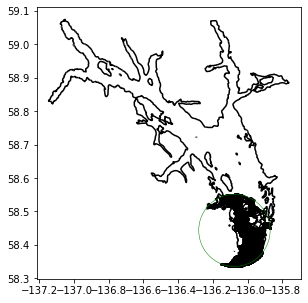

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 316011757
	 24 total events thus far
now processing MMSI: 319009500
	 26 total events thus far
now processing MMSI: 319063600
	 28 total events thus far
now processing MMSI: 319139700
	 30 total events thus far
now processing MMSI: 319144200
	 32 total events thus far
now processing MMSI: 319147200
	 34 total events thus far
now processing MMSI: 319175300
	 41 total events thus far
now processing MMSI: 319264000
	 44 total events thus far
now processing MMSI: 319822000
	 51 total events thus far
now processing MMSI: 338043017
	 53 total events thus far
now processing MMSI: 338103017
	 55 total events thus far
now processing MMSI: 338103952
	 76 total events thus far
now processing M

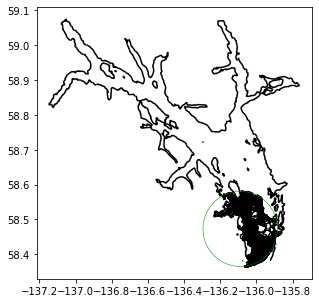

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 316005813
	 15 total events thus far
now processing MMSI: 319009500
	 17 total events thus far
now processing MMSI: 319063600
	 19 total events thus far
now processing MMSI: 319139700
	 21 total events thus far
now processing MMSI: 319144200
	 23 total events thus far
now processing MMSI: 319147200
	 25 total events thus far
now processing MMSI: 319175300
	 31 total events thus far
now processing MMSI: 319264000
	 34 total events thus far
now processing MMSI: 319822000
	 41 total events thus far
now processing MMSI: 338043017
	 43 total events thus far
now processing MMSI: 338103017
	 46 total events thus far
now processing MMSI: 338103952
	 53 total events thus far
now processing MMSI: 338120189
	 55 total events thus far
now processing MM

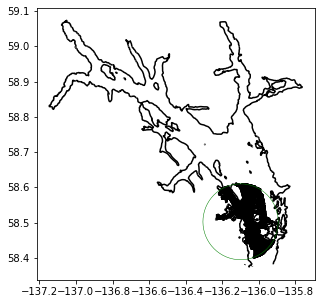

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 316005813
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 17 total events thus far
now processing MMSI: 319139700
	 19 total events thus far
now processing MMSI: 319144200
	 21 total events thus far
now processing MMSI: 319147200
	 23 total events thus far
now processing MMSI: 319175300
	 29 total events thus far
now processing MMSI: 319264000
	 33 total events thus far
now processing MMSI: 319822000
	 40 total events thus far
now processing MMSI: 338043017
	 42 total events thus far
now processing MMSI: 338103017
	 44 total events thus far
now processing MMSI: 338103952
	 48 total events thus far
now processing MMSI: 338120189
	 60 total events thus far
now processing MM

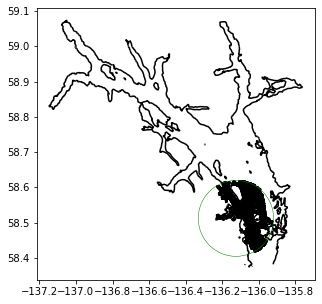

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 9 total events thus far
now processing MMSI: 316005813
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 19 total events thus far
now processing MMSI: 319147200
	 21 total events thus far
now processing MMSI: 319175300
	 27 total events thus far
now processing MMSI: 319264000
	 31 total events thus far
now processing MMSI: 319822000
	 38 total events thus far
now processing MMSI: 338043017
	 40 total events thus far
now processing MMSI: 338103017
	 42 total events thus far
now processing MMSI: 338103952
	 46 total events thus far
now processing MMSI: 338120189
	 59 total events thus far
now processing MMS

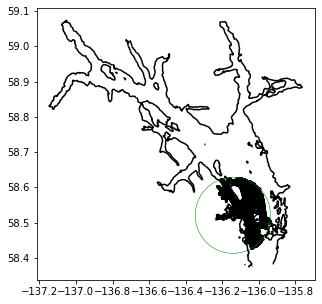

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319139700
	 18 total events thus far
now processing MMSI: 319144200
	 20 total events thus far
now processing MMSI: 319147200
	 22 total events thus far
now processing MMSI: 319175300
	 28 total events thus far
now processing MMSI: 319264000
	 32 total events thus far
now processing MMSI: 319822000
	 38 total events thus far
now processing MMSI: 338043017
	 40 total events thus far
now processing MMSI: 338103017
	 42 total events thus far
now processing MMSI: 338103952
	 46 total events thus far
now processing MMSI: 338120189
	 59 total events thus far
now processing MM

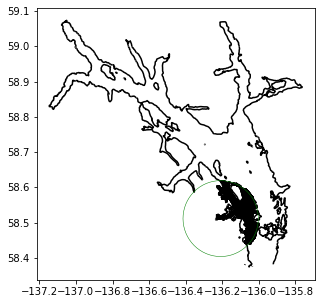

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 8 total events thus far
now processing MMSI: 316005813
	 10 total events thus far
now processing MMSI: 319009500
	 12 total events thus far
now processing MMSI: 319063600
	 14 total events thus far
now processing MMSI: 319139700
	 16 total events thus far
now processing MMSI: 319144200
	 18 total events thus far
now processing MMSI: 319147200
	 20 total events thus far
now processing MMSI: 319175300
	 26 total events thus far
now processing MMSI: 319264000
	 30 total events thus far
now processing MMSI: 319822000
	 36 total events thus far
now processing MMSI: 338043017
	 38 total events thus far
now processing MMSI: 338103017
	 40 total events thus far
now processing MMSI: 338103952
	 44 total events thus far
now processing MMSI: 338120189
	 57 total events thus far
now processing MMS

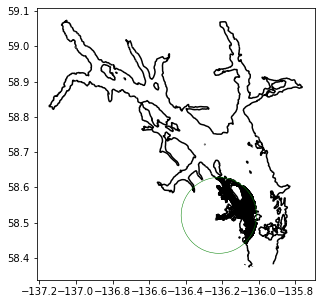

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 8 total events thus far
now processing MMSI: 316005813
	 10 total events thus far
now processing MMSI: 319009500
	 12 total events thus far
now processing MMSI: 319063600
	 14 total events thus far
now processing MMSI: 319139700
	 16 total events thus far
now processing MMSI: 319144200
	 18 total events thus far
now processing MMSI: 319147200
	 20 total events thus far
now processing MMSI: 319175300
	 26 total events thus far
now processing MMSI: 319264000
	 30 total events thus far
now processing MMSI: 319822000
	 36 total events thus far
now processing MMSI: 338043017
	 38 total events thus far
now processing MMSI: 338103017
	 40 total events thus far
now processing MMSI: 338103952
	 44 total events thus far
now processing MMSI: 338120189
	 57 total events thus far
now processing MMS

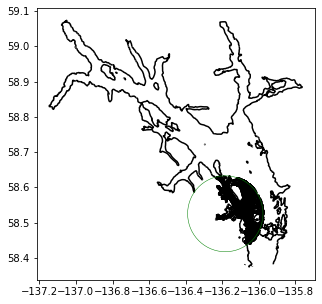

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319139700
	 18 total events thus far
now processing MMSI: 319144200
	 20 total events thus far
now processing MMSI: 319147200
	 22 total events thus far
now processing MMSI: 319175300
	 28 total events thus far
now processing MMSI: 319264000
	 32 total events thus far
now processing MMSI: 319822000
	 38 total events thus far
now processing MMSI: 338043017
	 40 total events thus far
now processing MMSI: 338103017
	 42 total events thus far
now processing MMSI: 338103952
	 46 total events thus far
now processing MMSI: 338120189
	 59 total events thus far
now processing MM

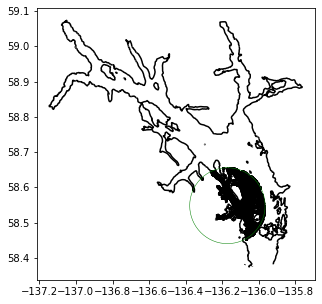

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319139700
	 18 total events thus far
now processing MMSI: 319144200
	 20 total events thus far
now processing MMSI: 319147200
	 22 total events thus far
now processing MMSI: 319175300
	 29 total events thus far
now processing MMSI: 319264000
	 33 total events thus far
now processing MMSI: 319822000
	 39 total events thus far
now processing MMSI: 338043017
	 41 total events thus far
now processing MMSI: 338103017
	 43 total events thus far
now processing MMSI: 338103952
	 47 total events thus far
now processing MMSI: 338120189
	 60 total events thus far
now processing MM

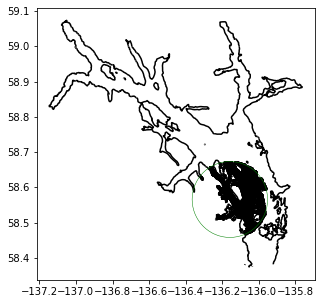

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 28 total events thus far
now processing MMSI: 319139700
	 30 total events thus far
now processing MMSI: 319144200
	 32 total events thus far
now processing MMSI: 319147200
	 34 total events thus far
now processing MMSI: 319175300
	 41 total events thus far
now processing MMSI: 319264000
	 45 total events thus far
now processing MMSI: 319822000
	 51 total events thus far
now processing MMSI: 338043017
	 64 total events thus far
now processing MMSI: 338103017
	 66 total events thus far
now processing MMSI: 338103952
	 70 total events thus far
now processing MMSI: 338120189
	 83 total events thus far
now processing MM

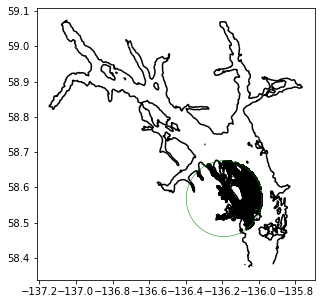

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 316005813
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 30 total events thus far
now processing MMSI: 319139700
	 32 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 42 total events thus far
now processing MMSI: 319264000
	 46 total events thus far
now processing MMSI: 319822000
	 54 total events thus far
now processing MMSI: 338043017
	 67 total events thus far
now processing MMSI: 338103017
	 69 total events thus far
now processing MMSI: 338103952
	 73 total events thus far
now processing MMSI: 338120189
	 86 total events thus far
now processing MM

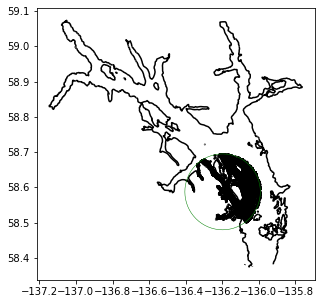

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 15 total events thus far
now processing MMSI: 319009500
	 17 total events thus far
now processing MMSI: 319063600
	 31 total events thus far
now processing MMSI: 319139700
	 33 total events thus far
now processing MMSI: 319144200
	 35 total events thus far
now processing MMSI: 319147200
	 37 total events thus far
now processing MMSI: 319175300
	 44 total events thus far
now processing MMSI: 319264000
	 48 total events thus far
now processing MMSI: 319822000
	 55 total events thus far
now processing MMSI: 338043017
	 69 total events thus far
now processing MMSI: 338103017
	 71 total events thus far
now processing MMSI: 338103952
	 74 total events thus far
now processing MMSI: 338120189
	 87 total events thus far
now processing MM

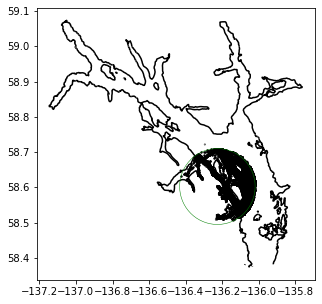

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 316005813
	 18 total events thus far
now processing MMSI: 319009500
	 20 total events thus far
now processing MMSI: 319063600
	 35 total events thus far
now processing MMSI: 319139700
	 37 total events thus far
now processing MMSI: 319144200
	 39 total events thus far
now processing MMSI: 319147200
	 41 total events thus far
now processing MMSI: 319175300
	 46 total events thus far
now processing MMSI: 319264000
	 50 total events thus far
now processing MMSI: 319822000
	 57 total events thus far
now processing MMSI: 338043017
	 72 total events thus far
now processing MMSI: 338103017
	 74 total events thus far
now processing MMSI: 338103952
	 77 total events thus far
now processing MMSI: 338120189
	 90 total events thus far
now processing MM

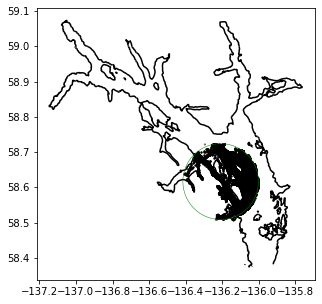

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 316005813
	 19 total events thus far
now processing MMSI: 319009500
	 21 total events thus far
now processing MMSI: 319063600
	 36 total events thus far
now processing MMSI: 319139700
	 38 total events thus far
now processing MMSI: 319144200
	 40 total events thus far
now processing MMSI: 319147200
	 42 total events thus far
now processing MMSI: 319175300
	 47 total events thus far
now processing MMSI: 319264000
	 51 total events thus far
now processing MMSI: 319822000
	 58 total events thus far
now processing MMSI: 338043017
	 73 total events thus far
now processing MMSI: 338103017
	 76 total events thus far
now processing MMSI: 338103952
	 79 total events thus far
now processing MMSI: 338120189
	 92 total events thus far
now processing MM

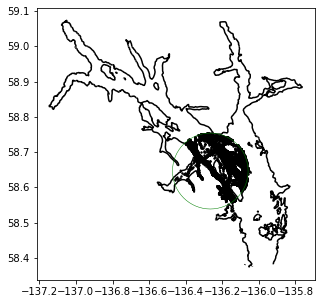

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 10 total events thus far
now processing MMSI: 244620447
	 15 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 38 total events thus far
now processing MMSI: 319139700
	 40 total events thus far
now processing MMSI: 319144200
	 43 total events thus far
now processing MMSI: 319147200
	 45 total events thus far
now processing MMSI: 319175300
	 46 total events thus far
now processing MMSI: 319264000
	 50 total events thus far
now processing MMSI: 319822000
	 55 total events thus far
now processing MMSI: 338043017
	 72 total events thus far
now processing MMSI: 338103017
	 75 total events thus far
now processing MMSI: 338103952
	 77 total events thus far
now processing MMSI: 338120189
	 90 total events thus far
now processing M

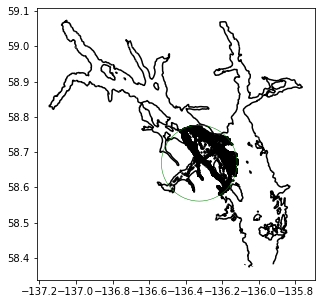

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 14 total events thus far
now processing MMSI: 316005813
	 19 total events thus far
now processing MMSI: 319009500
	 21 total events thus far
now processing MMSI: 319063600
	 36 total events thus far
now processing MMSI: 319139700
	 38 total events thus far
now processing MMSI: 319144200
	 40 total events thus far
now processing MMSI: 319147200
	 42 total events thus far
now processing MMSI: 319175300
	 44 total events thus far
now processing MMSI: 319264000
	 48 total events thus far
now processing MMSI: 319822000
	 52 total events thus far
now processing MMSI: 338043017
	 69 total events thus far
now processing MMSI: 338103017
	 72 total events thus far
now processing MMSI: 338120189
	 85 total events thus far
now processing MMSI: 338166495
	 86 total events thus far
now processing MM

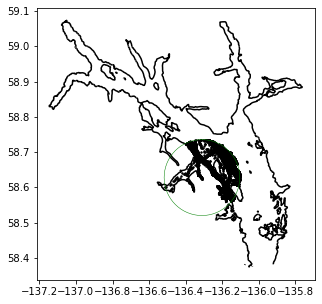

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 244620447
	 15 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 319009500
	 21 total events thus far
now processing MMSI: 319063600
	 35 total events thus far
now processing MMSI: 319139700
	 37 total events thus far
now processing MMSI: 319144200
	 38 total events thus far
now processing MMSI: 319147200
	 40 total events thus far
now processing MMSI: 319175300
	 41 total events thus far
now processing MMSI: 319264000
	 43 total events thus far
now processing MMSI: 319822000
	 45 total events thus far
now processing MMSI: 338043017
	 61 total events thus far
now processing MMSI: 338103017
	 63 total events thus far
now processing MMSI: 338103952
	 64 total events thus far
now processing MMSI: 338120189
	 77 total events thus far
now processing MM

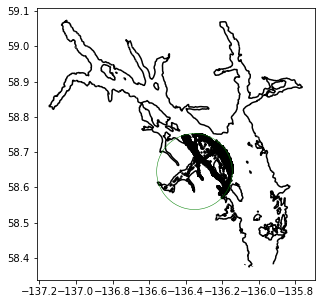

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 13 total events thus far
now processing MMSI: 316005813
	 18 total events thus far
now processing MMSI: 319009500
	 19 total events thus far
now processing MMSI: 319063600
	 33 total events thus far
now processing MMSI: 319139700
	 35 total events thus far
now processing MMSI: 319144200
	 36 total events thus far
now processing MMSI: 319147200
	 38 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 41 total events thus far
now processing MMSI: 319822000
	 43 total events thus far
now processing MMSI: 338043017
	 59 total events thus far
now processing MMSI: 338103017
	 61 total events thus far
now processing MMSI: 338120189
	 74 total events thus far
now processing MMSI: 338236805
	 77 total events thus far
now processing MM

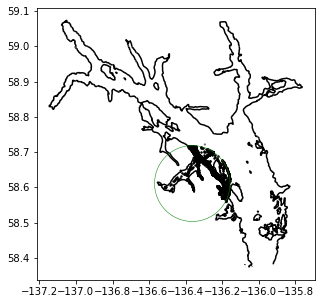

now processing MMSI: 244058902
	 4 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 14 total events thus far
now processing MMSI: 319063600
	 27 total events thus far
now processing MMSI: 319144200
	 28 total events thus far
now processing MMSI: 319264000
	 30 total events thus far
now processing MMSI: 319822000
	 32 total events thus far
now processing MMSI: 338043017
	 46 total events thus far
now processing MMSI: 338103017
	 48 total events thus far
now processing MMSI: 338120189
	 61 total events thus far
now processing MMSI: 338236805
	 63 total events thus far
now processing MMSI: 367122330
	 67 total events thus far
now processing MMSI: 367174080
	 71 total events thus far
now processing MMSI: 367450080
	 73 total events thus far
now processing MMSI: 367540650
	 90 total events thus far
now processing MMSI: 367564140
	 96 total events thus far
now processing MMSI: 367676610
	 107 total events thus far
now processing

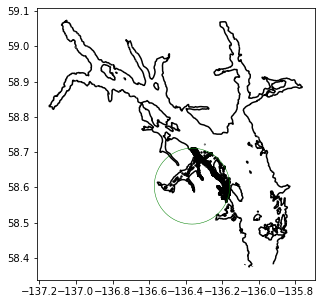

now processing MMSI: 244058902
	 3 total events thus far
now processing MMSI: 244620447
	 9 total events thus far
now processing MMSI: 316005813
	 12 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319144200
	 26 total events thus far
now processing MMSI: 319264000
	 28 total events thus far
now processing MMSI: 319822000
	 30 total events thus far
now processing MMSI: 338043017
	 44 total events thus far
now processing MMSI: 338103017
	 46 total events thus far
now processing MMSI: 338120189
	 59 total events thus far
now processing MMSI: 338236805
	 61 total events thus far
now processing MMSI: 367122330
	 65 total events thus far
now processing MMSI: 367174080
	 68 total events thus far
now processing MMSI: 367450080
	 70 total events thus far
now processing MMSI: 367540650
	 87 total events thus far
now processing MMSI: 367564140
	 93 total events thus far
now processing MMSI: 367676610
	 104 total events thus far
now processing 

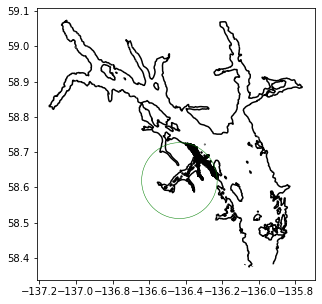

now processing MMSI: 244058902
	 1 total events thus far
now processing MMSI: 244620447
	 7 total events thus far
now processing MMSI: 316005813
	 9 total events thus far
now processing MMSI: 319063600
	 22 total events thus far
now processing MMSI: 319144200
	 23 total events thus far
now processing MMSI: 319264000
	 25 total events thus far
now processing MMSI: 319822000
	 27 total events thus far
now processing MMSI: 338043017
	 41 total events thus far
now processing MMSI: 338103017
	 43 total events thus far
now processing MMSI: 338236805
	 44 total events thus far
now processing MMSI: 367122330
	 48 total events thus far
now processing MMSI: 367174080
	 50 total events thus far
now processing MMSI: 367450080
	 52 total events thus far
now processing MMSI: 367540650
	 53 total events thus far
now processing MMSI: 367564140
	 59 total events thus far
now processing MMSI: 367676610
	 66 total events thus far
now processing MMSI: 368066070
	 68 total events thus far
now processing MM

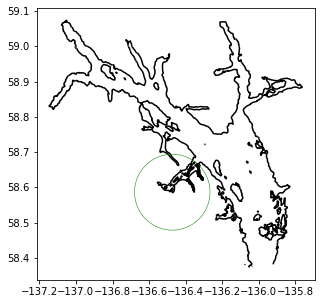

now processing MMSI: 244620447
	 3 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319822000
	 18 total events thus far
now processing MMSI: 338043017
	 29 total events thus far
now processing MMSI: 367122330
	 32 total events thus far
now processing MMSI: 367564140
	 38 total events thus far
now processing MMSI: 367676610
	 43 total events thus far
now processing MMSI: 368069540
	 48 total events thus far
now processing MMSI: 368089260
	 50 total events thus far
now processing MMSI: 368152380
	 56 total events thus far
now processing MMSI: 369970398
	 57 total events thus far
now processing MMSI: 538071405
	 77 total events thus far
Simulated event rate: 5.133333333333334
Now computing POINT (-136.531338510528 58.60185934328448)


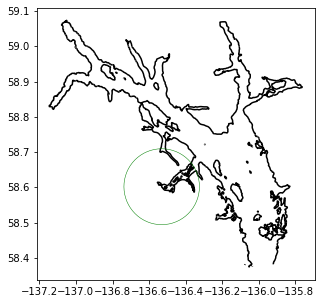

now processing MMSI: 244620447
	 3 total events thus far
now processing MMSI: 319063600
	 4 total events thus far
now processing MMSI: 368069540
	 7 total events thus far
now processing MMSI: 368152380
	 12 total events thus far
Simulated event rate: 2.0
Now computing POINT (-136.5164715121455 58.60862467089188)


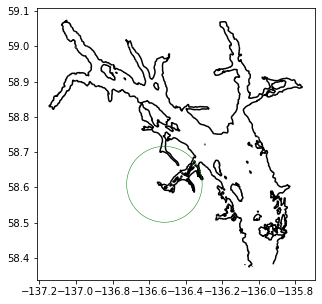

now processing MMSI: 244620447
	 3 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319822000
	 18 total events thus far
now processing MMSI: 338043017
	 29 total events thus far
now processing MMSI: 367564140
	 35 total events thus far
now processing MMSI: 367676610
	 39 total events thus far
now processing MMSI: 368069540
	 44 total events thus far
now processing MMSI: 368089260
	 45 total events thus far
now processing MMSI: 368152380
	 51 total events thus far
now processing MMSI: 369970398
	 52 total events thus far
now processing MMSI: 538071405
	 72 total events thus far
Simulated event rate: 5.142857142857143
Now computing POINT (-136.4589697785616 58.63128145475434)


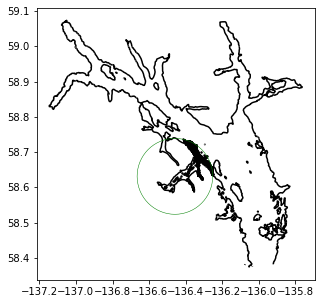

now processing MMSI: 244058902
	 1 total events thus far
now processing MMSI: 244620447
	 6 total events thus far
now processing MMSI: 316005813
	 8 total events thus far
now processing MMSI: 319063600
	 21 total events thus far
now processing MMSI: 319144200
	 22 total events thus far
now processing MMSI: 319264000
	 24 total events thus far
now processing MMSI: 319822000
	 26 total events thus far
now processing MMSI: 338043017
	 41 total events thus far
now processing MMSI: 338103017
	 43 total events thus far
now processing MMSI: 367122330
	 47 total events thus far
now processing MMSI: 367174080
	 49 total events thus far
now processing MMSI: 367450080
	 51 total events thus far
now processing MMSI: 367540650
	 52 total events thus far
now processing MMSI: 367564140
	 58 total events thus far
now processing MMSI: 367676610
	 65 total events thus far
now processing MMSI: 368066070
	 67 total events thus far
now processing MMSI: 368069540
	 72 total events thus far
now processing MM

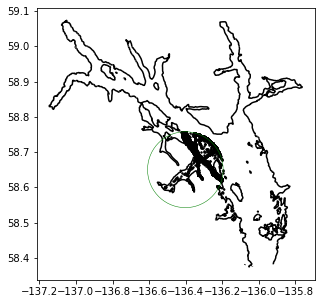

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 2 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 316005813
	 17 total events thus far
now processing MMSI: 319009500
	 18 total events thus far
now processing MMSI: 319063600
	 32 total events thus far
now processing MMSI: 319144200
	 33 total events thus far
now processing MMSI: 319147200
	 35 total events thus far
now processing MMSI: 319175300
	 36 total events thus far
now processing MMSI: 319264000
	 38 total events thus far
now processing MMSI: 319822000
	 40 total events thus far
now processing MMSI: 338043017
	 55 total events thus far
now processing MMSI: 338103017
	 57 total events thus far
now processing MMSI: 338120189
	 63 total events thus far
now processing MMSI: 338236805
	 66 total events thus far
now processing MMSI: 367122330
	 70 total events thus far
now processing MM

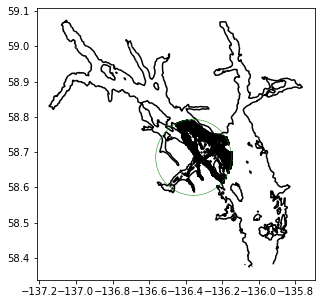

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 14 total events thus far
now processing MMSI: 316005813
	 19 total events thus far
now processing MMSI: 319009500
	 21 total events thus far
now processing MMSI: 319063600
	 36 total events thus far
now processing MMSI: 319139700
	 38 total events thus far
now processing MMSI: 319144200
	 40 total events thus far
now processing MMSI: 319147200
	 42 total events thus far
now processing MMSI: 319175300
	 44 total events thus far
now processing MMSI: 319264000
	 48 total events thus far
now processing MMSI: 319822000
	 52 total events thus far
now processing MMSI: 338043017
	 70 total events thus far
now processing MMSI: 338103017
	 73 total events thus far
now processing MMSI: 338120189
	 76 total events thus far
now processing MMSI: 338166495
	 77 total events thus far
now processing MM

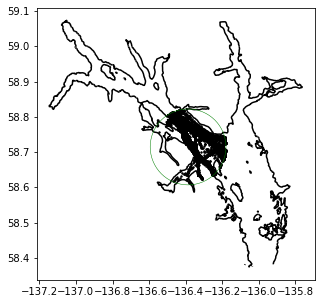

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 15 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 319009500
	 22 total events thus far
now processing MMSI: 319063600
	 37 total events thus far
now processing MMSI: 319139700
	 39 total events thus far
now processing MMSI: 319144200
	 56 total events thus far
now processing MMSI: 319147200
	 58 total events thus far
now processing MMSI: 319175300
	 60 total events thus far
now processing MMSI: 319264000
	 76 total events thus far
now processing MMSI: 319822000
	 79 total events thus far
now processing MMSI: 338043017
	 97 total events thus far
now processing MMSI: 338103017
	 101 total events thus far
now processing MMSI: 338103952
	 102 total events thus far
now processing MMSI: 338120189
	 106 total events thus far
now processing

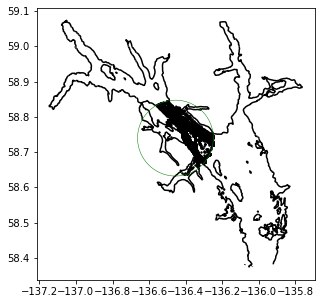

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 14 total events thus far
now processing MMSI: 316005813
	 17 total events thus far
now processing MMSI: 319009500
	 19 total events thus far
now processing MMSI: 319063600
	 23 total events thus far
now processing MMSI: 319139700
	 25 total events thus far
now processing MMSI: 319144200
	 42 total events thus far
now processing MMSI: 319147200
	 44 total events thus far
now processing MMSI: 319175300
	 46 total events thus far
now processing MMSI: 319264000
	 62 total events thus far
now processing MMSI: 319822000
	 63 total events thus far
now processing MMSI: 338043017
	 70 total events thus far
now processing MMSI: 338103017
	 73 total events thus far
now processing MMSI: 338103952
	 74 total events thus far
now processing MMSI: 338120189
	 80 total events thus far
now processing MM

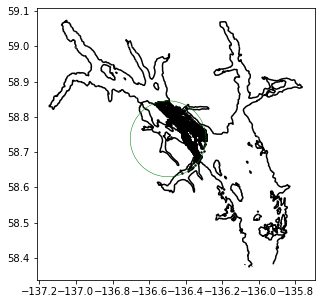

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 17 total events thus far
now processing MMSI: 319139700
	 19 total events thus far
now processing MMSI: 319144200
	 36 total events thus far
now processing MMSI: 319147200
	 38 total events thus far
now processing MMSI: 319175300
	 40 total events thus far
now processing MMSI: 319264000
	 56 total events thus far
now processing MMSI: 319822000
	 57 total events thus far
now processing MMSI: 338043017
	 61 total events thus far
now processing MMSI: 338103017
	 64 total events thus far
now processing MMSI: 338103952
	 65 total events thus far
now processing MMSI: 338120189
	 71 total events thus far
now processing MMSI: 338236805
	 72 total events thus far
now processing MM

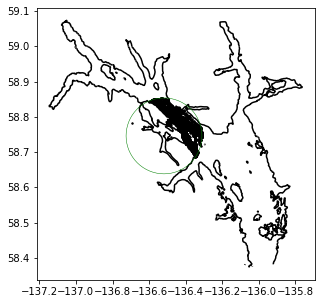

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 54 total events thus far
now processing MMSI: 338043017
	 57 total events thus far
now processing MMSI: 338103017
	 60 total events thus far
now processing MMSI: 338103952
	 61 total events thus far
now processing MMSI: 338120189
	 67 total events thus far
now processing MMSI: 338236805
	 68 total events thus far
now processing MMSI: 367122330
	 69 total events thus far
now processing MM

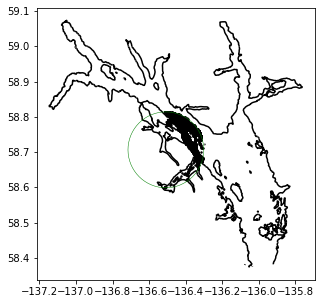

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 17 total events thus far
now processing MMSI: 319139700
	 19 total events thus far
now processing MMSI: 319144200
	 36 total events thus far
now processing MMSI: 319147200
	 38 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 55 total events thus far
now processing MMSI: 338043017
	 58 total events thus far
now processing MMSI: 338103017
	 61 total events thus far
now processing MMSI: 338103952
	 62 total events thus far
now processing MMSI: 338120189
	 66 total events thus far
now processing MMSI: 338236805
	 67 total events thus far
now processing MMSI: 367122330
	 68 total events thus far
now processing MM

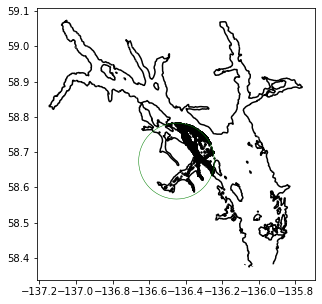

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 13 total events thus far
now processing MMSI: 316005813
	 18 total events thus far
now processing MMSI: 319009500
	 19 total events thus far
now processing MMSI: 319063600
	 33 total events thus far
now processing MMSI: 319139700
	 35 total events thus far
now processing MMSI: 319144200
	 52 total events thus far
now processing MMSI: 319147200
	 54 total events thus far
now processing MMSI: 319175300
	 55 total events thus far
now processing MMSI: 319264000
	 58 total events thus far
now processing MMSI: 319822000
	 60 total events thus far
now processing MMSI: 338043017
	 75 total events thus far
now processing MMSI: 338103017
	 78 total events thus far
now processing MMSI: 338103952
	 79 total events thus far
now processing MMSI: 338120189
	 82 total events thus far
now processing MM

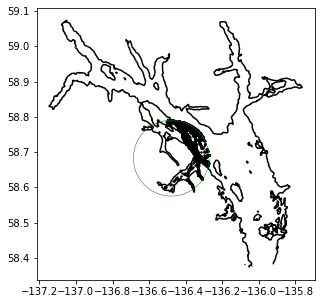

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 2 total events thus far
now processing MMSI: 244058902
	 4 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 316005813
	 14 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 29 total events thus far
now processing MMSI: 319139700
	 31 total events thus far
now processing MMSI: 319144200
	 48 total events thus far
now processing MMSI: 319147200
	 49 total events thus far
now processing MMSI: 319175300
	 50 total events thus far
now processing MMSI: 319264000
	 65 total events thus far
now processing MMSI: 319822000
	 67 total events thus far
now processing MMSI: 338043017
	 82 total events thus far
now processing MMSI: 338103017
	 85 total events thus far
now processing MMSI: 338103952
	 86 total events thus far
now processing MMSI: 338120189
	 89 total events thus far
now processing MM

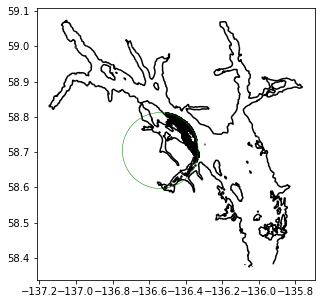

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 244058902
	 3 total events thus far
now processing MMSI: 244620447
	 9 total events thus far
now processing MMSI: 319009500
	 10 total events thus far
now processing MMSI: 319063600
	 13 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319264000
	 47 total events thus far
now processing MMSI: 338043017
	 49 total events thus far
now processing MMSI: 338103017
	 51 total events thus far
now processing MMSI: 338103952
	 52 total events thus far
now processing MMSI: 338120189
	 53 total events thus far
now processing MMSI: 338236805
	 54 total events thus far
now processing MMSI: 367122330
	 55 total events thus far
now processing MMSI: 367174080
	 58 total events thus far
now processing MMSI: 367450080
	 59 total events thus far
now processing MMSI: 367540650
	 61 total events thus far
now processing MM

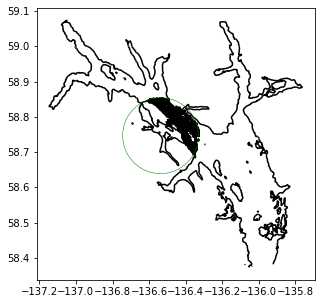

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 54 total events thus far
now processing MMSI: 338043017
	 56 total events thus far
now processing MMSI: 338103017
	 59 total events thus far
now processing MMSI: 338103952
	 60 total events thus far
now processing MMSI: 338120189
	 65 total events thus far
now processing MMSI: 338236805
	 66 total events thus far
now processing MMSI: 367122330
	 67 total events thus far
now processing MM

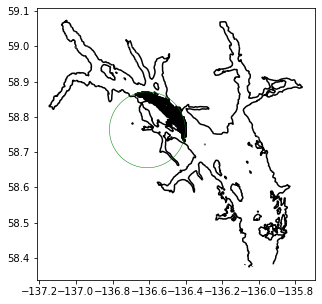

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 9 total events thus far
now processing MMSI: 319009500
	 11 total events thus far
now processing MMSI: 319063600
	 13 total events thus far
now processing MMSI: 319139700
	 15 total events thus far
now processing MMSI: 319144200
	 32 total events thus far
now processing MMSI: 319147200
	 34 total events thus far
now processing MMSI: 319175300
	 35 total events thus far
now processing MMSI: 319264000
	 52 total events thus far
now processing MMSI: 338043017
	 55 total events thus far
now processing MMSI: 338103017
	 58 total events thus far
now processing MMSI: 338103952
	 59 total events thus far
now processing MMSI: 338120189
	 63 total events thus far
now processing MMSI: 367122330
	 64 total events thus far
now processing MMSI: 367174080
	 67 total events thus far
now processing MMS

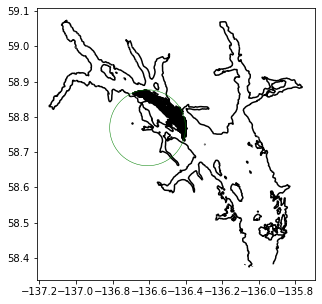

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 7 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319139700
	 18 total events thus far
now processing MMSI: 319144200
	 35 total events thus far
now processing MMSI: 319147200
	 37 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 55 total events thus far
now processing MMSI: 338043017
	 58 total events thus far
now processing MMSI: 338103017
	 61 total events thus far
now processing MMSI: 338103952
	 62 total events thus far
now processing MMSI: 338120189
	 67 total events thus far
now processing MMSI: 367122330
	 68 total events thus far
now processing MMSI: 367174080
	 71 total events thus far
now processing MM

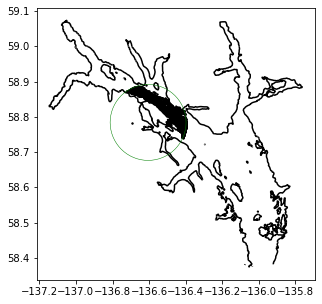

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 7 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 17 total events thus far
now processing MMSI: 319139700
	 19 total events thus far
now processing MMSI: 319144200
	 36 total events thus far
now processing MMSI: 319147200
	 38 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 56 total events thus far
now processing MMSI: 338043017
	 60 total events thus far
now processing MMSI: 338103017
	 62 total events thus far
now processing MMSI: 338103952
	 64 total events thus far
now processing MMSI: 338120189
	 69 total events thus far
now processing MMSI: 367122330
	 70 total events thus far
now processing MMSI: 367174080
	 75 total events thus far
now processing MM

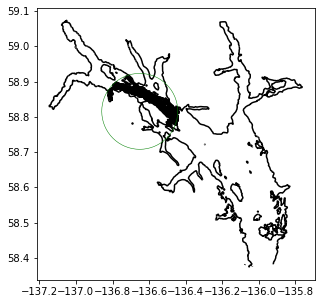

now processing MMSI: 235066752
	 7 total events thus far
now processing MMSI: 235088016
	 10 total events thus far
now processing MMSI: 244620447
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 34 total events thus far
now processing MMSI: 319139700
	 36 total events thus far
now processing MMSI: 319144200
	 53 total events thus far
now processing MMSI: 319147200
	 55 total events thus far
now processing MMSI: 319175300
	 56 total events thus far
now processing MMSI: 319264000
	 75 total events thus far
now processing MMSI: 338043017
	 81 total events thus far
now processing MMSI: 338103017
	 84 total events thus far
now processing MMSI: 338103952
	 86 total events thus far
now processing MMSI: 338120189
	 90 total events thus far
now processing MMSI: 367122330
	 92 total events thus far
now processing MMSI: 367174080
	 98 total events thus far
now processing MMSI: 367450080
	 100 total events thus far
now processing

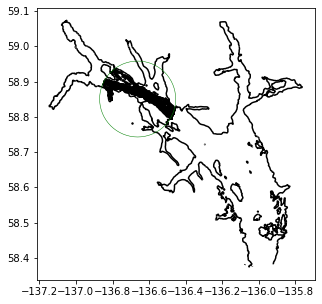

now processing MMSI: 235066752
	 8 total events thus far
now processing MMSI: 235088016
	 11 total events thus far
now processing MMSI: 244620447
	 14 total events thus far
now processing MMSI: 319009500
	 17 total events thus far
now processing MMSI: 319063600
	 37 total events thus far
now processing MMSI: 319139700
	 39 total events thus far
now processing MMSI: 319144200
	 41 total events thus far
now processing MMSI: 319147200
	 43 total events thus far
now processing MMSI: 319175300
	 45 total events thus far
now processing MMSI: 319264000
	 54 total events thus far
now processing MMSI: 319822000
	 55 total events thus far
now processing MMSI: 338043017
	 61 total events thus far
now processing MMSI: 338103017
	 63 total events thus far
now processing MMSI: 338103952
	 64 total events thus far
now processing MMSI: 338120189
	 68 total events thus far
now processing MMSI: 367122330
	 70 total events thus far
now processing MMSI: 367174080
	 75 total events thus far
now processing 

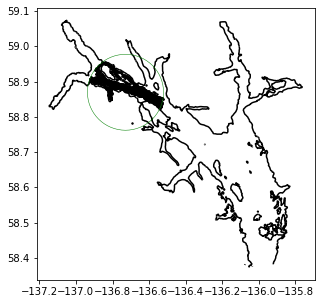

now processing MMSI: 235066752
	 8 total events thus far
now processing MMSI: 235088016
	 29 total events thus far
now processing MMSI: 244620447
	 32 total events thus far
now processing MMSI: 319009500
	 36 total events thus far
now processing MMSI: 319063600
	 56 total events thus far
now processing MMSI: 319139700
	 58 total events thus far
now processing MMSI: 319144200
	 60 total events thus far
now processing MMSI: 319147200
	 63 total events thus far
now processing MMSI: 319175300
	 65 total events thus far
now processing MMSI: 319264000
	 74 total events thus far
now processing MMSI: 319822000
	 76 total events thus far
now processing MMSI: 338043017
	 82 total events thus far
now processing MMSI: 338103017
	 84 total events thus far
now processing MMSI: 338103952
	 85 total events thus far
now processing MMSI: 338120189
	 89 total events thus far
now processing MMSI: 338236805
	 90 total events thus far
now processing MMSI: 367122330
	 92 total events thus far
now processing 

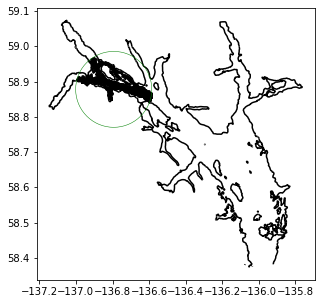

now processing MMSI: 235066752
	 9 total events thus far
now processing MMSI: 235088016
	 30 total events thus far
now processing MMSI: 244620447
	 33 total events thus far
now processing MMSI: 319009500
	 37 total events thus far
now processing MMSI: 319063600
	 58 total events thus far
now processing MMSI: 319139700
	 98 total events thus far
now processing MMSI: 319144200
	 100 total events thus far
now processing MMSI: 319147200
	 130 total events thus far
now processing MMSI: 319175300
	 131 total events thus far
now processing MMSI: 319264000
	 143 total events thus far
now processing MMSI: 319822000
	 145 total events thus far
now processing MMSI: 338043017
	 152 total events thus far
now processing MMSI: 338103017
	 154 total events thus far
now processing MMSI: 338103952
	 155 total events thus far
now processing MMSI: 338120189
	 158 total events thus far
now processing MMSI: 338236805
	 159 total events thus far
now processing MMSI: 367122330
	 162 total events thus far
now 

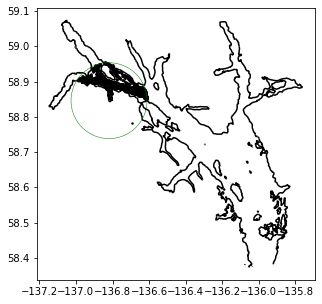

now processing MMSI: 235066752
	 8 total events thus far
now processing MMSI: 235088016
	 29 total events thus far
now processing MMSI: 244620447
	 32 total events thus far
now processing MMSI: 319009500
	 36 total events thus far
now processing MMSI: 319063600
	 56 total events thus far
now processing MMSI: 319139700
	 95 total events thus far
now processing MMSI: 319144200
	 97 total events thus far
now processing MMSI: 319147200
	 101 total events thus far
now processing MMSI: 319175300
	 102 total events thus far
now processing MMSI: 319264000
	 114 total events thus far
now processing MMSI: 319822000
	 116 total events thus far
now processing MMSI: 338043017
	 123 total events thus far
now processing MMSI: 338103017
	 125 total events thus far
now processing MMSI: 338103952
	 126 total events thus far
now processing MMSI: 338120189
	 129 total events thus far
now processing MMSI: 338236805
	 130 total events thus far
now processing MMSI: 367122330
	 133 total events thus far
now p

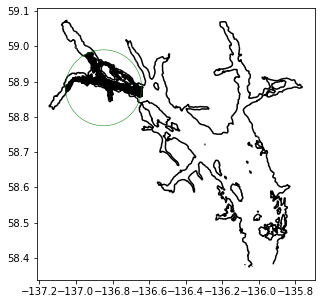

now processing MMSI: 235066752
	 7 total events thus far
now processing MMSI: 235088016
	 28 total events thus far
now processing MMSI: 244620447
	 31 total events thus far
now processing MMSI: 319009500
	 36 total events thus far
now processing MMSI: 319063600
	 58 total events thus far
now processing MMSI: 319139700
	 98 total events thus far
now processing MMSI: 319144200
	 100 total events thus far
now processing MMSI: 319147200
	 130 total events thus far
now processing MMSI: 319175300
	 132 total events thus far
now processing MMSI: 319264000
	 146 total events thus far
now processing MMSI: 319822000
	 148 total events thus far
now processing MMSI: 338043017
	 155 total events thus far
now processing MMSI: 338103017
	 157 total events thus far
now processing MMSI: 338103952
	 158 total events thus far
now processing MMSI: 338120189
	 161 total events thus far
now processing MMSI: 338236805
	 162 total events thus far
now processing MMSI: 367122330
	 165 total events thus far
now 

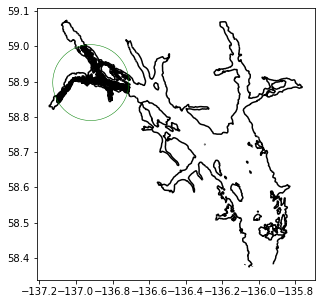

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 26 total events thus far
now processing MMSI: 244620447
	 27 total events thus far
now processing MMSI: 319009500
	 31 total events thus far
now processing MMSI: 319063600
	 53 total events thus far
now processing MMSI: 319139700
	 93 total events thus far
now processing MMSI: 319144200
	 95 total events thus far
now processing MMSI: 319147200
	 125 total events thus far
now processing MMSI: 319175300
	 128 total events thus far
now processing MMSI: 319264000
	 152 total events thus far
now processing MMSI: 319822000
	 155 total events thus far
now processing MMSI: 338043017
	 161 total events thus far
now processing MMSI: 338103017
	 164 total events thus far
now processing MMSI: 338120189
	 166 total events thus far
now processing MMSI: 338236805
	 168 total events thus far
now processing MMSI: 367122330
	 171 total events thus far
now processing MMSI: 367174080
	 177 total events thus far
now p

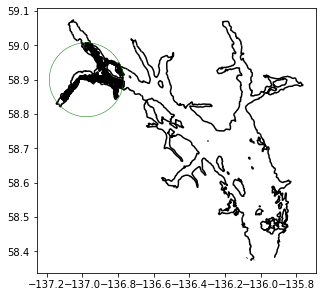

now processing MMSI: 235066752
	 4 total events thus far
now processing MMSI: 235088016
	 25 total events thus far
now processing MMSI: 244620447
	 26 total events thus far
now processing MMSI: 319009500
	 30 total events thus far
now processing MMSI: 319063600
	 52 total events thus far
now processing MMSI: 319139700
	 92 total events thus far
now processing MMSI: 319144200
	 94 total events thus far
now processing MMSI: 319147200
	 122 total events thus far
now processing MMSI: 319175300
	 125 total events thus far
now processing MMSI: 319264000
	 150 total events thus far
now processing MMSI: 319822000
	 152 total events thus far
now processing MMSI: 338043017
	 157 total events thus far
now processing MMSI: 338103017
	 159 total events thus far
now processing MMSI: 338120189
	 161 total events thus far
now processing MMSI: 338236805
	 163 total events thus far
now processing MMSI: 367122330
	 166 total events thus far
now processing MMSI: 367174080
	 171 total events thus far
now p

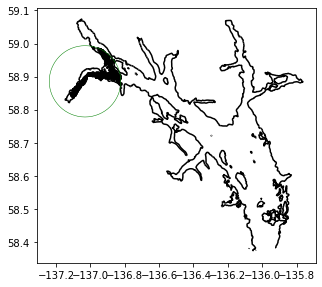

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 22 total events thus far
now processing MMSI: 244620447
	 23 total events thus far
now processing MMSI: 319009500
	 26 total events thus far
now processing MMSI: 319063600
	 31 total events thus far
now processing MMSI: 319139700
	 71 total events thus far
now processing MMSI: 319144200
	 73 total events thus far
now processing MMSI: 319147200
	 75 total events thus far
now processing MMSI: 319175300
	 77 total events thus far
now processing MMSI: 319264000
	 100 total events thus far
now processing MMSI: 338043017
	 104 total events thus far
now processing MMSI: 338103017
	 105 total events thus far
now processing MMSI: 338120189
	 107 total events thus far
now processing MMSI: 338236805
	 108 total events thus far
now processing MMSI: 367122330
	 109 total events thus far
now processing MMSI: 367174080
	 112 total events thus far
now processing MMSI: 367450080
	 115 total events thus far
now pro

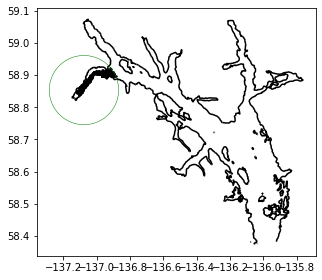

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 319009500
	 7 total events thus far
now processing MMSI: 319063600
	 9 total events thus far
now processing MMSI: 319175300
	 11 total events thus far
now processing MMSI: 319264000
	 29 total events thus far
now processing MMSI: 338043017
	 33 total events thus far
now processing MMSI: 338103017
	 34 total events thus far
now processing MMSI: 367122330
	 35 total events thus far
now processing MMSI: 367174080
	 38 total events thus far
now processing MMSI: 367450080
	 40 total events thus far
now processing MMSI: 367540650
	 42 total events thus far
now processing MMSI: 367564140
	 45 total events thus far
now processing MMSI: 367580440
	 46 total events thus far
now processing MMSI: 368066070
	 48 total events thus far
now processing MMSI: 368069540
	 55 total events thus far
now processing MMSI: 368087940
	 59 total events thus far
now processing MMS

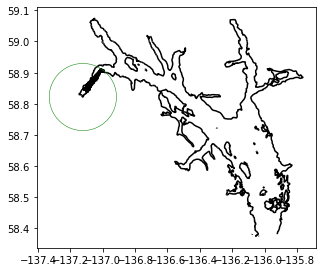

now processing MMSI: 235088016
	 1 total events thus far
now processing MMSI: 319009500
	 3 total events thus far
now processing MMSI: 319063600
	 4 total events thus far
now processing MMSI: 319175300
	 6 total events thus far
now processing MMSI: 319264000
	 21 total events thus far
now processing MMSI: 338043017
	 22 total events thus far
now processing MMSI: 367174080
	 23 total events thus far
now processing MMSI: 367450080
	 24 total events thus far
now processing MMSI: 367540650
	 25 total events thus far
now processing MMSI: 367564140
	 27 total events thus far
now processing MMSI: 368066070
	 28 total events thus far
now processing MMSI: 368069540
	 35 total events thus far
now processing MMSI: 368087940
	 37 total events thus far
now processing MMSI: 368089270
	 40 total events thus far
now processing MMSI: 368152380
	 41 total events thus far
now processing MMSI: 369150000
	 44 total events thus far
now processing MMSI: 369970398
	 46 total events thus far
now processing MMS

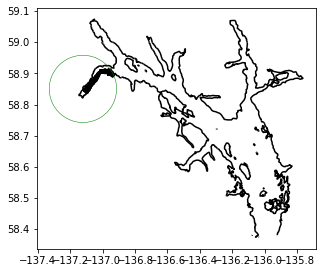

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 2 total events thus far
now processing MMSI: 319009500
	 5 total events thus far
now processing MMSI: 319063600
	 7 total events thus far
now processing MMSI: 319175300
	 9 total events thus far
now processing MMSI: 319264000
	 25 total events thus far
now processing MMSI: 338043017
	 29 total events thus far
now processing MMSI: 367122330
	 30 total events thus far
now processing MMSI: 367174080
	 33 total events thus far
now processing MMSI: 367450080
	 34 total events thus far
now processing MMSI: 367540650
	 36 total events thus far
now processing MMSI: 367564140
	 39 total events thus far
now processing MMSI: 368066070
	 40 total events thus far
now processing MMSI: 368069540
	 47 total events thus far
now processing MMSI: 368087940
	 50 total events thus far
now processing MMSI: 368089270
	 53 total events thus far
now processing MMSI: 368152380
	 54 total events thus far
now processing MMSI

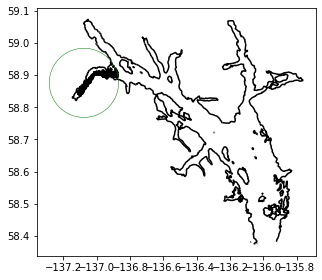

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 319009500
	 7 total events thus far
now processing MMSI: 319063600
	 9 total events thus far
now processing MMSI: 319175300
	 11 total events thus far
now processing MMSI: 319264000
	 30 total events thus far
now processing MMSI: 338043017
	 34 total events thus far
now processing MMSI: 338103017
	 35 total events thus far
now processing MMSI: 367122330
	 36 total events thus far
now processing MMSI: 367174080
	 39 total events thus far
now processing MMSI: 367450080
	 41 total events thus far
now processing MMSI: 367540650
	 43 total events thus far
now processing MMSI: 367564140
	 46 total events thus far
now processing MMSI: 367580440
	 47 total events thus far
now processing MMSI: 368066070
	 49 total events thus far
now processing MMSI: 368069540
	 56 total events thus far
now processing MMSI: 368087940
	 60 total events thus far
now processing MMS

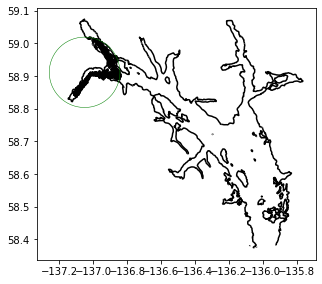

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 21 total events thus far
now processing MMSI: 244620447
	 22 total events thus far
now processing MMSI: 319009500
	 25 total events thus far
now processing MMSI: 319063600
	 30 total events thus far
now processing MMSI: 319139700
	 70 total events thus far
now processing MMSI: 319144200
	 72 total events thus far
now processing MMSI: 319147200
	 100 total events thus far
now processing MMSI: 319175300
	 102 total events thus far
now processing MMSI: 319264000
	 124 total events thus far
now processing MMSI: 319822000
	 125 total events thus far
now processing MMSI: 338043017
	 129 total events thus far
now processing MMSI: 338103017
	 131 total events thus far
now processing MMSI: 338120189
	 133 total events thus far
now processing MMSI: 338236805
	 134 total events thus far
now processing MMSI: 367122330
	 135 total events thus far
now processing MMSI: 367174080
	 138 total events thus far
now p

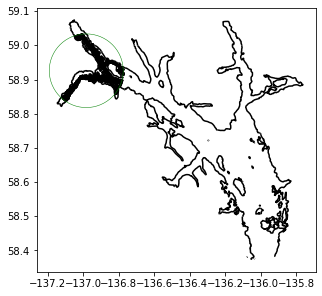

now processing MMSI: 235066752
	 4 total events thus far
now processing MMSI: 235088016
	 25 total events thus far
now processing MMSI: 244620447
	 26 total events thus far
now processing MMSI: 319009500
	 30 total events thus far
now processing MMSI: 319063600
	 36 total events thus far
now processing MMSI: 319139700
	 75 total events thus far
now processing MMSI: 319144200
	 77 total events thus far
now processing MMSI: 319147200
	 105 total events thus far
now processing MMSI: 319175300
	 108 total events thus far
now processing MMSI: 319264000
	 133 total events thus far
now processing MMSI: 319822000
	 135 total events thus far
now processing MMSI: 338043017
	 140 total events thus far
now processing MMSI: 338103017
	 142 total events thus far
now processing MMSI: 338120189
	 144 total events thus far
now processing MMSI: 338236805
	 146 total events thus far
now processing MMSI: 367122330
	 148 total events thus far
now processing MMSI: 367174080
	 153 total events thus far
now p

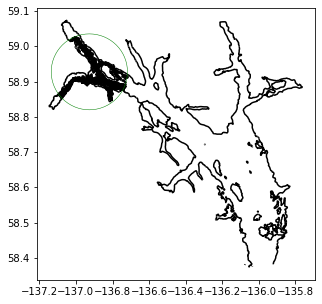

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 26 total events thus far
now processing MMSI: 244620447
	 27 total events thus far
now processing MMSI: 319009500
	 31 total events thus far
now processing MMSI: 319063600
	 54 total events thus far
now processing MMSI: 319139700
	 94 total events thus far
now processing MMSI: 319144200
	 96 total events thus far
now processing MMSI: 319147200
	 125 total events thus far
now processing MMSI: 319175300
	 128 total events thus far
now processing MMSI: 319264000
	 152 total events thus far
now processing MMSI: 319822000
	 155 total events thus far
now processing MMSI: 338043017
	 161 total events thus far
now processing MMSI: 338103017
	 163 total events thus far
now processing MMSI: 338120189
	 165 total events thus far
now processing MMSI: 338236805
	 167 total events thus far
now processing MMSI: 367122330
	 170 total events thus far
now processing MMSI: 367174080
	 176 total events thus far
now p

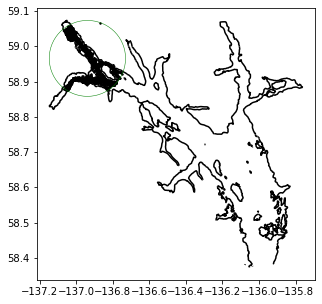

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 22 total events thus far
now processing MMSI: 244620447
	 23 total events thus far
now processing MMSI: 319009500
	 27 total events thus far
now processing MMSI: 319063600
	 33 total events thus far
now processing MMSI: 319139700
	 72 total events thus far
now processing MMSI: 319144200
	 77 total events thus far
now processing MMSI: 319147200
	 105 total events thus far
now processing MMSI: 319175300
	 108 total events thus far
now processing MMSI: 319264000
	 122 total events thus far
now processing MMSI: 319822000
	 126 total events thus far
now processing MMSI: 338043017
	 130 total events thus far
now processing MMSI: 338103017
	 132 total events thus far
now processing MMSI: 338120189
	 134 total events thus far
now processing MMSI: 338236805
	 136 total events thus far
now processing MMSI: 367122330
	 137 total events thus far
now processing MMSI: 367174080
	 140 total events thus far
now p

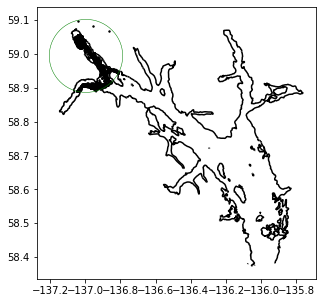

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 21 total events thus far
now processing MMSI: 244620447
	 22 total events thus far
now processing MMSI: 319009500
	 25 total events thus far
now processing MMSI: 319063600
	 31 total events thus far
now processing MMSI: 319139700
	 70 total events thus far
now processing MMSI: 319144200
	 75 total events thus far
now processing MMSI: 319147200
	 103 total events thus far
now processing MMSI: 319175300
	 105 total events thus far
now processing MMSI: 319264000
	 116 total events thus far
now processing MMSI: 319822000
	 118 total events thus far
now processing MMSI: 338043017
	 121 total events thus far
now processing MMSI: 338103017
	 123 total events thus far
now processing MMSI: 338236805
	 125 total events thus far
now processing MMSI: 367122330
	 126 total events thus far
now processing MMSI: 367174080
	 128 total events thus far
now processing MMSI: 367450080
	 131 total events thus far
now p

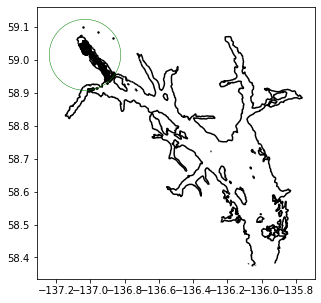

now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 319009500
	 5 total events thus far
now processing MMSI: 319063600
	 9 total events thus far
now processing MMSI: 319139700
	 48 total events thus far
now processing MMSI: 319144200
	 53 total events thus far
now processing MMSI: 319147200
	 81 total events thus far
now processing MMSI: 319175300
	 82 total events thus far
now processing MMSI: 319264000
	 88 total events thus far
now processing MMSI: 319822000
	 90 total events thus far
now processing MMSI: 338103017
	 91 total events thus far
now processing MMSI: 338236805
	 92 total events thus far
now processing MMSI: 367450080
	 93 total events thus far
now processing MMSI: 367540650
	 94 total events thus far
now processing MMSI: 367564140
	 99 total events thus far
now processing MMSI: 367624970
	 100 total events thus far
now processing MMSI: 368066070
	 103 total events thus far
now processing MMSI: 368069540
	 110 total events thus far
now processing

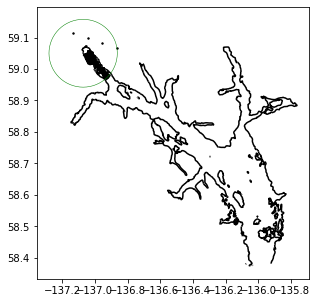

now processing MMSI: 319063600
	 3 total events thus far
now processing MMSI: 319139700
	 4 total events thus far
now processing MMSI: 319144200
	 9 total events thus far
now processing MMSI: 319175300
	 10 total events thus far
now processing MMSI: 319264000
	 13 total events thus far
now processing MMSI: 319822000
	 15 total events thus far
now processing MMSI: 338103017
	 16 total events thus far
now processing MMSI: 338236805
	 17 total events thus far
now processing MMSI: 367450080
	 18 total events thus far
now processing MMSI: 367540650
	 19 total events thus far
now processing MMSI: 367564140
	 22 total events thus far
now processing MMSI: 367624970
	 23 total events thus far
now processing MMSI: 368066070
	 25 total events thus far
now processing MMSI: 368069540
	 32 total events thus far
now processing MMSI: 368087940
	 34 total events thus far
now processing MMSI: 368089270
	 35 total events thus far
now processing MMSI: 369960000
	 39 total events thus far
now processing MM

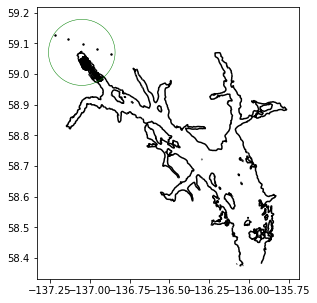

now processing MMSI: 319063600
	 3 total events thus far
now processing MMSI: 319139700
	 4 total events thus far
now processing MMSI: 319144200
	 9 total events thus far
now processing MMSI: 319175300
	 10 total events thus far
now processing MMSI: 319264000
	 13 total events thus far
now processing MMSI: 319822000
	 15 total events thus far
now processing MMSI: 338103017
	 16 total events thus far
now processing MMSI: 338236805
	 17 total events thus far
now processing MMSI: 367450080
	 18 total events thus far
now processing MMSI: 367540650
	 19 total events thus far
now processing MMSI: 367564140
	 22 total events thus far
now processing MMSI: 367624970
	 23 total events thus far
now processing MMSI: 368066070
	 25 total events thus far
now processing MMSI: 368069540
	 32 total events thus far
now processing MMSI: 368087940
	 34 total events thus far
now processing MMSI: 369960000
	 38 total events thus far
now processing MMSI: 369960003
	 42 total events thus far
now processing MM

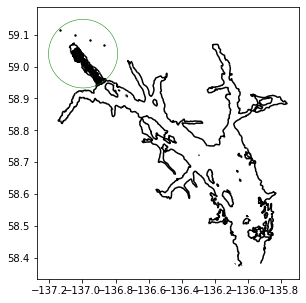

now processing MMSI: 319063600
	 3 total events thus far
now processing MMSI: 319139700
	 4 total events thus far
now processing MMSI: 319144200
	 9 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 42 total events thus far
now processing MMSI: 338103017
	 43 total events thus far
now processing MMSI: 338236805
	 44 total events thus far
now processing MMSI: 367450080
	 45 total events thus far
now processing MMSI: 367540650
	 46 total events thus far
now processing MMSI: 367564140
	 49 total events thus far
now processing MMSI: 367624970
	 50 total events thus far
now processing MMSI: 368066070
	 53 total events thus far
now processing MMSI: 368069540
	 60 total events thus far
now processing MMSI: 368087940
	 62 total events thus far
now processing MMSI: 368089270
	 63 total events thus far
now processing MM

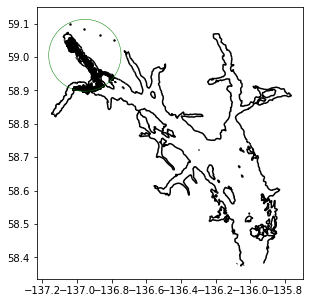

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 21 total events thus far
now processing MMSI: 244620447
	 22 total events thus far
now processing MMSI: 319009500
	 24 total events thus far
now processing MMSI: 319063600
	 30 total events thus far
now processing MMSI: 319139700
	 69 total events thus far
now processing MMSI: 319144200
	 74 total events thus far
now processing MMSI: 319147200
	 102 total events thus far
now processing MMSI: 319175300
	 103 total events thus far
now processing MMSI: 319264000
	 114 total events thus far
now processing MMSI: 319822000
	 117 total events thus far
now processing MMSI: 338043017
	 119 total events thus far
now processing MMSI: 338103017
	 121 total events thus far
now processing MMSI: 338236805
	 123 total events thus far
now processing MMSI: 367122330
	 124 total events thus far
now processing MMSI: 367174080
	 127 total events thus far
now processing MMSI: 367450080
	 130 total events thus far
now p

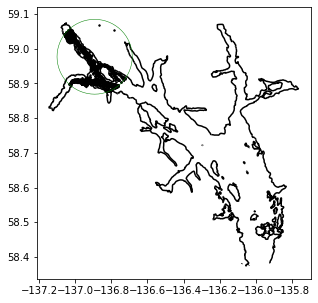

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 23 total events thus far
now processing MMSI: 244620447
	 24 total events thus far
now processing MMSI: 319009500
	 27 total events thus far
now processing MMSI: 319063600
	 33 total events thus far
now processing MMSI: 319139700
	 72 total events thus far
now processing MMSI: 319144200
	 77 total events thus far
now processing MMSI: 319147200
	 105 total events thus far
now processing MMSI: 319175300
	 108 total events thus far
now processing MMSI: 319264000
	 122 total events thus far
now processing MMSI: 319822000
	 126 total events thus far
now processing MMSI: 338043017
	 130 total events thus far
now processing MMSI: 338103017
	 132 total events thus far
now processing MMSI: 338120189
	 134 total events thus far
now processing MMSI: 338236805
	 136 total events thus far
now processing MMSI: 367122330
	 137 total events thus far
now processing MMSI: 367174080
	 141 total events thus far
now p

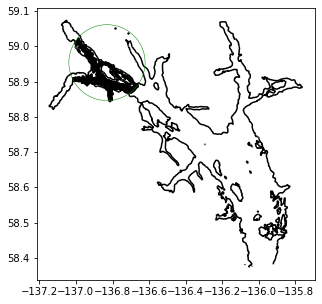

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 26 total events thus far
now processing MMSI: 244620447
	 28 total events thus far
now processing MMSI: 319009500
	 31 total events thus far
now processing MMSI: 319063600
	 53 total events thus far
now processing MMSI: 319139700
	 93 total events thus far
now processing MMSI: 319144200
	 95 total events thus far
now processing MMSI: 319147200
	 125 total events thus far
now processing MMSI: 319175300
	 126 total events thus far
now processing MMSI: 319264000
	 141 total events thus far
now processing MMSI: 319822000
	 144 total events thus far
now processing MMSI: 338043017
	 149 total events thus far
now processing MMSI: 338103017
	 152 total events thus far
now processing MMSI: 338120189
	 155 total events thus far
now processing MMSI: 338236805
	 157 total events thus far
now processing MMSI: 367122330
	 160 total events thus far
now processing MMSI: 367174080
	 165 total events thus far
now p

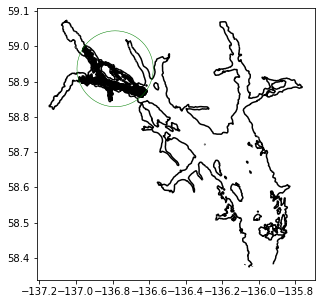

now processing MMSI: 235066752
	 7 total events thus far
now processing MMSI: 235088016
	 28 total events thus far
now processing MMSI: 244620447
	 31 total events thus far
now processing MMSI: 319009500
	 35 total events thus far
now processing MMSI: 319063600
	 57 total events thus far
now processing MMSI: 319139700
	 97 total events thus far
now processing MMSI: 319144200
	 99 total events thus far
now processing MMSI: 319147200
	 129 total events thus far
now processing MMSI: 319175300
	 130 total events thus far
now processing MMSI: 319264000
	 143 total events thus far
now processing MMSI: 319822000
	 146 total events thus far
now processing MMSI: 338043017
	 153 total events thus far
now processing MMSI: 338103017
	 156 total events thus far
now processing MMSI: 338103952
	 157 total events thus far
now processing MMSI: 338120189
	 160 total events thus far
now processing MMSI: 338236805
	 162 total events thus far
now processing MMSI: 367122330
	 165 total events thus far
now p

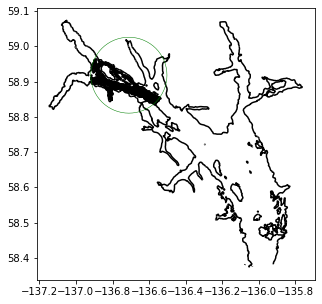

now processing MMSI: 235066752
	 8 total events thus far
now processing MMSI: 235088016
	 29 total events thus far
now processing MMSI: 244620447
	 32 total events thus far
now processing MMSI: 319009500
	 36 total events thus far
now processing MMSI: 319063600
	 56 total events thus far
now processing MMSI: 319139700
	 96 total events thus far
now processing MMSI: 319144200
	 98 total events thus far
now processing MMSI: 319147200
	 128 total events thus far
now processing MMSI: 319175300
	 129 total events thus far
now processing MMSI: 319264000
	 139 total events thus far
now processing MMSI: 319822000
	 141 total events thus far
now processing MMSI: 338043017
	 146 total events thus far
now processing MMSI: 338103017
	 148 total events thus far
now processing MMSI: 338103952
	 149 total events thus far
now processing MMSI: 338120189
	 152 total events thus far
now processing MMSI: 338236805
	 153 total events thus far
now processing MMSI: 367122330
	 155 total events thus far
now p

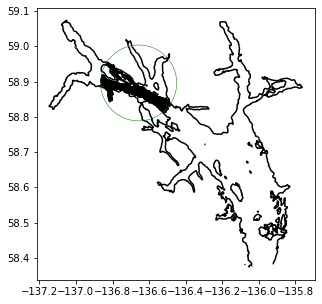

now processing MMSI: 235066752
	 7 total events thus far
now processing MMSI: 235088016
	 10 total events thus far
now processing MMSI: 244620447
	 13 total events thus far
now processing MMSI: 319009500
	 16 total events thus far
now processing MMSI: 319063600
	 36 total events thus far
now processing MMSI: 319139700
	 38 total events thus far
now processing MMSI: 319144200
	 40 total events thus far
now processing MMSI: 319147200
	 43 total events thus far
now processing MMSI: 319175300
	 45 total events thus far
now processing MMSI: 319264000
	 53 total events thus far
now processing MMSI: 319822000
	 55 total events thus far
now processing MMSI: 338043017
	 61 total events thus far
now processing MMSI: 338103017
	 62 total events thus far
now processing MMSI: 338103952
	 63 total events thus far
now processing MMSI: 338120189
	 66 total events thus far
now processing MMSI: 338236805
	 67 total events thus far
now processing MMSI: 367122330
	 69 total events thus far
now processing 

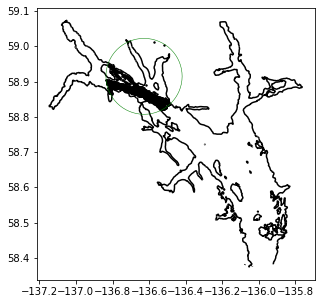

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319139700
	 18 total events thus far
now processing MMSI: 319144200
	 20 total events thus far
now processing MMSI: 319147200
	 22 total events thus far
now processing MMSI: 319175300
	 24 total events thus far
now processing MMSI: 319264000
	 31 total events thus far
now processing MMSI: 319822000
	 33 total events thus far
now processing MMSI: 338043017
	 39 total events thus far
now processing MMSI: 338103017
	 40 total events thus far
now processing MMSI: 338103952
	 41 total events thus far
now processing MMSI: 338120189
	 43 total events thus far
now processing MMSI: 338236805
	 44 total events thus far
now processing MMSI: 367174080
	 49 total events thus far
now processing M

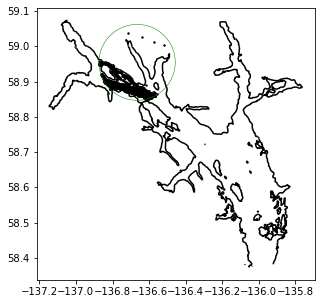

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 24 total events thus far
now processing MMSI: 244620447
	 27 total events thus far
now processing MMSI: 319009500
	 30 total events thus far
now processing MMSI: 319063600
	 32 total events thus far
now processing MMSI: 319139700
	 73 total events thus far
now processing MMSI: 319144200
	 75 total events thus far
now processing MMSI: 319147200
	 106 total events thus far
now processing MMSI: 319175300
	 107 total events thus far
now processing MMSI: 319264000
	 113 total events thus far
now processing MMSI: 319822000
	 115 total events thus far
now processing MMSI: 338043017
	 119 total events thus far
now processing MMSI: 338103017
	 120 total events thus far
now processing MMSI: 338103952
	 121 total events thus far
now processing MMSI: 338120189
	 122 total events thus far
now processing MMSI: 338236805
	 123 total events thus far
now processing MMSI: 367174080
	 127 total events thus far
now p

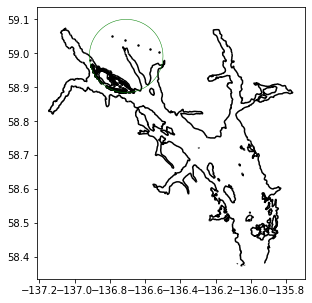

now processing MMSI: 235088016
	 19 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 319063600
	 22 total events thus far
now processing MMSI: 319139700
	 63 total events thus far
now processing MMSI: 319144200
	 65 total events thus far
now processing MMSI: 319147200
	 94 total events thus far
now processing MMSI: 319175300
	 95 total events thus far
now processing MMSI: 319264000
	 97 total events thus far
now processing MMSI: 319822000
	 99 total events thus far
now processing MMSI: 338236805
	 100 total events thus far
now processing MMSI: 367174080
	 102 total events thus far
now processing MMSI: 367540650
	 104 total events thus far
now processing MMSI: 367564140
	 127 total events thus far
now processing MMSI: 367624970
	 128 total events thus far
now processing MMSI: 368066070
	 130 total events thus far
now processing MMSI: 368069540
	 131 total events thus far
now processing MMSI: 368087940
	 132 total events thus far
now pr

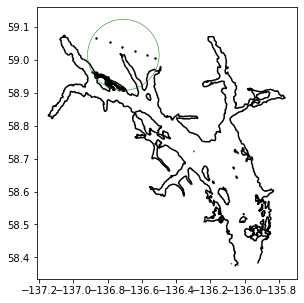

now processing MMSI: 235088016
	 15 total events thus far
now processing MMSI: 319139700
	 54 total events thus far
now processing MMSI: 319147200
	 82 total events thus far
now processing MMSI: 319175300
	 83 total events thus far
now processing MMSI: 319822000
	 85 total events thus far
now processing MMSI: 338236805
	 86 total events thus far
now processing MMSI: 367174080
	 88 total events thus far
now processing MMSI: 367540650
	 89 total events thus far
now processing MMSI: 367564140
	 110 total events thus far
now processing MMSI: 367624970
	 111 total events thus far
now processing MMSI: 368066070
	 113 total events thus far
now processing MMSI: 368087940
	 114 total events thus far
now processing MMSI: 369970398
	 117 total events thus far
now processing MMSI: 538071368
	 119 total events thus far
now processing MMSI: 538071405
	 139 total events thus far
Simulated event rate: 9.266666666666667
Now computing POINT (-136.6652786216039 58.98099268238796)


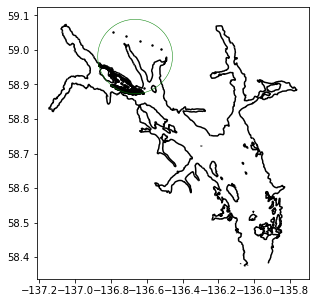

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 319009500
	 5 total events thus far
now processing MMSI: 319063600
	 7 total events thus far
now processing MMSI: 319139700
	 9 total events thus far
now processing MMSI: 319144200
	 11 total events thus far
now processing MMSI: 319147200
	 30 total events thus far
now processing MMSI: 319175300
	 31 total events thus far
now processing MMSI: 319264000
	 34 total events thus far
now processing MMSI: 319822000
	 36 total events thus far
now processing MMSI: 338043017
	 37 total events thus far
now processing MMSI: 338103017
	 38 total events thus far
now processing MMSI: 338120189
	 39 total events thus far
now processing MMSI: 338236805
	 40 total events thus far
now processing MMSI: 367174080
	 44 total events thus far
now processing MMSI: 367540650
	 46 total events thus far
now processing MMSI: 367564140
	 68 total events thus far
now processing MMSI

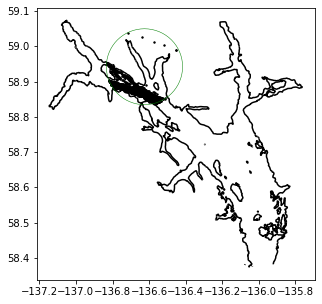

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 7 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 19 total events thus far
now processing MMSI: 319147200
	 21 total events thus far
now processing MMSI: 319175300
	 22 total events thus far
now processing MMSI: 319264000
	 28 total events thus far
now processing MMSI: 319822000
	 30 total events thus far
now processing MMSI: 338043017
	 34 total events thus far
now processing MMSI: 338103017
	 35 total events thus far
now processing MMSI: 338103952
	 36 total events thus far
now processing MMSI: 338120189
	 38 total events thus far
now processing MMSI: 338236805
	 39 total events thus far
now processing MMSI: 367174080
	 43 total events thus far
now processing M

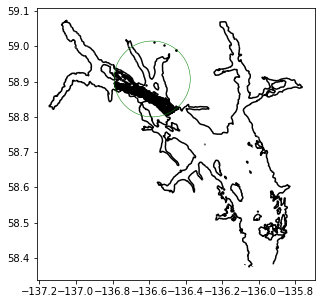

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 319009500
	 12 total events thus far
now processing MMSI: 319063600
	 14 total events thus far
now processing MMSI: 319139700
	 16 total events thus far
now processing MMSI: 319144200
	 18 total events thus far
now processing MMSI: 319147200
	 20 total events thus far
now processing MMSI: 319175300
	 21 total events thus far
now processing MMSI: 319264000
	 28 total events thus far
now processing MMSI: 319822000
	 29 total events thus far
now processing MMSI: 338043017
	 35 total events thus far
now processing MMSI: 338103017
	 37 total events thus far
now processing MMSI: 338103952
	 38 total events thus far
now processing MMSI: 338120189
	 41 total events thus far
now processing MMSI: 367174080
	 45 total events thus far
now processing MMSI: 367450080
	 46 total events thus far
now processing M

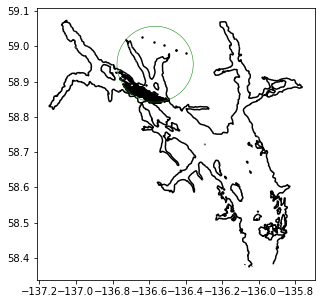

now processing MMSI: 235066752
	 4 total events thus far
now processing MMSI: 235088016
	 6 total events thus far
now processing MMSI: 244620447
	 8 total events thus far
now processing MMSI: 319009500
	 10 total events thus far
now processing MMSI: 319063600
	 12 total events thus far
now processing MMSI: 319139700
	 14 total events thus far
now processing MMSI: 319144200
	 16 total events thus far
now processing MMSI: 319147200
	 18 total events thus far
now processing MMSI: 319264000
	 24 total events thus far
now processing MMSI: 319822000
	 25 total events thus far
now processing MMSI: 338043017
	 27 total events thus far
now processing MMSI: 338103952
	 28 total events thus far
now processing MMSI: 338120189
	 30 total events thus far
now processing MMSI: 367174080
	 33 total events thus far
now processing MMSI: 367450080
	 34 total events thus far
now processing MMSI: 367540650
	 35 total events thus far
now processing MMSI: 367564140
	 38 total events thus far
now processing MM

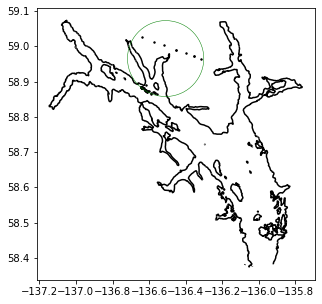

now processing MMSI: 367174080
	 2 total events thus far
now processing MMSI: 367624970
	 3 total events thus far
now processing MMSI: 368069540
	 4 total events thus far
now processing MMSI: 369960000
	 5 total events thus far
now processing MMSI: 538071405
	 6 total events thus far
Simulated event rate: 1.2
Now computing POINT (-136.5000163314619 58.96097435870565)


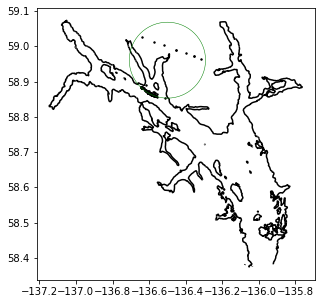

now processing MMSI: 235088016
	 1 total events thus far
now processing MMSI: 367174080
	 3 total events thus far
now processing MMSI: 367564140
	 4 total events thus far
now processing MMSI: 367624970
	 5 total events thus far
now processing MMSI: 368069540
	 6 total events thus far
now processing MMSI: 369960000
	 7 total events thus far
now processing MMSI: 369970398
	 8 total events thus far
now processing MMSI: 538071368
	 9 total events thus far
now processing MMSI: 538071405
	 10 total events thus far
Simulated event rate: 1.25
Now computing POINT (-136.5232397877632 58.92520994245739)


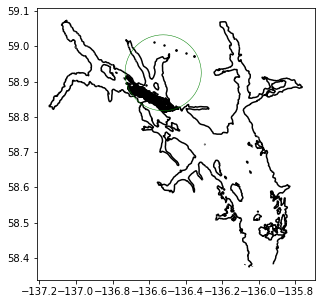

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 7 total events thus far
now processing MMSI: 244620447
	 9 total events thus far
now processing MMSI: 319009500
	 11 total events thus far
now processing MMSI: 319063600
	 13 total events thus far
now processing MMSI: 319139700
	 15 total events thus far
now processing MMSI: 319144200
	 17 total events thus far
now processing MMSI: 319147200
	 19 total events thus far
now processing MMSI: 319175300
	 20 total events thus far
now processing MMSI: 319264000
	 26 total events thus far
now processing MMSI: 338043017
	 30 total events thus far
now processing MMSI: 338103952
	 31 total events thus far
now processing MMSI: 338120189
	 34 total events thus far
now processing MMSI: 367174080
	 37 total events thus far
now processing MMSI: 367450080
	 38 total events thus far
now processing MMSI: 367540650
	 39 total events thus far
now processing MMSI: 367564140
	 42 total events thus far
now processing MM

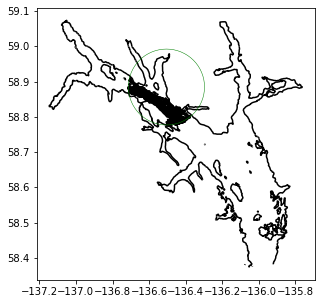

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 7 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 319009500
	 12 total events thus far
now processing MMSI: 319063600
	 14 total events thus far
now processing MMSI: 319139700
	 16 total events thus far
now processing MMSI: 319144200
	 33 total events thus far
now processing MMSI: 319147200
	 35 total events thus far
now processing MMSI: 319175300
	 36 total events thus far
now processing MMSI: 319264000
	 53 total events thus far
now processing MMSI: 338043017
	 57 total events thus far
now processing MMSI: 338103017
	 59 total events thus far
now processing MMSI: 338103952
	 61 total events thus far
now processing MMSI: 338120189
	 65 total events thus far
now processing MMSI: 367174080
	 70 total events thus far
now processing MMSI: 367421750
	 71 total events thus far
now processing MMSI: 367450080
	 73 total events thus far
now processing M

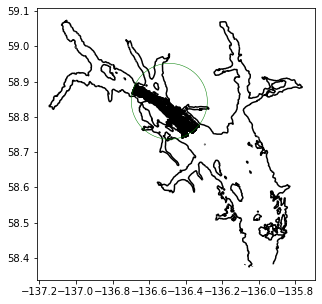

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 7 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319139700
	 18 total events thus far
now processing MMSI: 319144200
	 35 total events thus far
now processing MMSI: 319147200
	 37 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 55 total events thus far
now processing MMSI: 338043017
	 60 total events thus far
now processing MMSI: 338103017
	 63 total events thus far
now processing MMSI: 338103952
	 65 total events thus far
now processing MMSI: 338120189
	 70 total events thus far
now processing MMSI: 367122330
	 71 total events thus far
now processing MMSI: 367174080
	 78 total events thus far
now processing MM

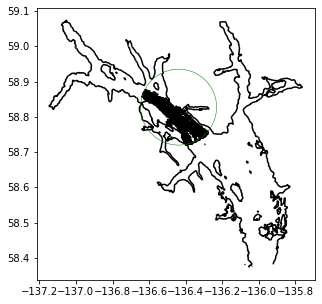

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 55 total events thus far
now processing MMSI: 319822000
	 56 total events thus far
now processing MMSI: 338043017
	 61 total events thus far
now processing MMSI: 338103017
	 64 total events thus far
now processing MMSI: 338103952
	 65 total events thus far
now processing MMSI: 338120189
	 71 total events thus far
now processing MMSI: 338236805
	 72 total events thus far
now processing MM

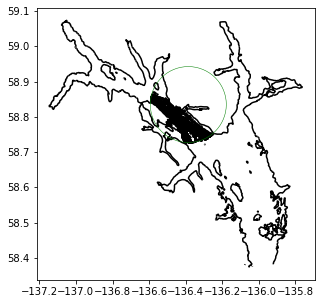

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 54 total events thus far
now processing MMSI: 319822000
	 55 total events thus far
now processing MMSI: 338043017
	 59 total events thus far
now processing MMSI: 338103017
	 62 total events thus far
now processing MMSI: 338103952
	 63 total events thus far
now processing MMSI: 338120189
	 69 total events thus far
now processing MMSI: 338166495
	 70 total events thus far
now processing MM

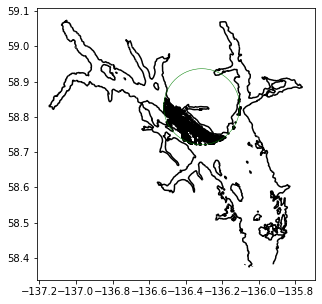

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 319009500
	 12 total events thus far
now processing MMSI: 319063600
	 14 total events thus far
now processing MMSI: 319139700
	 16 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 52 total events thus far
now processing MMSI: 319822000
	 53 total events thus far
now processing MMSI: 338043017
	 57 total events thus far
now processing MMSI: 338103017
	 60 total events thus far
now processing MMSI: 338103952
	 61 total events thus far
now processing MMSI: 338120189
	 66 total events thus far
now processing MMSI: 338166495
	 67 total events thus far
now processing MM

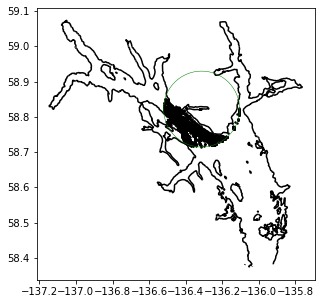

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 319009500
	 12 total events thus far
now processing MMSI: 319063600
	 14 total events thus far
now processing MMSI: 319139700
	 16 total events thus far
now processing MMSI: 319144200
	 33 total events thus far
now processing MMSI: 319147200
	 35 total events thus far
now processing MMSI: 319175300
	 36 total events thus far
now processing MMSI: 319264000
	 52 total events thus far
now processing MMSI: 319822000
	 53 total events thus far
now processing MMSI: 338043017
	 57 total events thus far
now processing MMSI: 338103017
	 60 total events thus far
now processing MMSI: 338103952
	 61 total events thus far
now processing MMSI: 338120189
	 66 total events thus far
now processing MMSI: 338166495
	 67 total events thus far
now processing MM

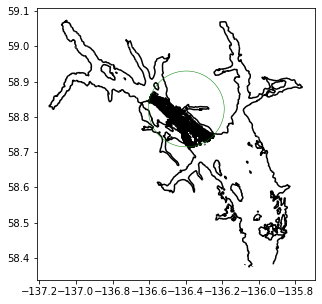

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 54 total events thus far
now processing MMSI: 319822000
	 55 total events thus far
now processing MMSI: 338043017
	 59 total events thus far
now processing MMSI: 338103017
	 62 total events thus far
now processing MMSI: 338103952
	 63 total events thus far
now processing MMSI: 338120189
	 69 total events thus far
now processing MMSI: 338166495
	 70 total events thus far
now processing MM

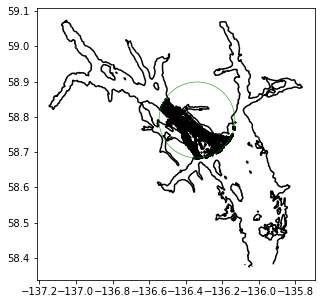

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 316005813
	 14 total events thus far
now processing MMSI: 319009500
	 16 total events thus far
now processing MMSI: 319063600
	 18 total events thus far
now processing MMSI: 319139700
	 20 total events thus far
now processing MMSI: 319144200
	 37 total events thus far
now processing MMSI: 319147200
	 39 total events thus far
now processing MMSI: 319175300
	 41 total events thus far
now processing MMSI: 319264000
	 57 total events thus far
now processing MMSI: 319822000
	 58 total events thus far
now processing MMSI: 338043017
	 63 total events thus far
now processing MMSI: 338103017
	 66 total events thus far
now processing MMSI: 338103952
	 67 total events thus far
now processing MMSI: 338120189
	 72 total events thus far
now processing MM

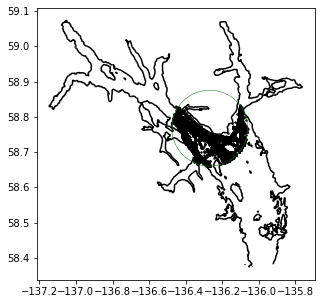

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 316005813
	 16 total events thus far
now processing MMSI: 319009500
	 18 total events thus far
now processing MMSI: 319063600
	 21 total events thus far
now processing MMSI: 319139700
	 23 total events thus far
now processing MMSI: 319144200
	 26 total events thus far
now processing MMSI: 319147200
	 28 total events thus far
now processing MMSI: 319175300
	 30 total events thus far
now processing MMSI: 319264000
	 34 total events thus far
now processing MMSI: 319822000
	 37 total events thus far
now processing MMSI: 338043017
	 44 total events thus far
now processing MMSI: 338103017
	 47 total events thus far
now processing MMSI: 338103952
	 48 total events thus far
now processing MMSI: 338120189
	 52 total events thus far
now processing MM

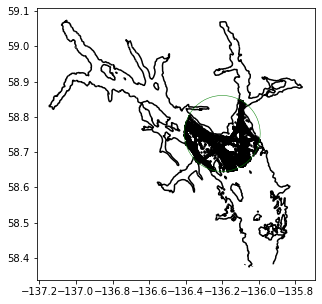

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 316005813
	 17 total events thus far
now processing MMSI: 319009500
	 19 total events thus far
now processing MMSI: 319063600
	 22 total events thus far
now processing MMSI: 319139700
	 24 total events thus far
now processing MMSI: 319144200
	 27 total events thus far
now processing MMSI: 319147200
	 29 total events thus far
now processing MMSI: 319175300
	 31 total events thus far
now processing MMSI: 319264000
	 37 total events thus far
now processing MMSI: 319822000
	 40 total events thus far
now processing MMSI: 338043017
	 47 total events thus far
now processing MMSI: 338103017
	 52 total events thus far
now processing MMSI: 338103952
	 53 total events thus far
now processing MMSI: 338120189
	 56 total events thus far
now processing MM

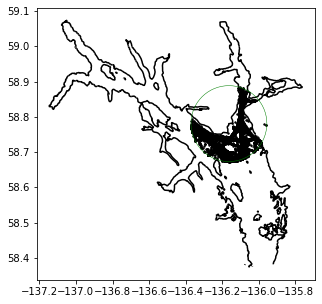

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 8 total events thus far
now processing MMSI: 316005813
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 20 total events thus far
now processing MMSI: 319147200
	 22 total events thus far
now processing MMSI: 319175300
	 24 total events thus far
now processing MMSI: 319264000
	 33 total events thus far
now processing MMSI: 319822000
	 36 total events thus far
now processing MMSI: 338043017
	 39 total events thus far
now processing MMSI: 338103017
	 43 total events thus far
now processing MMSI: 338103952
	 44 total events thus far
now processing MMSI: 338120189
	 46 total events thus far
now processing MMS

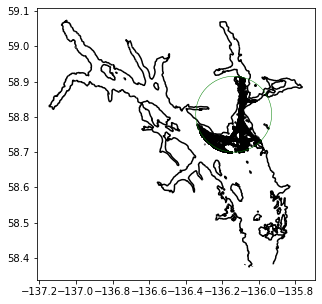

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 316005813
	 6 total events thus far
now processing MMSI: 319009500
	 8 total events thus far
now processing MMSI: 319063600
	 9 total events thus far
now processing MMSI: 319139700
	 11 total events thus far
now processing MMSI: 319144200
	 14 total events thus far
now processing MMSI: 319147200
	 16 total events thus far
now processing MMSI: 319175300
	 17 total events thus far
now processing MMSI: 319264000
	 21 total events thus far
now processing MMSI: 319822000
	 24 total events thus far
now processing MMSI: 338043017
	 27 total events thus far
now processing MMSI: 338103017
	 29 total events thus far
now processing MMSI: 338103952
	 30 total events thus far
now processing MMSI: 338166495
	 31 total events thus far
now processing MMSI: 367174080
	 33 total events thus far
now processing MMSI: 367421750
	 37 total events thus far
now processing MMSI

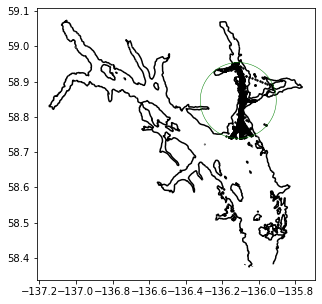

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 338103017
	 4 total events thus far
now processing MMSI: 338103952
	 5 total events thus far
now processing MMSI: 367580440
	 13 total events thus far
now processing MMSI: 367624970
	 16 total events thus far
now processing MMSI: 368069540
	 27 total events thus far
now processing MMSI: 368087940
	 72 total events thus far
now processing MMSI: 368089260
	 82 total events thus far
now processing MMSI: 368089270
	 101 total events thus far
now processing MMSI: 368152380
	 104 total events thus far
now processing MMSI: 369970398
	 110 total events thus far
now processing MMSI: 512000153
	 112 total events thus far
now processing MMSI: 538071368
	 158 total events thus far
now processing MMSI: 538071405
	 235 total events thus far
Simulated event rate: 6.351351351351352
Now computing POINT (-136.110263713794 58.88660169410029)


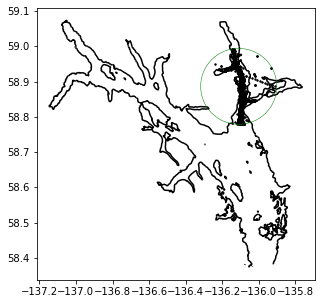

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 338103952
	 4 total events thus far
now processing MMSI: 367580440
	 10 total events thus far
now processing MMSI: 367624970
	 14 total events thus far
now processing MMSI: 368069540
	 25 total events thus far
now processing MMSI: 368087940
	 66 total events thus far
now processing MMSI: 368089260
	 77 total events thus far
now processing MMSI: 368089270
	 99 total events thus far
now processing MMSI: 368152380
	 101 total events thus far
now processing MMSI: 369970398
	 106 total events thus far
now processing MMSI: 538071368
	 152 total events thus far
now processing MMSI: 538071405
	 197 total events thus far
Simulated event rate: 5.472222222222222
Now computing POINT (-136.1072096067906 58.91282833317275)


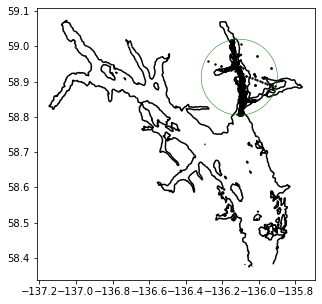

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 367580440
	 8 total events thus far
now processing MMSI: 367624970
	 12 total events thus far
now processing MMSI: 368069540
	 23 total events thus far
now processing MMSI: 368087940
	 67 total events thus far
now processing MMSI: 368089260
	 77 total events thus far
now processing MMSI: 368089270
	 94 total events thus far
now processing MMSI: 368152380
	 95 total events thus far
now processing MMSI: 369970398
	 99 total events thus far
now processing MMSI: 538071368
	 145 total events thus far
now processing MMSI: 538071405
	 197 total events thus far
Simulated event rate: 5.794117647058823
Now computing POINT (-136.1587010206318 58.9309812750051)


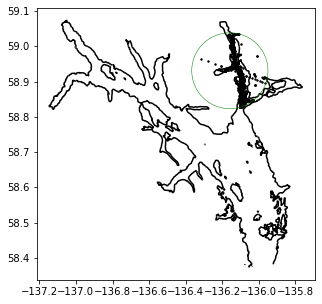

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 7 total events thus far
now processing MMSI: 367624970
	 10 total events thus far
now processing MMSI: 368069540
	 25 total events thus far
now processing MMSI: 368087940
	 74 total events thus far
now processing MMSI: 368089260
	 84 total events thus far
now processing MMSI: 368089270
	 99 total events thus far
now processing MMSI: 368152380
	 101 total events thus far
now processing MMSI: 369970398
	 104 total events thus far
now processing MMSI: 538071368
	 149 total events thus far
now processing MMSI: 538071405
	 160 total events thus far
Simulated event rate: 4.848484848484849
Now computing POINT (-136.2201649952123 58.9187141859823)


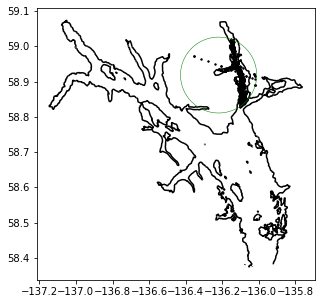

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 6 total events thus far
now processing MMSI: 367624970
	 8 total events thus far
now processing MMSI: 368069540
	 19 total events thus far
now processing MMSI: 368087940
	 62 total events thus far
now processing MMSI: 368089260
	 71 total events thus far
now processing MMSI: 368089270
	 86 total events thus far
now processing MMSI: 368152380
	 87 total events thus far
now processing MMSI: 369970398
	 90 total events thus far
now processing MMSI: 538071368
	 136 total events thus far
now processing MMSI: 538071405
	 145 total events thus far
Simulated event rate: 4.53125
Now computing POINT (-136.2199627281558 58.93569154663692)


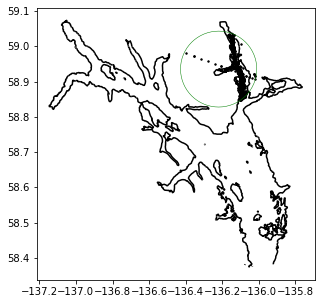

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 6 total events thus far
now processing MMSI: 367624970
	 9 total events thus far
now processing MMSI: 368069540
	 24 total events thus far
now processing MMSI: 368087940
	 66 total events thus far
now processing MMSI: 368089260
	 75 total events thus far
now processing MMSI: 368089270
	 89 total events thus far
now processing MMSI: 368152380
	 91 total events thus far
now processing MMSI: 369970398
	 94 total events thus far
now processing MMSI: 538071368
	 139 total events thus far
now processing MMSI: 538071405
	 148 total events thus far
Simulated event rate: 4.774193548387097
Now computing POINT (-136.1448451449489 58.94861930542014)


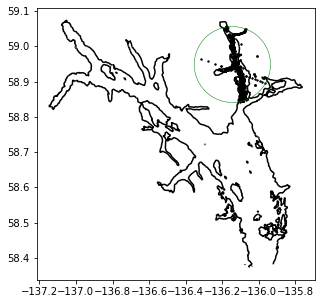

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 367580440
	 7 total events thus far
now processing MMSI: 367624970
	 10 total events thus far
now processing MMSI: 368069540
	 26 total events thus far
now processing MMSI: 368087940
	 80 total events thus far
now processing MMSI: 368089260
	 90 total events thus far
now processing MMSI: 368089270
	 107 total events thus far
now processing MMSI: 368152380
	 109 total events thus far
now processing MMSI: 369970398
	 113 total events thus far
now processing MMSI: 538071368
	 158 total events thus far
now processing MMSI: 538071405
	 167 total events thus far
Simulated event rate: 5.387096774193548
Now computing POINT (-136.1421294881357 58.98132916763871)


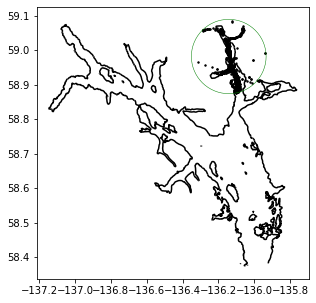

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 6 total events thus far
now processing MMSI: 367624970
	 11 total events thus far
now processing MMSI: 368069540
	 27 total events thus far
now processing MMSI: 368087940
	 92 total events thus far
now processing MMSI: 368089260
	 104 total events thus far
now processing MMSI: 368089270
	 124 total events thus far
now processing MMSI: 368152380
	 127 total events thus far
now processing MMSI: 369970398
	 130 total events thus far
now processing MMSI: 538071368
	 175 total events thus far
now processing MMSI: 538071405
	 185 total events thus far
Simulated event rate: 5.78125
Now computing POINT (-136.1625850804409 59.01622991525836)


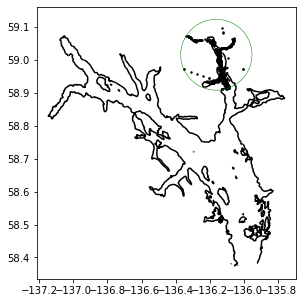

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 6 total events thus far
now processing MMSI: 367624970
	 10 total events thus far
now processing MMSI: 368069540
	 26 total events thus far
now processing MMSI: 368087940
	 83 total events thus far
now processing MMSI: 368089260
	 92 total events thus far
now processing MMSI: 368089270
	 110 total events thus far
now processing MMSI: 368152380
	 113 total events thus far
now processing MMSI: 369970398
	 114 total events thus far
now processing MMSI: 538071368
	 159 total events thus far
now processing MMSI: 538071405
	 169 total events thus far
Simulated event rate: 5.451612903225806
Now computing POINT (-136.2033062233708 59.05469617112784)


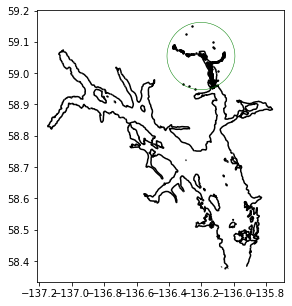

now processing MMSI: 319144200
	 7 total events thus far
now processing MMSI: 367624970
	 12 total events thus far
now processing MMSI: 368069540
	 21 total events thus far
now processing MMSI: 368087940
	 73 total events thus far
now processing MMSI: 368089260
	 81 total events thus far
now processing MMSI: 368089270
	 94 total events thus far
now processing MMSI: 368152380
	 96 total events thus far
now processing MMSI: 369970398
	 97 total events thus far
now processing MMSI: 538071368
	 98 total events thus far
now processing MMSI: 538071405
	 108 total events thus far
Simulated event rate: 3.6
Now computing POINT (-136.1744265025386 59.05796061632015)


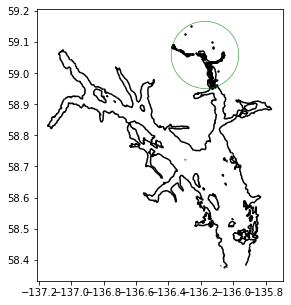

now processing MMSI: 319144200
	 7 total events thus far
now processing MMSI: 367624970
	 11 total events thus far
now processing MMSI: 368069540
	 20 total events thus far
now processing MMSI: 368087940
	 73 total events thus far
now processing MMSI: 368089260
	 81 total events thus far
now processing MMSI: 368089270
	 94 total events thus far
now processing MMSI: 368152380
	 96 total events thus far
now processing MMSI: 369970398
	 97 total events thus far
now processing MMSI: 538071368
	 98 total events thus far
now processing MMSI: 538071405
	 108 total events thus far
Simulated event rate: 3.7241379310344827
Now computing POINT (-136.1351903423885 59.02448963118039)


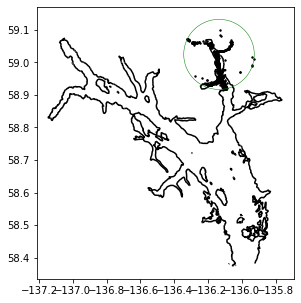

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367624970
	 7 total events thus far
now processing MMSI: 368069540
	 23 total events thus far
now processing MMSI: 368087940
	 80 total events thus far
now processing MMSI: 368089260
	 89 total events thus far
now processing MMSI: 368089270
	 107 total events thus far
now processing MMSI: 368152380
	 110 total events thus far
now processing MMSI: 369970398
	 111 total events thus far
now processing MMSI: 538071368
	 156 total events thus far
now processing MMSI: 538071405
	 166 total events thus far
Simulated event rate: 5.1875
Now computing POINT (-136.1075621924272 58.98868014561722)


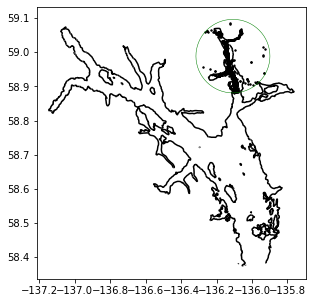

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 6 total events thus far
now processing MMSI: 367624970
	 13 total events thus far
now processing MMSI: 368069540
	 29 total events thus far
now processing MMSI: 368087940
	 93 total events thus far
now processing MMSI: 368089260
	 105 total events thus far
now processing MMSI: 368089270
	 125 total events thus far
now processing MMSI: 368152380
	 128 total events thus far
now processing MMSI: 369970398
	 130 total events thus far
now processing MMSI: 538071368
	 175 total events thus far
now processing MMSI: 538071405
	 185 total events thus far
Simulated event rate: 5.4411764705882355
Now computing POINT (-136.1080435480969 58.9578516534749)


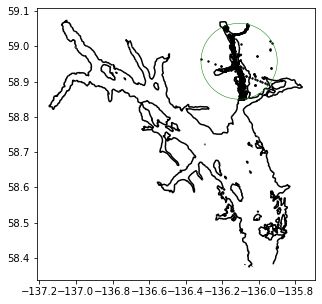

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 6 total events thus far
now processing MMSI: 367624970
	 13 total events thus far
now processing MMSI: 368069540
	 29 total events thus far
now processing MMSI: 368087940
	 96 total events thus far
now processing MMSI: 368089260
	 109 total events thus far
now processing MMSI: 368089270
	 130 total events thus far
now processing MMSI: 368152380
	 132 total events thus far
now processing MMSI: 369970398
	 136 total events thus far
now processing MMSI: 538071368
	 181 total events thus far
now processing MMSI: 538071405
	 190 total events thus far
Simulated event rate: 5.428571428571429
Now computing POINT (-136.0644495109409 58.93084908981201)


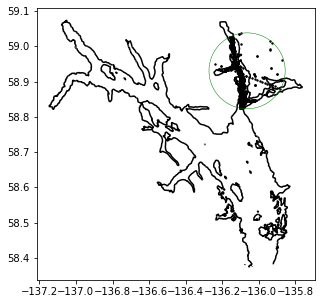

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 7 total events thus far
now processing MMSI: 367624970
	 14 total events thus far
now processing MMSI: 368069540
	 26 total events thus far
now processing MMSI: 368087940
	 70 total events thus far
now processing MMSI: 368089260
	 80 total events thus far
now processing MMSI: 368089270
	 98 total events thus far
now processing MMSI: 368152380
	 99 total events thus far
now processing MMSI: 369970398
	 102 total events thus far
now processing MMSI: 538071368
	 150 total events thus far
now processing MMSI: 538071405
	 202 total events thus far
Simulated event rate: 5.45945945945946
Now computing POINT (-136.0506130326067 58.89394087578061)


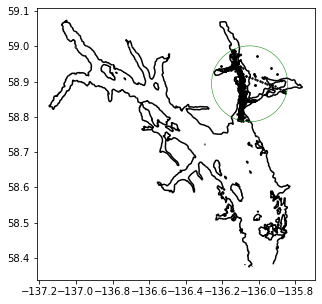

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 338103952
	 4 total events thus far
now processing MMSI: 367580440
	 9 total events thus far
now processing MMSI: 367624970
	 13 total events thus far
now processing MMSI: 368069540
	 24 total events thus far
now processing MMSI: 368087940
	 65 total events thus far
now processing MMSI: 368089260
	 75 total events thus far
now processing MMSI: 368089270
	 96 total events thus far
now processing MMSI: 368152380
	 97 total events thus far
now processing MMSI: 369970398
	 101 total events thus far
now processing MMSI: 538071368
	 147 total events thus far
now processing MMSI: 538071405
	 192 total events thus far
Simulated event rate: 5.647058823529412
Now computing POINT (-136.0528453032987 58.85833114500728)


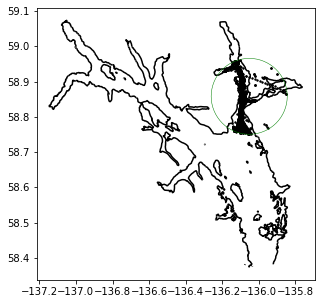

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 338103952
	 4 total events thus far
now processing MMSI: 367580440
	 10 total events thus far
now processing MMSI: 367624970
	 15 total events thus far
now processing MMSI: 368069540
	 26 total events thus far
now processing MMSI: 368087940
	 70 total events thus far
now processing MMSI: 368089260
	 80 total events thus far
now processing MMSI: 368089270
	 97 total events thus far
now processing MMSI: 368152380
	 99 total events thus far
now processing MMSI: 369970398
	 105 total events thus far
now processing MMSI: 538071368
	 151 total events thus far
now processing MMSI: 538071405
	 228 total events thus far
Simulated event rate: 6.162162162162162
Now computing POINT (-135.9910920807074 58.86487900479811)


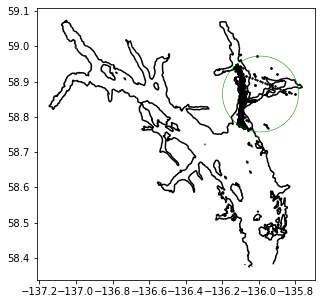

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 338103952
	 4 total events thus far
now processing MMSI: 367580440
	 10 total events thus far
now processing MMSI: 367624970
	 15 total events thus far
now processing MMSI: 368069540
	 17 total events thus far
now processing MMSI: 368087940
	 56 total events thus far
now processing MMSI: 368089260
	 63 total events thus far
now processing MMSI: 368089270
	 79 total events thus far
now processing MMSI: 368152380
	 81 total events thus far
now processing MMSI: 369970398
	 85 total events thus far
now processing MMSI: 538071368
	 87 total events thus far
now processing MMSI: 538071405
	 132 total events thus far
Simulated event rate: 3.6666666666666665
Now computing POINT (-135.9377061756815 58.88607695066342)


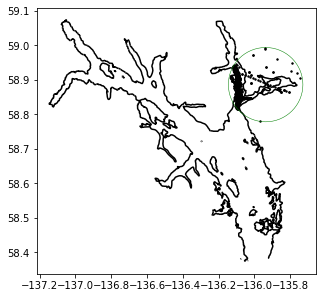

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 7 total events thus far
now processing MMSI: 367624970
	 14 total events thus far
now processing MMSI: 368069540
	 16 total events thus far
now processing MMSI: 368087940
	 53 total events thus far
now processing MMSI: 368089260
	 58 total events thus far
now processing MMSI: 368089270
	 68 total events thus far
now processing MMSI: 368152380
	 69 total events thus far
now processing MMSI: 369970398
	 72 total events thus far
now processing MMSI: 538071368
	 74 total events thus far
now processing MMSI: 538071405
	 119 total events thus far
Simulated event rate: 3.3055555555555554
Now computing POINT (-135.9761343807654 58.91156099951447)


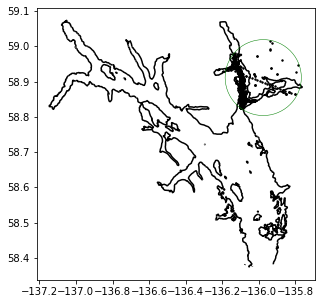

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367580440
	 7 total events thus far
now processing MMSI: 367624970
	 14 total events thus far
now processing MMSI: 368069540
	 17 total events thus far
now processing MMSI: 368087940
	 56 total events thus far
now processing MMSI: 368089260
	 65 total events thus far
now processing MMSI: 368089270
	 79 total events thus far
now processing MMSI: 368152380
	 80 total events thus far
now processing MMSI: 369970398
	 83 total events thus far
now processing MMSI: 538071368
	 86 total events thus far
now processing MMSI: 538071405
	 131 total events thus far
Simulated event rate: 3.5405405405405403
Now computing POINT (-135.898025671168 58.90333927759588)


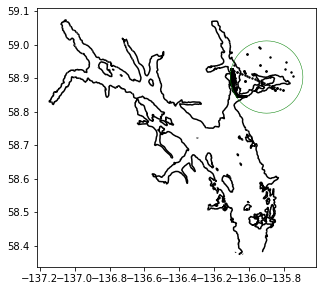

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367624970
	 8 total events thus far
now processing MMSI: 368069540
	 10 total events thus far
now processing MMSI: 368087940
	 28 total events thus far
now processing MMSI: 368089260
	 29 total events thus far
now processing MMSI: 368089270
	 33 total events thus far
now processing MMSI: 368152380
	 34 total events thus far
now processing MMSI: 538071368
	 36 total events thus far
now processing MMSI: 538071405
	 81 total events thus far
Simulated event rate: 2.892857142857143
Now computing POINT (-135.8164286951633 58.90406210899361)


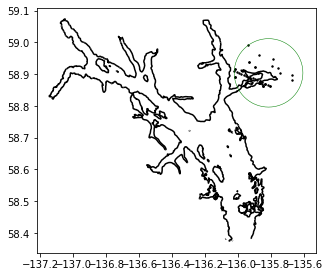

now processing MMSI: 367624970
	 7 total events thus far
Simulated event rate: 1.0
Now computing POINT (-135.7667005805782 58.8829244312069)


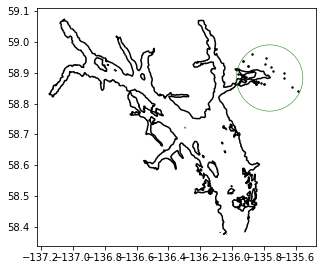

now processing MMSI: 367624970
	 7 total events thus far
Simulated event rate: 1.0
Now computing POINT (-135.8493080985 58.87880022313144)


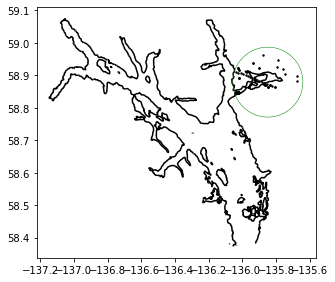

now processing MMSI: 367624970
	 6 total events thus far
now processing MMSI: 538071405
	 51 total events thus far
Simulated event rate: 6.375
Now computing POINT (-135.9210820971493 58.86235614501979)


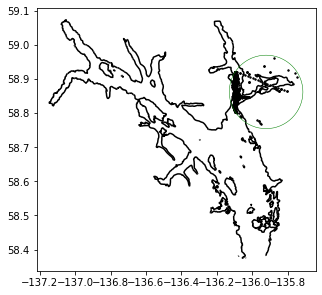

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 367580440
	 4 total events thus far
now processing MMSI: 367624970
	 10 total events thus far
now processing MMSI: 368069540
	 12 total events thus far
now processing MMSI: 368087940
	 47 total events thus far
now processing MMSI: 368089260
	 52 total events thus far
now processing MMSI: 368089270
	 61 total events thus far
now processing MMSI: 368152380
	 62 total events thus far
now processing MMSI: 369970398
	 64 total events thus far
now processing MMSI: 538071368
	 66 total events thus far
now processing MMSI: 538071405
	 111 total events thus far
Simulated event rate: 3.1714285714285713
Now computing POINT (-135.9302718104516 58.86951618351979)


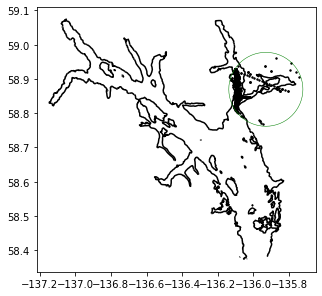

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 367580440
	 4 total events thus far
now processing MMSI: 367624970
	 10 total events thus far
now processing MMSI: 368069540
	 12 total events thus far
now processing MMSI: 368087940
	 49 total events thus far
now processing MMSI: 368089260
	 54 total events thus far
now processing MMSI: 368089270
	 64 total events thus far
now processing MMSI: 368152380
	 65 total events thus far
now processing MMSI: 369970398
	 67 total events thus far
now processing MMSI: 538071368
	 69 total events thus far
now processing MMSI: 538071405
	 114 total events thus far
Simulated event rate: 3.257142857142857
Now computing POINT (-135.9571207127987 58.86820464747677)


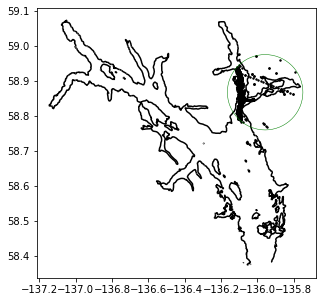

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 338103952
	 4 total events thus far
now processing MMSI: 367580440
	 9 total events thus far
now processing MMSI: 367624970
	 15 total events thus far
now processing MMSI: 368069540
	 17 total events thus far
now processing MMSI: 368087940
	 55 total events thus far
now processing MMSI: 368089260
	 60 total events thus far
now processing MMSI: 368089270
	 74 total events thus far
now processing MMSI: 368152380
	 76 total events thus far
now processing MMSI: 369970398
	 80 total events thus far
now processing MMSI: 538071368
	 82 total events thus far
now processing MMSI: 538071405
	 127 total events thus far
Simulated event rate: 3.6285714285714286
Now computing POINT (-136.0100273042732 58.8457094102918)


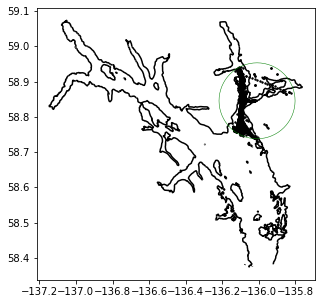

now processing MMSI: 319144200
	 3 total events thus far
now processing MMSI: 338103952
	 4 total events thus far
now processing MMSI: 367580440
	 11 total events thus far
now processing MMSI: 367624970
	 16 total events thus far
now processing MMSI: 368069540
	 18 total events thus far
now processing MMSI: 368087940
	 62 total events thus far
now processing MMSI: 368089260
	 72 total events thus far
now processing MMSI: 368089270
	 89 total events thus far
now processing MMSI: 368152380
	 91 total events thus far
now processing MMSI: 369970398
	 97 total events thus far
now processing MMSI: 538071368
	 99 total events thus far
now processing MMSI: 538071405
	 176 total events thus far
Simulated event rate: 4.888888888888889
Now computing POINT (-136.079853840362 58.82416095034203)


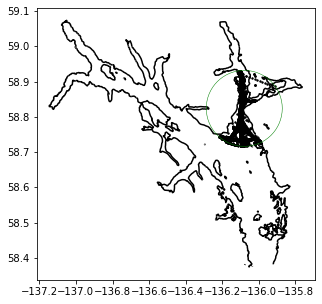

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 319009500
	 3 total events thus far
now processing MMSI: 319144200
	 6 total events thus far
now processing MMSI: 319264000
	 11 total events thus far
now processing MMSI: 319822000
	 12 total events thus far
now processing MMSI: 338103017
	 15 total events thus far
now processing MMSI: 338103952
	 16 total events thus far
now processing MMSI: 367174080
	 18 total events thus far
now processing MMSI: 367421750
	 22 total events thus far
now processing MMSI: 367564140
	 23 total events thus far
now processing MMSI: 367580440
	 31 total events thus far
now processing MMSI: 367624970
	 34 total events thus far
now processing MMSI: 368069540
	 36 total events thus far
now processing MMSI: 368087940
	 90 total events thus far
now processing MMSI: 368089260
	 101 total events thus far
now processing MMSI: 368089270
	 114 total events thus far
now processing MMSI: 368152380
	 118 total events thus far
now processing

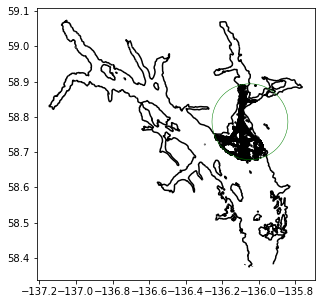

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 316005813
	 13 total events thus far
now processing MMSI: 319009500
	 18 total events thus far
now processing MMSI: 319144200
	 21 total events thus far
now processing MMSI: 319175300
	 24 total events thus far
now processing MMSI: 319264000
	 33 total events thus far
now processing MMSI: 319822000
	 39 total events thus far
now processing MMSI: 338103017
	 45 total events thus far
now processing MMSI: 338103952
	 46 total events thus far
now processing MMSI: 367174080
	 52 total events thus far
now processing MMSI: 367421750
	 58 total events thus far
now processing MMSI: 367540650
	 61 total events thus far
now processing MMSI: 367564140
	 62 total events thus far
now processing MMSI: 367580440
	 67 total events thus far
now processing MMSI: 367624970
	 70 total events thus far
now processing MMSI: 368066070
	 71 total events thus far
now processing MMSI: 368069540
	 74 total events thus far
now processing 

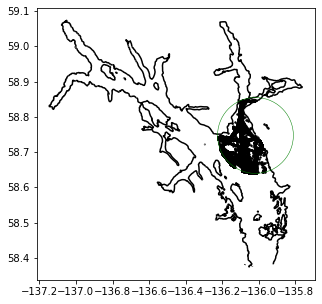

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 316005813
	 17 total events thus far
now processing MMSI: 319009500
	 22 total events thus far
now processing MMSI: 319063600
	 23 total events thus far
now processing MMSI: 319139700
	 25 total events thus far
now processing MMSI: 319144200
	 27 total events thus far
now processing MMSI: 319175300
	 31 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 46 total events thus far
now processing MMSI: 338043017
	 47 total events thus far
now processing MMSI: 338103017
	 53 total events thus far
now processing MMSI: 338103952
	 54 total events thus far
now processing MMSI: 367122330
	 55 total events thus far
now processing MMSI: 367174080
	 62 total events thus far
now processing MMSI: 367421750
	 68 total events thus far
now processing MMSI: 367540650
	 72 total events thus far
now processing M

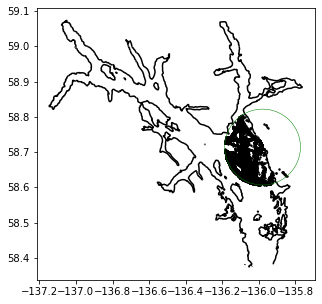

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 319009500
	 25 total events thus far
now processing MMSI: 319063600
	 26 total events thus far
now processing MMSI: 319139700
	 28 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 46 total events thus far
now processing MMSI: 319822000
	 52 total events thus far
now processing MMSI: 338043017
	 53 total events thus far
now processing MMSI: 338103017
	 59 total events thus far
now processing MMSI: 338103952
	 62 total events thus far
now processing MMSI: 338313153
	 63 total events thus far
now processing MMSI: 367122330
	 65 total events thus far
now processing MM

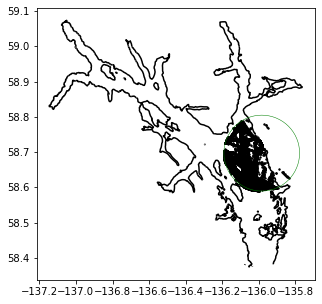

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 319009500
	 26 total events thus far
now processing MMSI: 319063600
	 27 total events thus far
now processing MMSI: 319139700
	 29 total events thus far
now processing MMSI: 319144200
	 31 total events thus far
now processing MMSI: 319147200
	 33 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 48 total events thus far
now processing MMSI: 319822000
	 54 total events thus far
now processing MMSI: 338043017
	 55 total events thus far
now processing MMSI: 338103017
	 61 total events thus far
now processing MMSI: 338103952
	 63 total events thus far
now processing MMSI: 338166495
	 64 total events thus far
now processing MMSI: 338313153
	 65 total events thus far
now processing MM

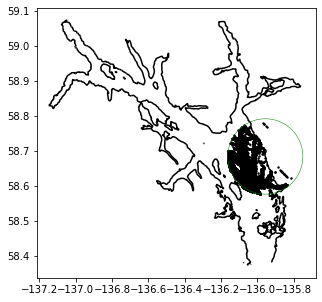

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 319009500
	 26 total events thus far
now processing MMSI: 319063600
	 27 total events thus far
now processing MMSI: 319139700
	 29 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 32 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 47 total events thus far
now processing MMSI: 319822000
	 52 total events thus far
now processing MMSI: 338043017
	 53 total events thus far
now processing MMSI: 338103017
	 58 total events thus far
now processing MMSI: 338103952
	 60 total events thus far
now processing MMSI: 338166495
	 61 total events thus far
now processing MMSI: 338313153
	 62 total events thus far
now processing MM

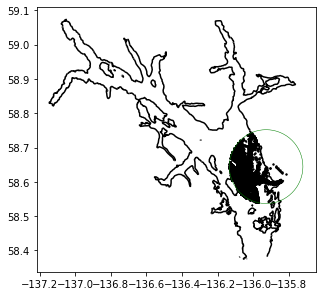

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 319009500
	 26 total events thus far
now processing MMSI: 319063600
	 27 total events thus far
now processing MMSI: 319139700
	 29 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 32 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 46 total events thus far
now processing MMSI: 319822000
	 52 total events thus far
now processing MMSI: 338043017
	 53 total events thus far
now processing MMSI: 338103017
	 57 total events thus far
now processing MMSI: 338103952
	 60 total events thus far
now processing MMSI: 338166495
	 62 total events thus far
now processing MMSI: 338313153
	 63 total events thus far
now processing MM

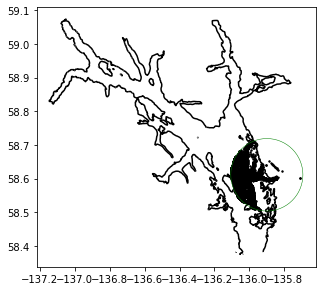

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 5 total events thus far
now processing MMSI: 316005813
	 14 total events thus far
now processing MMSI: 319009500
	 17 total events thus far
now processing MMSI: 319063600
	 18 total events thus far
now processing MMSI: 319139700
	 20 total events thus far
now processing MMSI: 319144200
	 21 total events thus far
now processing MMSI: 319147200
	 23 total events thus far
now processing MMSI: 319175300
	 28 total events thus far
now processing MMSI: 319264000
	 30 total events thus far
now processing MMSI: 319822000
	 33 total events thus far
now processing MMSI: 338043017
	 34 total events thus far
now processing MMSI: 338103017
	 35 total events thus far
now processing MMSI: 338103952
	 38 total events thus far
now processing MMSI: 338166495
	 40 total events thus far
now processing MMSI: 338313153
	 41 total events thus far
now processing MM

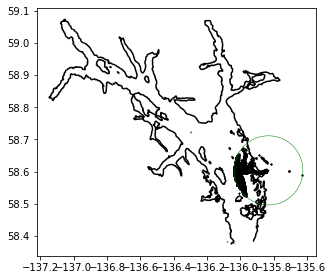

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 244058902
	 2 total events thus far
now processing MMSI: 316005813
	 6 total events thus far
now processing MMSI: 319009500
	 7 total events thus far
now processing MMSI: 319264000
	 9 total events thus far
now processing MMSI: 338103017
	 10 total events thus far
now processing MMSI: 338166495
	 11 total events thus far
now processing MMSI: 338313153
	 12 total events thus far
now processing MMSI: 367174080
	 13 total events thus far
now processing MMSI: 367540650
	 14 total events thus far
now processing MMSI: 367564140
	 15 total events thus far
now processing MMSI: 367624970
	 17 total events thus far
now processing MMSI: 367676610
	 19 total events thus far
now processing MMSI: 367726230
	 20 total events thus far
now processing MMSI: 368069540
	 21 total events thus far
now processing MMSI: 368087940
	 26 total events thus far
now processing MMSI: 368089260
	 38 total events thus far
now processing MMSI

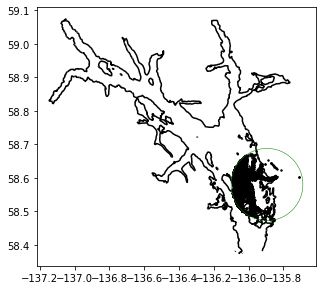

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 316005813
	 10 total events thus far
now processing MMSI: 319009500
	 12 total events thus far
now processing MMSI: 319063600
	 13 total events thus far
now processing MMSI: 319139700
	 15 total events thus far
now processing MMSI: 319144200
	 16 total events thus far
now processing MMSI: 319147200
	 18 total events thus far
now processing MMSI: 319175300
	 22 total events thus far
now processing MMSI: 319264000
	 24 total events thus far
now processing MMSI: 319822000
	 27 total events thus far
now processing MMSI: 338043017
	 28 total events thus far
now processing MMSI: 338103017
	 29 total events thus far
now processing MMSI: 338103952
	 32 total events thus far
now processing MMSI: 338166495
	 34 total events thus far
now processing MMSI: 338313153
	 35 total events thus far
now processing MM

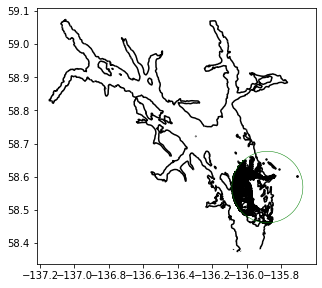

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 316005813
	 9 total events thus far
now processing MMSI: 319009500
	 11 total events thus far
now processing MMSI: 319063600
	 12 total events thus far
now processing MMSI: 319139700
	 14 total events thus far
now processing MMSI: 319144200
	 15 total events thus far
now processing MMSI: 319147200
	 17 total events thus far
now processing MMSI: 319175300
	 20 total events thus far
now processing MMSI: 319264000
	 22 total events thus far
now processing MMSI: 319822000
	 25 total events thus far
now processing MMSI: 338043017
	 26 total events thus far
now processing MMSI: 338103017
	 27 total events thus far
now processing MMSI: 338103952
	 30 total events thus far
now processing MMSI: 338166495
	 31 total events thus far
now processing MMSI: 338313153
	 32 total events thus far
now processing MMS

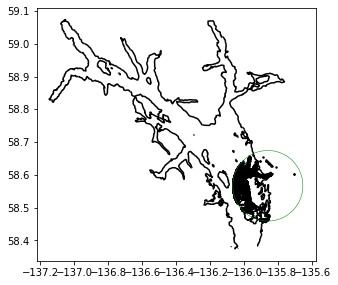

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 5 total events thus far
now processing MMSI: 316005813
	 8 total events thus far
now processing MMSI: 319009500
	 9 total events thus far
now processing MMSI: 319063600
	 10 total events thus far
now processing MMSI: 319139700
	 12 total events thus far
now processing MMSI: 319144200
	 13 total events thus far
now processing MMSI: 319147200
	 15 total events thus far
now processing MMSI: 319175300
	 17 total events thus far
now processing MMSI: 319264000
	 19 total events thus far
now processing MMSI: 319822000
	 20 total events thus far
now processing MMSI: 338043017
	 21 total events thus far
now processing MMSI: 338103017
	 22 total events thus far
now processing MMSI: 338103952
	 25 total events thus far
now processing MMSI: 338166495
	 26 total events thus far
now processing MMSI: 338313153
	 27 total events thus far
now processing MMSI

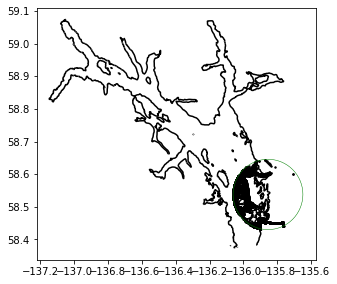

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 16 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 316005813
	 22 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319139700
	 24 total events thus far
now processing MMSI: 319144200
	 26 total events thus far
now processing MMSI: 319147200
	 28 total events thus far
now processing MMSI: 319175300
	 29 total events thus far
now processing MMSI: 319264000
	 32 total events thus far
now processing MMSI: 319822000
	 33 total events thus far
now processing MMSI: 338043017
	 34 total events thus far
now processing MMSI: 338103017
	 36 total events thus far
now processing MMSI: 338103952
	 58 total events thus far
now processing MMSI: 338166495
	 59 total events thus far
now processing MMSI: 338236805
	 61 total events thus far
now processing M

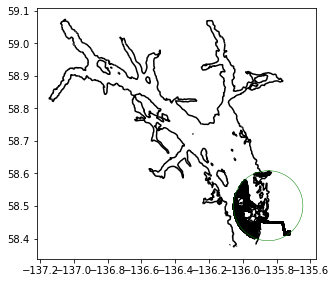

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 45 total events thus far
now processing MMSI: 338043017
	 47 total events thus far
now processing MMSI: 338103017
	 49 total events thus far
now processing MMSI: 338103952
	 70 total events thus far
now processing MMSI: 338120189
	 72 total events thus far
now processing M

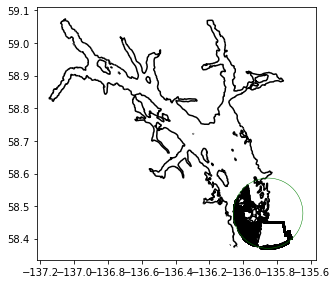

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 36 total events thus far
now processing MMSI: 319264000
	 39 total events thus far
now processing MMSI: 319822000
	 45 total events thus far
now processing MMSI: 338043017
	 47 total events thus far
now processing MMSI: 338103017
	 49 total events thus far
now processing MMSI: 338103952
	 71 total events thus far
now processing MMSI: 338120189
	 73 total events thus far
now processing M

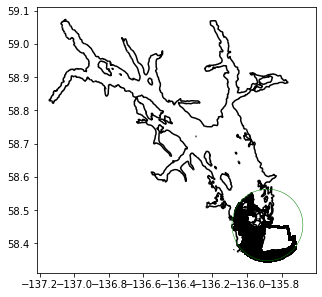

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 316011757
	 24 total events thus far
now processing MMSI: 319009500
	 26 total events thus far
now processing MMSI: 319063600
	 28 total events thus far
now processing MMSI: 319139700
	 30 total events thus far
now processing MMSI: 319144200
	 32 total events thus far
now processing MMSI: 319147200
	 34 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 42 total events thus far
now processing MMSI: 319822000
	 48 total events thus far
now processing MMSI: 338043017
	 50 total events thus far
now processing MMSI: 338103017
	 52 total events thus far
now processing MMSI: 338103952
	 73 total events thus far
now processing M

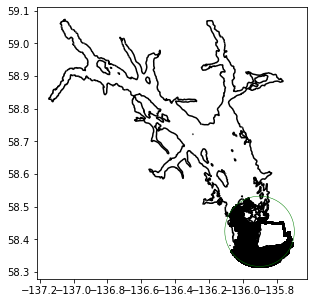

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 249241000
	 20 total events thus far
now processing MMSI: 303683000
	 21 total events thus far
now processing MMSI: 316005813
	 25 total events thus far
now processing MMSI: 316011757
	 30 total events thus far
now processing MMSI: 319009500
	 32 total events thus far
now processing MMSI: 319063600
	 34 total events thus far
now processing MMSI: 319139700
	 36 total events thus far
now processing MMSI: 319144200
	 38 total events thus far
now processing MMSI: 319147200
	 40 total events thus far
now processing MMSI: 319175300
	 46 total events thus far
now processing MMSI: 319264000
	 49 total events thus far
now processing MMSI: 319822000
	 56 total events thus far
now processing MMSI: 338043017
	 58 total events thus far
now processing M

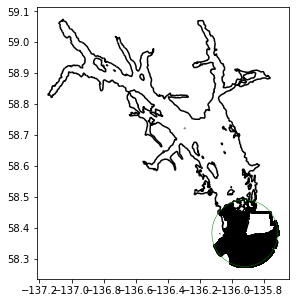

now processing MMSI: 211609000
	 1 total events thus far
now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 16 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 249241000
	 21 total events thus far
now processing MMSI: 269102010
	 22 total events thus far
now processing MMSI: 303233000
	 24 total events thus far
now processing MMSI: 303275000
	 25 total events thus far
now processing MMSI: 303295000
	 26 total events thus far
now processing MMSI: 303561000
	 27 total events thus far
now processing MMSI: 303670000
	 28 total events thus far
now processing MMSI: 303673000
	 29 total events thus far
now processing MMSI: 303683000
	 30 total events thus far
now processing MMSI: 316005813
	 35 total events thus far
now processing MMSI: 316011757
	 44 total events thus far
now processing MMSI: 319009500
	 47 total events thus far
now processing MM

now processing MMSI: 367734510
	 374 total events thus far
now processing MMSI: 367735610
	 375 total events thus far
now processing MMSI: 367739250
	 380 total events thus far
now processing MMSI: 367740740
	 384 total events thus far
now processing MMSI: 367745000
	 385 total events thus far
now processing MMSI: 367762190
	 386 total events thus far
now processing MMSI: 367764780
	 387 total events thus far
now processing MMSI: 367768710
	 394 total events thus far
now processing MMSI: 367773000
	 395 total events thus far
now processing MMSI: 367774490
	 396 total events thus far
now processing MMSI: 367782140
	 397 total events thus far
now processing MMSI: 367790680
	 398 total events thus far
now processing MMSI: 368003980
	 399 total events thus far
now processing MMSI: 368013040
	 400 total events thus far
now processing MMSI: 368016410
	 401 total events thus far
now processing MMSI: 368017810
	 402 total events thus far
now processing MMSI: 368034790
	 403 total events thus f

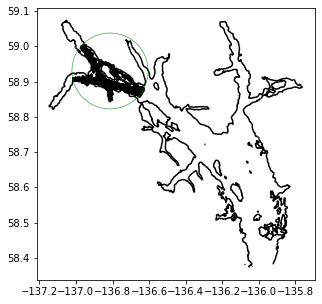

now processing MMSI: 235066752
	 7 total events thus far
now processing MMSI: 235088016
	 28 total events thus far
now processing MMSI: 244620447
	 31 total events thus far
now processing MMSI: 319009500
	 35 total events thus far
now processing MMSI: 319063600
	 57 total events thus far
now processing MMSI: 319139700
	 97 total events thus far
now processing MMSI: 319144200
	 99 total events thus far
now processing MMSI: 319147200
	 129 total events thus far
now processing MMSI: 319175300
	 130 total events thus far
now processing MMSI: 319264000
	 145 total events thus far
now processing MMSI: 319822000
	 148 total events thus far
now processing MMSI: 338043017
	 154 total events thus far
now processing MMSI: 338103017
	 157 total events thus far
now processing MMSI: 338103952
	 158 total events thus far
now processing MMSI: 338120189
	 161 total events thus far
now processing MMSI: 338236805
	 163 total events thus far
now processing MMSI: 367122330
	 166 total events thus far
now p

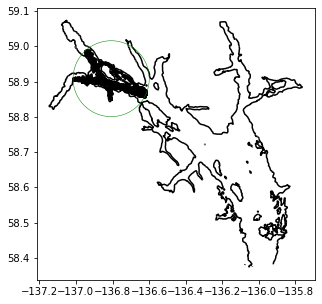

now processing MMSI: 235066752
	 7 total events thus far
now processing MMSI: 235088016
	 29 total events thus far
now processing MMSI: 244620447
	 32 total events thus far
now processing MMSI: 319009500
	 36 total events thus far
now processing MMSI: 319063600
	 58 total events thus far
now processing MMSI: 319139700
	 98 total events thus far
now processing MMSI: 319144200
	 100 total events thus far
now processing MMSI: 319147200
	 130 total events thus far
now processing MMSI: 319175300
	 131 total events thus far
now processing MMSI: 319264000
	 145 total events thus far
now processing MMSI: 319822000
	 147 total events thus far
now processing MMSI: 338043017
	 154 total events thus far
now processing MMSI: 338103017
	 156 total events thus far
now processing MMSI: 338103952
	 157 total events thus far
now processing MMSI: 338120189
	 160 total events thus far
now processing MMSI: 338236805
	 162 total events thus far
now processing MMSI: 367122330
	 165 total events thus far
now 

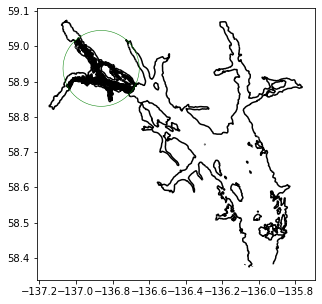

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 26 total events thus far
now processing MMSI: 244620447
	 28 total events thus far
now processing MMSI: 319009500
	 32 total events thus far
now processing MMSI: 319063600
	 54 total events thus far
now processing MMSI: 319139700
	 94 total events thus far
now processing MMSI: 319144200
	 96 total events thus far
now processing MMSI: 319147200
	 126 total events thus far
now processing MMSI: 319175300
	 128 total events thus far
now processing MMSI: 319264000
	 143 total events thus far
now processing MMSI: 319822000
	 146 total events thus far
now processing MMSI: 338043017
	 151 total events thus far
now processing MMSI: 338103017
	 154 total events thus far
now processing MMSI: 338120189
	 157 total events thus far
now processing MMSI: 338236805
	 159 total events thus far
now processing MMSI: 367122330
	 162 total events thus far
now processing MMSI: 367174080
	 167 total events thus far
now p

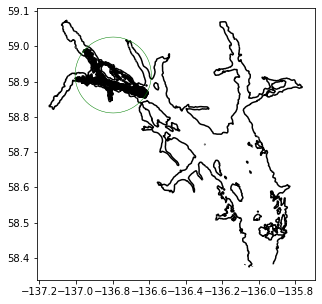

now processing MMSI: 235066752
	 7 total events thus far
now processing MMSI: 235088016
	 28 total events thus far
now processing MMSI: 244620447
	 31 total events thus far
now processing MMSI: 319009500
	 35 total events thus far
now processing MMSI: 319063600
	 57 total events thus far
now processing MMSI: 319139700
	 97 total events thus far
now processing MMSI: 319144200
	 99 total events thus far
now processing MMSI: 319147200
	 129 total events thus far
now processing MMSI: 319175300
	 130 total events thus far
now processing MMSI: 319264000
	 144 total events thus far
now processing MMSI: 319822000
	 146 total events thus far
now processing MMSI: 338043017
	 153 total events thus far
now processing MMSI: 338103017
	 155 total events thus far
now processing MMSI: 338103952
	 156 total events thus far
now processing MMSI: 338120189
	 159 total events thus far
now processing MMSI: 338236805
	 161 total events thus far
now processing MMSI: 367122330
	 164 total events thus far
now p

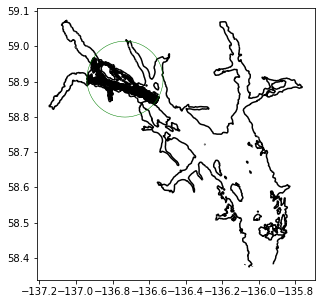

now processing MMSI: 235066752
	 8 total events thus far
now processing MMSI: 235088016
	 29 total events thus far
now processing MMSI: 244620447
	 32 total events thus far
now processing MMSI: 319009500
	 36 total events thus far
now processing MMSI: 319063600
	 56 total events thus far
now processing MMSI: 319139700
	 96 total events thus far
now processing MMSI: 319144200
	 98 total events thus far
now processing MMSI: 319147200
	 128 total events thus far
now processing MMSI: 319175300
	 129 total events thus far
now processing MMSI: 319264000
	 139 total events thus far
now processing MMSI: 319822000
	 141 total events thus far
now processing MMSI: 338043017
	 148 total events thus far
now processing MMSI: 338103017
	 150 total events thus far
now processing MMSI: 338103952
	 151 total events thus far
now processing MMSI: 338120189
	 154 total events thus far
now processing MMSI: 338236805
	 155 total events thus far
now processing MMSI: 367122330
	 157 total events thus far
now p

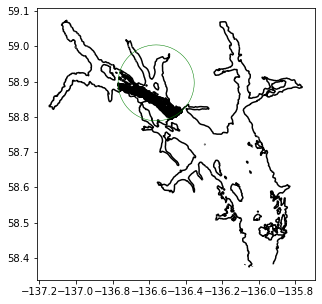

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 319009500
	 12 total events thus far
now processing MMSI: 319063600
	 14 total events thus far
now processing MMSI: 319139700
	 16 total events thus far
now processing MMSI: 319144200
	 18 total events thus far
now processing MMSI: 319147200
	 20 total events thus far
now processing MMSI: 319175300
	 21 total events thus far
now processing MMSI: 319264000
	 28 total events thus far
now processing MMSI: 338043017
	 34 total events thus far
now processing MMSI: 338103017
	 36 total events thus far
now processing MMSI: 338103952
	 37 total events thus far
now processing MMSI: 338120189
	 41 total events thus far
now processing MMSI: 367174080
	 46 total events thus far
now processing MMSI: 367421750
	 47 total events thus far
now processing MMSI: 367450080
	 48 total events thus far
now processing M

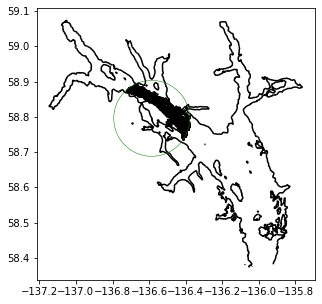

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 7 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 17 total events thus far
now processing MMSI: 319139700
	 19 total events thus far
now processing MMSI: 319144200
	 36 total events thus far
now processing MMSI: 319147200
	 38 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 56 total events thus far
now processing MMSI: 338043017
	 60 total events thus far
now processing MMSI: 338103017
	 63 total events thus far
now processing MMSI: 338103952
	 65 total events thus far
now processing MMSI: 338120189
	 70 total events thus far
now processing MMSI: 367122330
	 71 total events thus far
now processing MMSI: 367174080
	 76 total events thus far
now processing MM

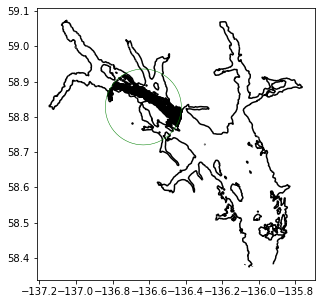

now processing MMSI: 235066752
	 7 total events thus far
now processing MMSI: 235088016
	 10 total events thus far
now processing MMSI: 244620447
	 13 total events thus far
now processing MMSI: 319009500
	 16 total events thus far
now processing MMSI: 319063600
	 35 total events thus far
now processing MMSI: 319139700
	 37 total events thus far
now processing MMSI: 319144200
	 54 total events thus far
now processing MMSI: 319147200
	 56 total events thus far
now processing MMSI: 319175300
	 57 total events thus far
now processing MMSI: 319264000
	 76 total events thus far
now processing MMSI: 338043017
	 82 total events thus far
now processing MMSI: 338103017
	 85 total events thus far
now processing MMSI: 338103952
	 87 total events thus far
now processing MMSI: 338120189
	 91 total events thus far
now processing MMSI: 367122330
	 93 total events thus far
now processing MMSI: 367174080
	 100 total events thus far
now processing MMSI: 367421750
	 101 total events thus far
now processin

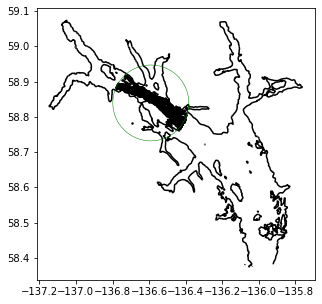

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319139700
	 18 total events thus far
now processing MMSI: 319144200
	 35 total events thus far
now processing MMSI: 319147200
	 37 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 55 total events thus far
now processing MMSI: 338043017
	 61 total events thus far
now processing MMSI: 338103017
	 64 total events thus far
now processing MMSI: 338103952
	 66 total events thus far
now processing MMSI: 338120189
	 71 total events thus far
now processing MMSI: 367174080
	 77 total events thus far
now processing MMSI: 367421750
	 78 total events thus far
now processing MMSI: 367450080
	 80 total events thus far
now processing M

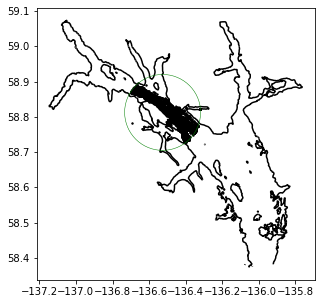

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 7 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 17 total events thus far
now processing MMSI: 319139700
	 19 total events thus far
now processing MMSI: 319144200
	 36 total events thus far
now processing MMSI: 319147200
	 38 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 56 total events thus far
now processing MMSI: 338043017
	 61 total events thus far
now processing MMSI: 338103017
	 64 total events thus far
now processing MMSI: 338103952
	 66 total events thus far
now processing MMSI: 338120189
	 71 total events thus far
now processing MMSI: 338236805
	 72 total events thus far
now processing MMSI: 367122330
	 73 total events thus far
now processing MM

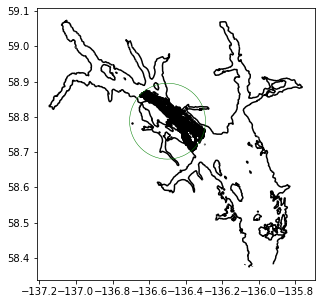

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 55 total events thus far
now processing MMSI: 319822000
	 56 total events thus far
now processing MMSI: 338043017
	 60 total events thus far
now processing MMSI: 338103017
	 63 total events thus far
now processing MMSI: 338103952
	 64 total events thus far
now processing MMSI: 338120189
	 70 total events thus far
now processing MMSI: 338236805
	 71 total events thus far
now processing MM

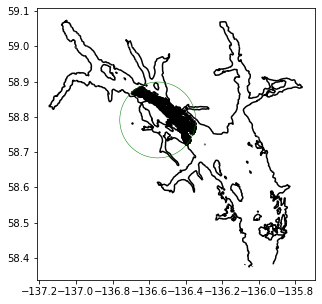

now processing MMSI: 235066752
	 5 total events thus far
now processing MMSI: 235088016
	 7 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 17 total events thus far
now processing MMSI: 319139700
	 19 total events thus far
now processing MMSI: 319144200
	 36 total events thus far
now processing MMSI: 319147200
	 38 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 56 total events thus far
now processing MMSI: 338043017
	 60 total events thus far
now processing MMSI: 338103017
	 63 total events thus far
now processing MMSI: 338103952
	 65 total events thus far
now processing MMSI: 338120189
	 70 total events thus far
now processing MMSI: 338236805
	 71 total events thus far
now processing MMSI: 367122330
	 72 total events thus far
now processing MM

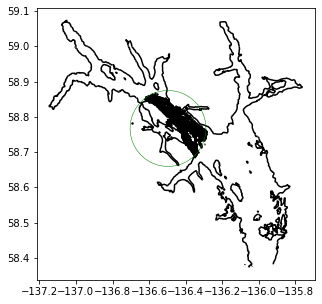

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 54 total events thus far
now processing MMSI: 319822000
	 55 total events thus far
now processing MMSI: 338043017
	 58 total events thus far
now processing MMSI: 338103017
	 61 total events thus far
now processing MMSI: 338103952
	 62 total events thus far
now processing MMSI: 338120189
	 68 total events thus far
now processing MMSI: 338236805
	 69 total events thus far
now processing MM

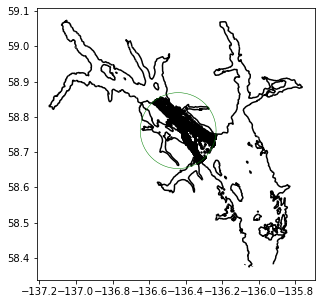

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 316005813
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 18 total events thus far
now processing MMSI: 319139700
	 20 total events thus far
now processing MMSI: 319144200
	 37 total events thus far
now processing MMSI: 319147200
	 39 total events thus far
now processing MMSI: 319175300
	 41 total events thus far
now processing MMSI: 319264000
	 57 total events thus far
now processing MMSI: 319822000
	 58 total events thus far
now processing MMSI: 338043017
	 63 total events thus far
now processing MMSI: 338103017
	 66 total events thus far
now processing MMSI: 338103952
	 67 total events thus far
now processing MMSI: 338120189
	 73 total events thus far
now processing MM

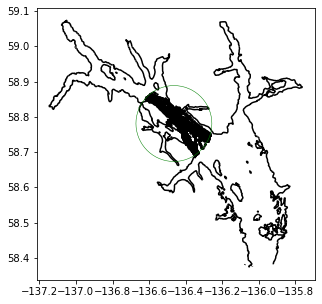

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 7 total events thus far
now processing MMSI: 244620447
	 11 total events thus far
now processing MMSI: 319009500
	 13 total events thus far
now processing MMSI: 319063600
	 15 total events thus far
now processing MMSI: 319139700
	 17 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 54 total events thus far
now processing MMSI: 319822000
	 55 total events thus far
now processing MMSI: 338043017
	 59 total events thus far
now processing MMSI: 338103017
	 62 total events thus far
now processing MMSI: 338103952
	 63 total events thus far
now processing MMSI: 338120189
	 69 total events thus far
now processing MMSI: 338166495
	 70 total events thus far
now processing MM

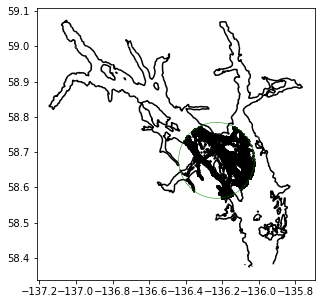

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 244620447
	 14 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 38 total events thus far
now processing MMSI: 319139700
	 40 total events thus far
now processing MMSI: 319144200
	 43 total events thus far
now processing MMSI: 319147200
	 45 total events thus far
now processing MMSI: 319175300
	 49 total events thus far
now processing MMSI: 319264000
	 53 total events thus far
now processing MMSI: 319822000
	 58 total events thus far
now processing MMSI: 338043017
	 75 total events thus far
now processing MMSI: 338103017
	 78 total events thus far
now processing MMSI: 338103952
	 80 total events thus far
now processing MMSI: 338120189
	 93 total events thus far
now processing MM

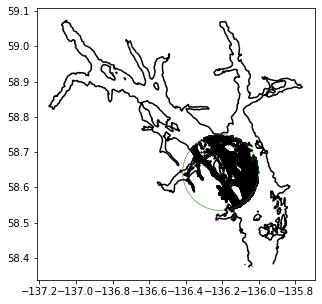

now processing MMSI: 235066752
	 3 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 10 total events thus far
now processing MMSI: 244620447
	 15 total events thus far
now processing MMSI: 316005813
	 22 total events thus far
now processing MMSI: 319009500
	 25 total events thus far
now processing MMSI: 319063600
	 40 total events thus far
now processing MMSI: 319139700
	 42 total events thus far
now processing MMSI: 319144200
	 45 total events thus far
now processing MMSI: 319147200
	 47 total events thus far
now processing MMSI: 319175300
	 51 total events thus far
now processing MMSI: 319264000
	 57 total events thus far
now processing MMSI: 319822000
	 63 total events thus far
now processing MMSI: 338043017
	 78 total events thus far
now processing MMSI: 338103017
	 82 total events thus far
now processing MMSI: 338103952
	 85 total events thus far
now processing MMSI: 338120189
	 98 total events thus far
now processing M

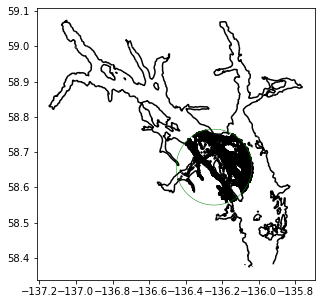

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 10 total events thus far
now processing MMSI: 244620447
	 15 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 38 total events thus far
now processing MMSI: 319139700
	 40 total events thus far
now processing MMSI: 319144200
	 43 total events thus far
now processing MMSI: 319147200
	 45 total events thus far
now processing MMSI: 319175300
	 48 total events thus far
now processing MMSI: 319264000
	 52 total events thus far
now processing MMSI: 319822000
	 57 total events thus far
now processing MMSI: 338043017
	 74 total events thus far
now processing MMSI: 338103017
	 77 total events thus far
now processing MMSI: 338103952
	 79 total events thus far
now processing MMSI: 338120189
	 92 total events thus far
now processing M

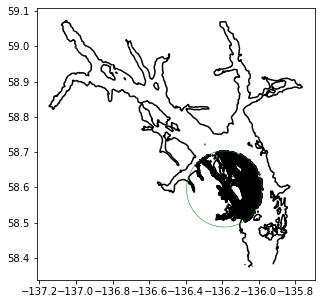

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 15 total events thus far
now processing MMSI: 319009500
	 17 total events thus far
now processing MMSI: 319063600
	 31 total events thus far
now processing MMSI: 319139700
	 33 total events thus far
now processing MMSI: 319144200
	 35 total events thus far
now processing MMSI: 319147200
	 37 total events thus far
now processing MMSI: 319175300
	 44 total events thus far
now processing MMSI: 319264000
	 48 total events thus far
now processing MMSI: 319822000
	 55 total events thus far
now processing MMSI: 338043017
	 69 total events thus far
now processing MMSI: 338103017
	 71 total events thus far
now processing MMSI: 338103952
	 74 total events thus far
now processing MMSI: 338120189
	 87 total events thus far
now processing MM

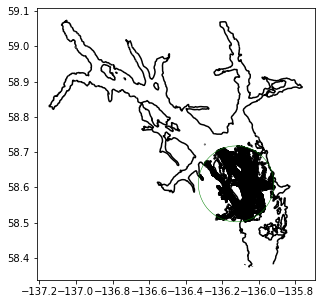

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 18 total events thus far
now processing MMSI: 319009500
	 21 total events thus far
now processing MMSI: 319063600
	 35 total events thus far
now processing MMSI: 319139700
	 37 total events thus far
now processing MMSI: 319144200
	 39 total events thus far
now processing MMSI: 319147200
	 41 total events thus far
now processing MMSI: 319175300
	 48 total events thus far
now processing MMSI: 319264000
	 52 total events thus far
now processing MMSI: 319822000
	 57 total events thus far
now processing MMSI: 338043017
	 71 total events thus far
now processing MMSI: 338103017
	 73 total events thus far
now processing MMSI: 338103952
	 76 total events thus far
now processing MMSI: 338120189
	 89 total events thus far
now processing MM

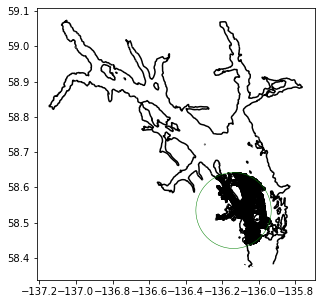

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 12 total events thus far
now processing MMSI: 319009500
	 14 total events thus far
now processing MMSI: 319063600
	 16 total events thus far
now processing MMSI: 319139700
	 18 total events thus far
now processing MMSI: 319144200
	 20 total events thus far
now processing MMSI: 319147200
	 22 total events thus far
now processing MMSI: 319175300
	 29 total events thus far
now processing MMSI: 319264000
	 33 total events thus far
now processing MMSI: 319822000
	 39 total events thus far
now processing MMSI: 338043017
	 41 total events thus far
now processing MMSI: 338103017
	 43 total events thus far
now processing MMSI: 338103952
	 47 total events thus far
now processing MMSI: 338120189
	 60 total events thus far
now processing MM

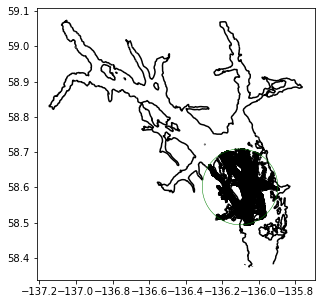

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 17 total events thus far
now processing MMSI: 319009500
	 19 total events thus far
now processing MMSI: 319063600
	 21 total events thus far
now processing MMSI: 319139700
	 23 total events thus far
now processing MMSI: 319144200
	 25 total events thus far
now processing MMSI: 319147200
	 27 total events thus far
now processing MMSI: 319175300
	 34 total events thus far
now processing MMSI: 319264000
	 38 total events thus far
now processing MMSI: 319822000
	 44 total events thus far
now processing MMSI: 338043017
	 46 total events thus far
now processing MMSI: 338103017
	 48 total events thus far
now processing MMSI: 338103952
	 52 total events thus far
now processing MMSI: 338120189
	 65 total events thus far
now processing MM

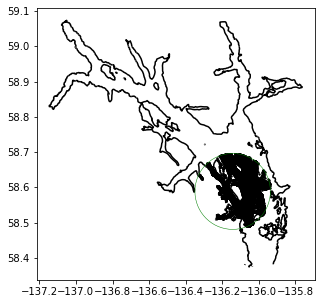

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 15 total events thus far
now processing MMSI: 319009500
	 17 total events thus far
now processing MMSI: 319063600
	 31 total events thus far
now processing MMSI: 319139700
	 33 total events thus far
now processing MMSI: 319144200
	 35 total events thus far
now processing MMSI: 319147200
	 37 total events thus far
now processing MMSI: 319175300
	 44 total events thus far
now processing MMSI: 319264000
	 48 total events thus far
now processing MMSI: 319822000
	 54 total events thus far
now processing MMSI: 338043017
	 67 total events thus far
now processing MMSI: 338103017
	 69 total events thus far
now processing MMSI: 338103952
	 73 total events thus far
now processing MMSI: 338120189
	 86 total events thus far
now processing MM

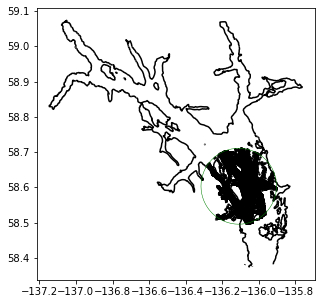

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 17 total events thus far
now processing MMSI: 319009500
	 20 total events thus far
now processing MMSI: 319063600
	 22 total events thus far
now processing MMSI: 319139700
	 24 total events thus far
now processing MMSI: 319144200
	 26 total events thus far
now processing MMSI: 319147200
	 28 total events thus far
now processing MMSI: 319175300
	 35 total events thus far
now processing MMSI: 319264000
	 39 total events thus far
now processing MMSI: 319822000
	 45 total events thus far
now processing MMSI: 338043017
	 47 total events thus far
now processing MMSI: 338103017
	 49 total events thus far
now processing MMSI: 338103952
	 52 total events thus far
now processing MMSI: 338120189
	 65 total events thus far
now processing MM

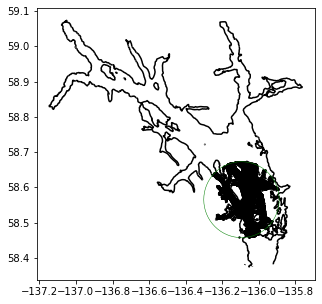

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 10 total events thus far
now processing MMSI: 316005813
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 17 total events thus far
now processing MMSI: 319139700
	 19 total events thus far
now processing MMSI: 319144200
	 21 total events thus far
now processing MMSI: 319147200
	 23 total events thus far
now processing MMSI: 319175300
	 31 total events thus far
now processing MMSI: 319264000
	 35 total events thus far
now processing MMSI: 319822000
	 41 total events thus far
now processing MMSI: 338043017
	 43 total events thus far
now processing MMSI: 338103017
	 45 total events thus far
now processing MMSI: 338103952
	 49 total events thus far
now processing MMSI: 338120189
	 62 total events thus far
now processing MM

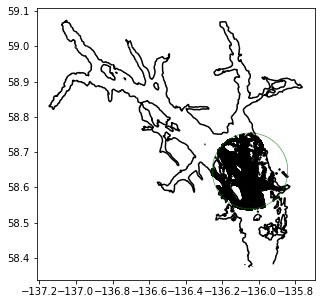

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244058902
	 12 total events thus far
now processing MMSI: 244620447
	 14 total events thus far
now processing MMSI: 316005813
	 26 total events thus far
now processing MMSI: 319009500
	 32 total events thus far
now processing MMSI: 319063600
	 34 total events thus far
now processing MMSI: 319139700
	 36 total events thus far
now processing MMSI: 319144200
	 38 total events thus far
now processing MMSI: 319147200
	 40 total events thus far
now processing MMSI: 319175300
	 49 total events thus far
now processing MMSI: 319264000
	 60 total events thus far
now processing MMSI: 319822000
	 70 total events thus far
now processing MMSI: 338043017
	 72 total events thus far
now processing MMSI: 338103017
	 78 total events thus far
now processing MMSI: 338103952
	 81 total events thus far
now processing MMSI: 338120189
	 94 total events thus far
now processing M

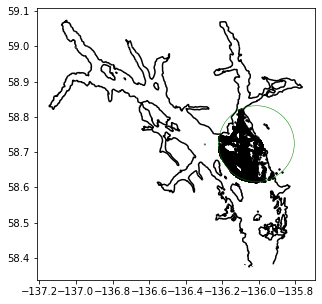

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 319009500
	 26 total events thus far
now processing MMSI: 319063600
	 27 total events thus far
now processing MMSI: 319139700
	 29 total events thus far
now processing MMSI: 319144200
	 31 total events thus far
now processing MMSI: 319147200
	 33 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 48 total events thus far
now processing MMSI: 319822000
	 54 total events thus far
now processing MMSI: 338043017
	 55 total events thus far
now processing MMSI: 338103017
	 61 total events thus far
now processing MMSI: 338103952
	 64 total events thus far
now processing MMSI: 367122330
	 66 total events thus far
now processing MMSI: 367174080
	 73 total events thus far
now processing MM

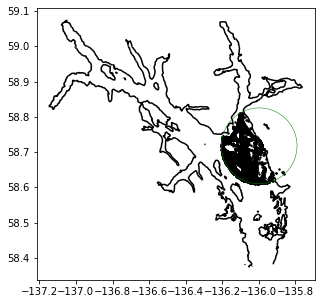

now processing MMSI: 235066752
	 6 total events thus far
now processing MMSI: 235088016
	 8 total events thus far
now processing MMSI: 244058902
	 9 total events thus far
now processing MMSI: 316005813
	 20 total events thus far
now processing MMSI: 319009500
	 26 total events thus far
now processing MMSI: 319063600
	 27 total events thus far
now processing MMSI: 319139700
	 29 total events thus far
now processing MMSI: 319144200
	 31 total events thus far
now processing MMSI: 319147200
	 33 total events thus far
now processing MMSI: 319175300
	 39 total events thus far
now processing MMSI: 319264000
	 48 total events thus far
now processing MMSI: 319822000
	 54 total events thus far
now processing MMSI: 338043017
	 55 total events thus far
now processing MMSI: 338103017
	 61 total events thus far
now processing MMSI: 338103952
	 64 total events thus far
now processing MMSI: 338166495
	 65 total events thus far
now processing MMSI: 338313153
	 66 total events thus far
now processing MM

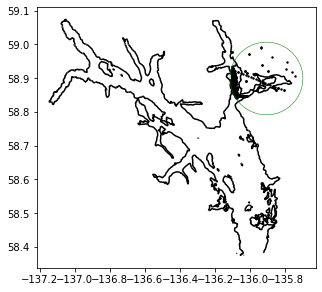

now processing MMSI: 319144200
	 2 total events thus far
now processing MMSI: 367624970
	 8 total events thus far
now processing MMSI: 368069540
	 10 total events thus far
now processing MMSI: 368087940
	 42 total events thus far
now processing MMSI: 368089260
	 43 total events thus far
now processing MMSI: 368089270
	 50 total events thus far
now processing MMSI: 368152380
	 51 total events thus far
now processing MMSI: 369970398
	 53 total events thus far
now processing MMSI: 538071368
	 55 total events thus far
now processing MMSI: 538071405
	 100 total events thus far
Simulated event rate: 3.0303030303030303
Now computing POINT (-135.8569207208789 58.8922330219394)


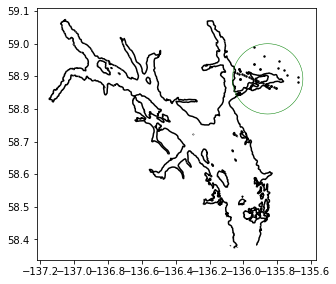

now processing MMSI: 367624970
	 7 total events thus far
now processing MMSI: 538071405
	 52 total events thus far
Simulated event rate: 5.777777777777778
Now computing POINT (-136.0919648519485 58.48138392374758)


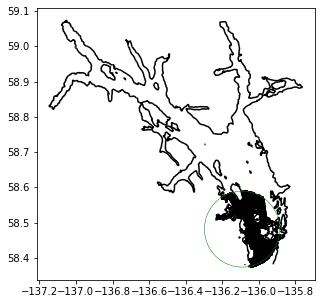

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 8 total events thus far
now processing MMSI: 244620447
	 12 total events thus far
now processing MMSI: 316005813
	 15 total events thus far
now processing MMSI: 319009500
	 17 total events thus far
now processing MMSI: 319063600
	 19 total events thus far
now processing MMSI: 319139700
	 21 total events thus far
now processing MMSI: 319144200
	 23 total events thus far
now processing MMSI: 319147200
	 25 total events thus far
now processing MMSI: 319175300
	 31 total events thus far
now processing MMSI: 319264000
	 34 total events thus far
now processing MMSI: 319822000
	 41 total events thus far
now processing MMSI: 338043017
	 43 total events thus far
now processing MMSI: 338103017
	 46 total events thus far
now processing MMSI: 338103952
	 52 total events thus far
now processing MMSI: 338120189
	 54 total events thus far
now processing MM

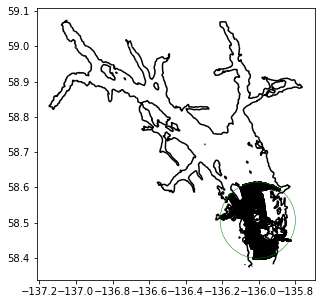

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 16 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 316005813
	 22 total events thus far
now processing MMSI: 319009500
	 24 total events thus far
now processing MMSI: 319063600
	 26 total events thus far
now processing MMSI: 319139700
	 28 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 32 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 41 total events thus far
now processing MMSI: 319822000
	 48 total events thus far
now processing MMSI: 338043017
	 50 total events thus far
now processing MMSI: 338103017
	 52 total events thus far
now processing MMSI: 338103952
	 73 total events thus far
now processing MMSI: 338120189
	 75 total events thus far
now processing M

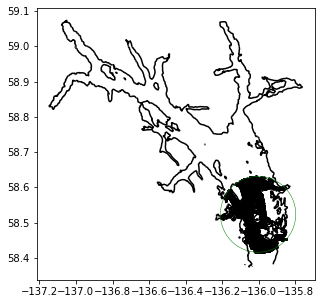

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 17 total events thus far
now processing MMSI: 244620447
	 21 total events thus far
now processing MMSI: 316005813
	 23 total events thus far
now processing MMSI: 319009500
	 25 total events thus far
now processing MMSI: 319063600
	 27 total events thus far
now processing MMSI: 319139700
	 29 total events thus far
now processing MMSI: 319144200
	 31 total events thus far
now processing MMSI: 319147200
	 33 total events thus far
now processing MMSI: 319175300
	 40 total events thus far
now processing MMSI: 319264000
	 43 total events thus far
now processing MMSI: 319822000
	 50 total events thus far
now processing MMSI: 338043017
	 52 total events thus far
now processing MMSI: 338103017
	 54 total events thus far
now processing MMSI: 338103952
	 75 total events thus far
now processing MMSI: 338120189
	 77 total events thus far
now processing M

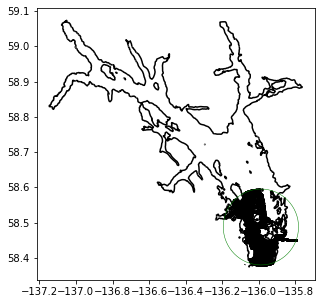

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 16 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 316005813
	 22 total events thus far
now processing MMSI: 319009500
	 24 total events thus far
now processing MMSI: 319063600
	 26 total events thus far
now processing MMSI: 319139700
	 28 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 32 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 41 total events thus far
now processing MMSI: 319822000
	 48 total events thus far
now processing MMSI: 338043017
	 50 total events thus far
now processing MMSI: 338103017
	 52 total events thus far
now processing MMSI: 338103952
	 73 total events thus far
now processing MMSI: 338120189
	 75 total events thus far
now processing M

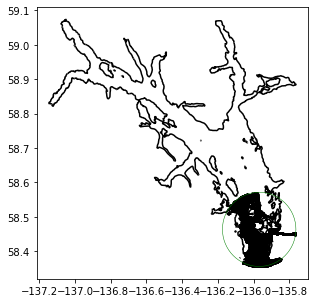

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 316011757
	 24 total events thus far
now processing MMSI: 319009500
	 26 total events thus far
now processing MMSI: 319063600
	 28 total events thus far
now processing MMSI: 319139700
	 30 total events thus far
now processing MMSI: 319144200
	 32 total events thus far
now processing MMSI: 319147200
	 34 total events thus far
now processing MMSI: 319175300
	 40 total events thus far
now processing MMSI: 319264000
	 43 total events thus far
now processing MMSI: 319822000
	 49 total events thus far
now processing MMSI: 338043017
	 51 total events thus far
now processing MMSI: 338103017
	 53 total events thus far
now processing MMSI: 338103952
	 74 total events thus far
now processing M

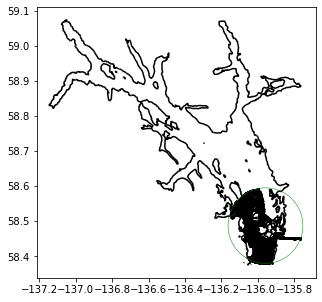

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 16 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 316005813
	 22 total events thus far
now processing MMSI: 319009500
	 24 total events thus far
now processing MMSI: 319063600
	 26 total events thus far
now processing MMSI: 319139700
	 28 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 32 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 41 total events thus far
now processing MMSI: 319822000
	 48 total events thus far
now processing MMSI: 338043017
	 50 total events thus far
now processing MMSI: 338103017
	 52 total events thus far
now processing MMSI: 338103952
	 73 total events thus far
now processing MMSI: 338120189
	 75 total events thus far
now processing M

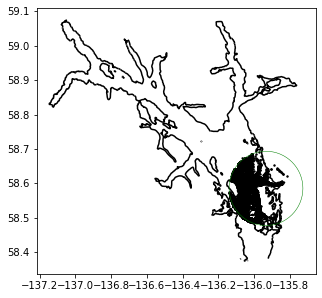

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 8 total events thus far
now processing MMSI: 316005813
	 14 total events thus far
now processing MMSI: 319009500
	 16 total events thus far
now processing MMSI: 319063600
	 18 total events thus far
now processing MMSI: 319139700
	 20 total events thus far
now processing MMSI: 319144200
	 22 total events thus far
now processing MMSI: 319147200
	 24 total events thus far
now processing MMSI: 319175300
	 30 total events thus far
now processing MMSI: 319264000
	 34 total events thus far
now processing MMSI: 319822000
	 40 total events thus far
now processing MMSI: 338043017
	 42 total events thus far
now processing MMSI: 338103017
	 44 total events thus far
now processing MMSI: 338103952
	 48 total events thus far
now processing MMSI: 338120189
	 50 total events thus far
now processing MMS

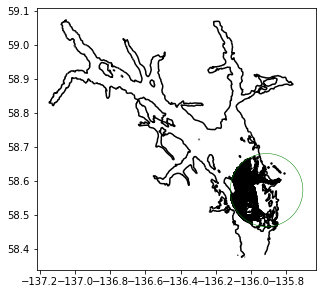

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 6 total events thus far
now processing MMSI: 244620447
	 8 total events thus far
now processing MMSI: 316005813
	 13 total events thus far
now processing MMSI: 319009500
	 15 total events thus far
now processing MMSI: 319063600
	 17 total events thus far
now processing MMSI: 319139700
	 19 total events thus far
now processing MMSI: 319144200
	 21 total events thus far
now processing MMSI: 319147200
	 23 total events thus far
now processing MMSI: 319175300
	 29 total events thus far
now processing MMSI: 319264000
	 33 total events thus far
now processing MMSI: 319822000
	 39 total events thus far
now processing MMSI: 338043017
	 41 total events thus far
now processing MMSI: 338103017
	 43 total events thus far
now processing MMSI: 338103952
	 47 total events thus far
now processing MMSI: 338120189
	 49 total events thus far
now processing MMS

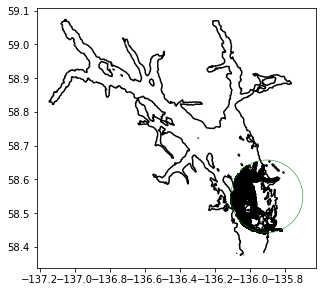

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 5 total events thus far
now processing MMSI: 244058902
	 19 total events thus far
now processing MMSI: 244620447
	 24 total events thus far
now processing MMSI: 316005813
	 28 total events thus far
now processing MMSI: 319009500
	 30 total events thus far
now processing MMSI: 319063600
	 32 total events thus far
now processing MMSI: 319139700
	 34 total events thus far
now processing MMSI: 319144200
	 37 total events thus far
now processing MMSI: 319147200
	 39 total events thus far
now processing MMSI: 319175300
	 45 total events thus far
now processing MMSI: 319264000
	 50 total events thus far
now processing MMSI: 319822000
	 56 total events thus far
now processing MMSI: 338043017
	 58 total events thus far
now processing MMSI: 338103017
	 61 total events thus far
now processing MMSI: 338103952
	 84 total events thus far
now processing MMSI: 338120189
	 86 total events thus far
now processing M

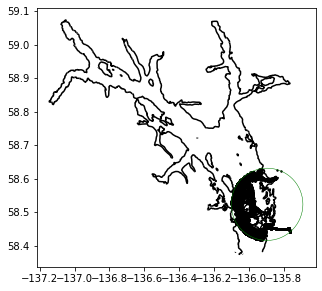

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 16 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 316005813
	 22 total events thus far
now processing MMSI: 319009500
	 24 total events thus far
now processing MMSI: 319063600
	 26 total events thus far
now processing MMSI: 319139700
	 28 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 32 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 41 total events thus far
now processing MMSI: 319822000
	 47 total events thus far
now processing MMSI: 338043017
	 49 total events thus far
now processing MMSI: 338103017
	 51 total events thus far
now processing MMSI: 338103952
	 72 total events thus far
now processing MMSI: 338120189
	 74 total events thus far
now processing M

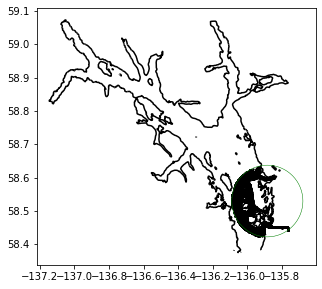

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 16 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 316005813
	 22 total events thus far
now processing MMSI: 319009500
	 24 total events thus far
now processing MMSI: 319063600
	 26 total events thus far
now processing MMSI: 319139700
	 28 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 32 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 41 total events thus far
now processing MMSI: 319822000
	 47 total events thus far
now processing MMSI: 338043017
	 49 total events thus far
now processing MMSI: 338103017
	 51 total events thus far
now processing MMSI: 338103952
	 72 total events thus far
now processing MMSI: 338120189
	 74 total events thus far
now processing M

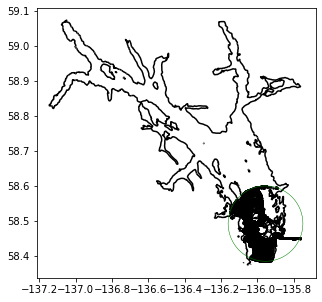

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 16 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 316005813
	 22 total events thus far
now processing MMSI: 319009500
	 24 total events thus far
now processing MMSI: 319063600
	 26 total events thus far
now processing MMSI: 319139700
	 28 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 32 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 41 total events thus far
now processing MMSI: 319822000
	 48 total events thus far
now processing MMSI: 338043017
	 50 total events thus far
now processing MMSI: 338103017
	 52 total events thus far
now processing MMSI: 338103952
	 73 total events thus far
now processing MMSI: 338120189
	 75 total events thus far
now processing M

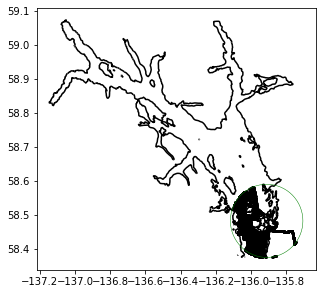

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 46 total events thus far
now processing MMSI: 338043017
	 48 total events thus far
now processing MMSI: 338103017
	 50 total events thus far
now processing MMSI: 338103952
	 71 total events thus far
now processing MMSI: 338120189
	 73 total events thus far
now processing M

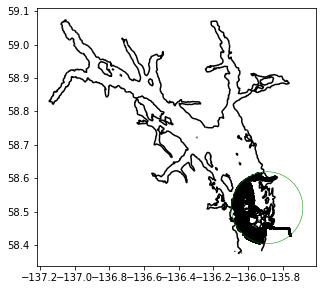

now processing MMSI: 235066752
	 2 total events thus far
now processing MMSI: 235088016
	 4 total events thus far
now processing MMSI: 244058902
	 16 total events thus far
now processing MMSI: 244620447
	 20 total events thus far
now processing MMSI: 316005813
	 22 total events thus far
now processing MMSI: 319009500
	 24 total events thus far
now processing MMSI: 319063600
	 26 total events thus far
now processing MMSI: 319139700
	 28 total events thus far
now processing MMSI: 319144200
	 30 total events thus far
now processing MMSI: 319147200
	 32 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 41 total events thus far
now processing MMSI: 319822000
	 46 total events thus far
now processing MMSI: 338043017
	 48 total events thus far
now processing MMSI: 338103017
	 50 total events thus far
now processing MMSI: 338103952
	 71 total events thus far
now processing MMSI: 338120189
	 73 total events thus far
now processing M

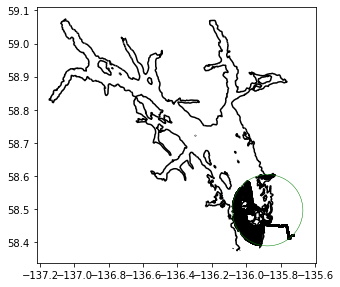

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 46 total events thus far
now processing MMSI: 338043017
	 48 total events thus far
now processing MMSI: 338103017
	 50 total events thus far
now processing MMSI: 338103952
	 71 total events thus far
now processing MMSI: 338120189
	 73 total events thus far
now processing M

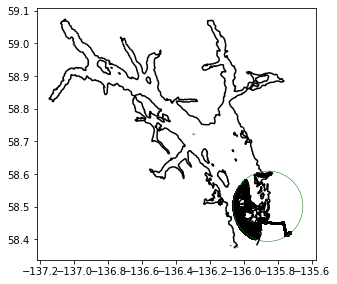

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 45 total events thus far
now processing MMSI: 338043017
	 47 total events thus far
now processing MMSI: 338103017
	 49 total events thus far
now processing MMSI: 338103952
	 70 total events thus far
now processing MMSI: 338120189
	 72 total events thus far
now processing M

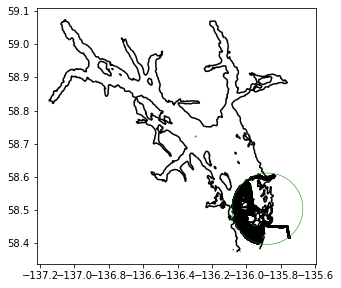

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 46 total events thus far
now processing MMSI: 338043017
	 48 total events thus far
now processing MMSI: 338103017
	 50 total events thus far
now processing MMSI: 338103952
	 71 total events thus far
now processing MMSI: 338120189
	 73 total events thus far
now processing M

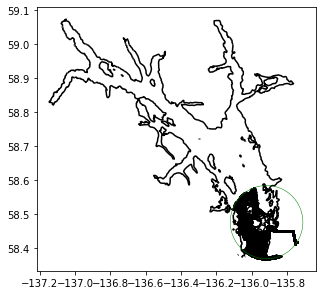

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 46 total events thus far
now processing MMSI: 338043017
	 48 total events thus far
now processing MMSI: 338103017
	 50 total events thus far
now processing MMSI: 338103952
	 71 total events thus far
now processing MMSI: 338120189
	 73 total events thus far
now processing M

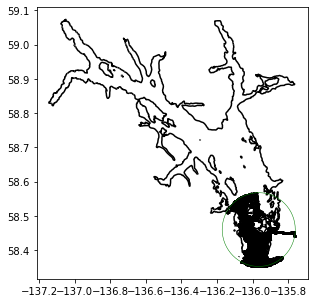

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 316011757
	 26 total events thus far
now processing MMSI: 319009500
	 28 total events thus far
now processing MMSI: 319063600
	 30 total events thus far
now processing MMSI: 319139700
	 32 total events thus far
now processing MMSI: 319144200
	 34 total events thus far
now processing MMSI: 319147200
	 36 total events thus far
now processing MMSI: 319175300
	 42 total events thus far
now processing MMSI: 319264000
	 45 total events thus far
now processing MMSI: 319822000
	 51 total events thus far
now processing MMSI: 338043017
	 53 total events thus far
now processing MMSI: 338103017
	 55 total events thus far
now processing MMSI: 338103952
	 76 total events thus far
now processing M

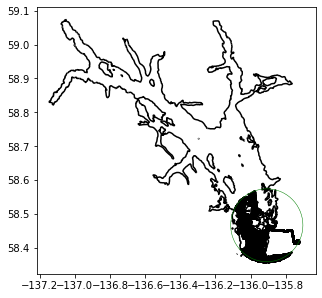

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 38 total events thus far
now processing MMSI: 319264000
	 41 total events thus far
now processing MMSI: 319822000
	 48 total events thus far
now processing MMSI: 338043017
	 50 total events thus far
now processing MMSI: 338103017
	 52 total events thus far
now processing MMSI: 338103952
	 73 total events thus far
now processing MMSI: 338120189
	 75 total events thus far
now processing M

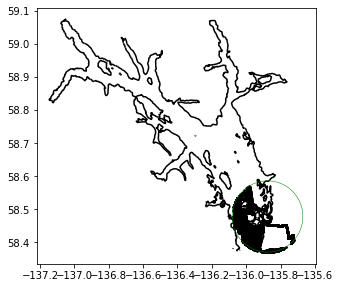

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 46 total events thus far
now processing MMSI: 338043017
	 48 total events thus far
now processing MMSI: 338103017
	 50 total events thus far
now processing MMSI: 338103952
	 71 total events thus far
now processing MMSI: 338120189
	 73 total events thus far
now processing M

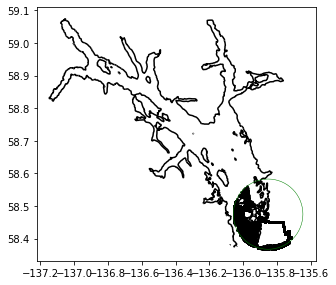

now processing MMSI: 235066752
	 1 total events thus far
now processing MMSI: 235088016
	 3 total events thus far
now processing MMSI: 244058902
	 15 total events thus far
now processing MMSI: 244620447
	 19 total events thus far
now processing MMSI: 316005813
	 21 total events thus far
now processing MMSI: 319009500
	 23 total events thus far
now processing MMSI: 319063600
	 25 total events thus far
now processing MMSI: 319139700
	 27 total events thus far
now processing MMSI: 319144200
	 29 total events thus far
now processing MMSI: 319147200
	 31 total events thus far
now processing MMSI: 319175300
	 37 total events thus far
now processing MMSI: 319264000
	 40 total events thus far
now processing MMSI: 319822000
	 47 total events thus far
now processing MMSI: 338043017
	 49 total events thus far
now processing MMSI: 338103017
	 51 total events thus far
now processing MMSI: 338103952
	 73 total events thus far
now processing MMSI: 338120189
	 75 total events thus far
now processing M

In [403]:
simulated_nfis = []
simulated_ns = []

for _, row in BayPoints.iloc[::100, :].iterrows():
    
    point = row[0]
    print("Now computing", point)
    buf = point_buffer(point.y, point.x, km=12)
    
    # filter the AIS points within the buffer
    tracks = AIS[AIS.within(buf)]
    
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    gpd.GeoDataFrame([], geometry=[buf]).exterior.plot(color="green", lw=0.5, zorder=2, ax=ax)
    tracks.plot(markersize=2, color="k", ax=ax)
    theBay_WGS84.plot(ax=ax, color="k", zorder=-1)
    plt.show()
    plt.close()

    # determine the temporal extent of the AIS record at this location
    days_tracked = np.unique(tracks['Datetime'].dt.date)
    n_days = len(days_tracked)
    
    try:    
        # compute the geometric NFI
        nfi_est, n_events = geometric_nfi(tracks)
    

        n = n_events/n_days
        simulated_nfis.append(nfi_est)
        simulated_ns.append(n)
        print("Simulated event rate:", n)
        
    except:
        print("Error! likely a quiet area with very few tracks..")


## Step Four: plot the results

C:\Users\DBetchkal\AppData\Local\Temp\1\ipykernel_32492\44583579.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 30])


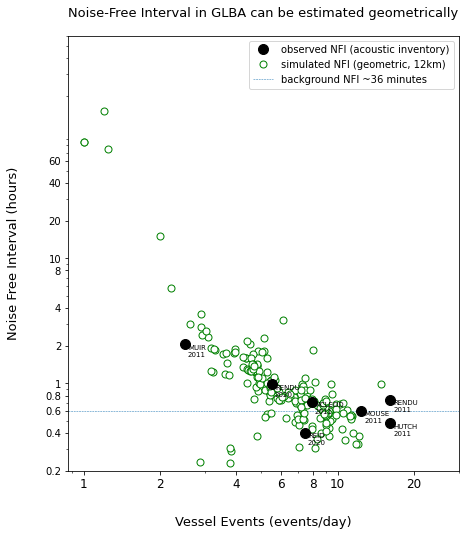

In [408]:
# 15/A
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

for des, n, median_nfi in zip(designators, ns, [np.nanpercentile(l, 50) for l in nfis]):
    ax.annotate(des[1]+"\n"+des[2], (n*1.03, median_nfi*0.8), fontsize=7)

ax.plot(ns, [np.nanpercentile(l, 50) for l in nfis], 
        ls="", marker="o", markersize=10, color="k",
        label="observed NFI (acoustic inventory)")

# A=np.log10(4.5)
# A = 2/(1+np.sqrt(5))
# A=1
A=0.5
ax.plot(simulated_ns, 
        [A*np.percentile(f, 50)/3600 for f in simulated_nfis], 
        ls="", marker="o", markersize=7, markerfacecolor="white", color="green",
        label="simulated NFI (geometric, 12km)", zorder=-2)

ax.axhline(0.6, lw=0.5, zorder=-3, ls="--", label="background NFI ~36 minutes")

ax.legend()
ax.set_title("Noise-Free Interval in GLBA can be estimated geometrically", loc="left", fontsize=13, y=1.03)

import matplotlib.ticker as mticker
ax.set_yscale('log')
ax.set_xscale('log')
x_labels = ["1", "2", "4", "6", "8", "10", "20", "40", "60", "80"]
y_labels = ["0.1", "0.2", "0.4", "0.6", "0.8", "1", "2", "4", "8", "10", "20", "40", "60"]
ax.set_xticks([int(s) for s in x_labels])
ax.set_xticklabels(x_labels, fontsize=12)
ax.set_yticks([float(s) for s in y_labels])
ax.set_yticklabels(y_labels, fontsize=10)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

ax.set_xlabel('Vessel Events (events/day)', fontsize=13, labelpad=25)
ax.set_ylabel('Noise Free Interval (hours)', fontsize=13, labelpad=25)

plt.ylim([0.2, 600])
plt.xlim([0, 30])

# plt.savefig(r"C:\Users\DBetchkal\Desktop\GLBA_VQOR_NFI_observed+simulation_12km.png",
#             dpi=250, bbox_inches="tight", facecolor="white")
plt.show()

### Among the plots we are interested in are maps...

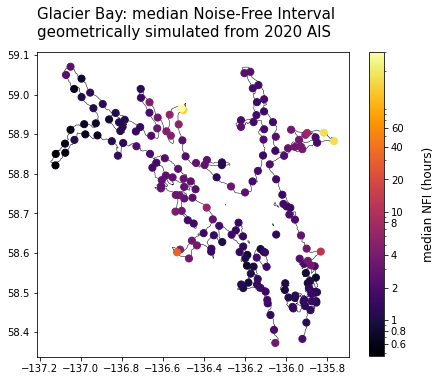

In [511]:
plotPoints = BayPoints.iloc[::100, :].copy()

A = 1
plotPoints["geometric nfi"] = [A*np.percentile(f, 50)/3600 for f in simulated_nfis]
plotPoints["n"] = simulated_ns


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.set_title("Glacier Bay: median Noise-Free Interval\ngeometrically simulated from 2020 AIS", 
             fontsize=15, loc="left", y=1.03)

plotPoints = plotPoints.sort_values("geometric nfi")
plotPoints.plot(plotPoints["geometric nfi"], ax=ax, markersize=50, cmap="inferno", 
                legend=True, legend_kwds={'shrink': 0.8}, norm=mcolor.LogNorm())

theBay_WGS84.plot(ax=ax, color="k", zorder=-5, lw=0.5)

cax = fig.get_axes()[1]
#and we can modify it, i.e.:
cax.set_ylabel('median NFI (hours)', fontsize=12, labelpad=15)

y_labels = ["0.6", "0.8", "1", "2", "4", "8", "10", "20", "40", "60"]
cax.set_yticks([float(s) for s in y_labels])
cax.set_yticklabels(y_labels, fontsize=10)

plt.savefig(r"C:\Users\DBetchkal\Desktop\GLBA_VQOR_NFI_geometric_simulation_map_AIS2020.png",
            dpi=200, bbox_inches="tight", facecolor="white")
plt.show()


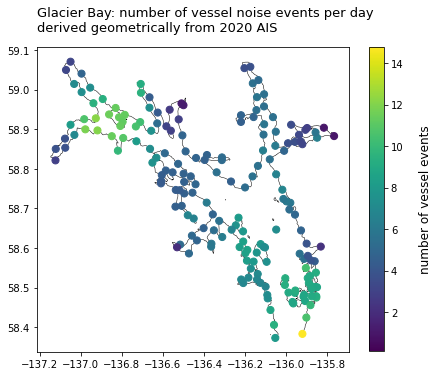

In [512]:
plotPoints = BayPoints.iloc[::100, :].copy()

A = 1
plotPoints["geometric nfi"] = [A*np.percentile(f, 50)/3600 for f in simulated_nfis]
plotPoints["n"] = simulated_ns


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.set_title("Glacier Bay: number of vessel noise events per day\nderived geometrically from 2020 AIS", 
             fontsize=13, loc="left", y=1.03)

plotPoints = plotPoints.sort_values("geometric nfi")
plotPoints.plot("n", ax=ax, markersize=50, cmap="viridis", vmin=0.1,
                legend=True, legend_kwds={'shrink': 0.8})

theBay_WGS84.plot(ax=ax, color="k", zorder=-5, lw=0.5)

cax = fig.get_axes()[1]
#and we can modify it, i.e.:
cax.set_ylabel('number of vessel events', fontsize=12, labelpad=15)

# y_labels = ["0.6", "0.8", "1", "2", "4", "8", "10", "20", "40", "60"]
# cax.set_yticks([float(s) for s in y_labels])
# cax.set_yticklabels(y_labels, fontsize=10)

plt.savefig(r"C:\Users\DBetchkal\Desktop\GLBA_VQOR_vessel_events_geometric_simulation_map_AIS2020.png",
            dpi=200, bbox_inches="tight", facecolor="white")
plt.show()

## Some theory here at the end as well
##### Detection-distance ratio, $k$
## $k = 10^{\frac{(L_{\text{GLBA}} - L_{\text{DENA}})}{20}}$

next step add in source adjust

In [401]:
# assume vessel of a similar order of magnitude to aircraft = I think this is why it's off; 
DENA_dist = 12
GLBA_dist = 12/((1+np.sqrt(5))/2)
L_DENA = 28.0 # get the actual figure
L_GLBA = 32.5 # get the actual figure

k = np.power(10, (L_GLBA-L_DENA)/20)
print("actual:", k)

k_predicted = DENA_dist/GLBA_dist
print("predicted:", k_predicted)

# there's a third piece of evidence here... 
# `GLBA_observed` needs to be adjusted by 

actual: 1.6788040181225603
predicted: 1.618033988749895
